<a href="https://colab.research.google.com/github/mianrobern2/mianrobern2/blob/main/guides/linked/ee-api-colab-setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

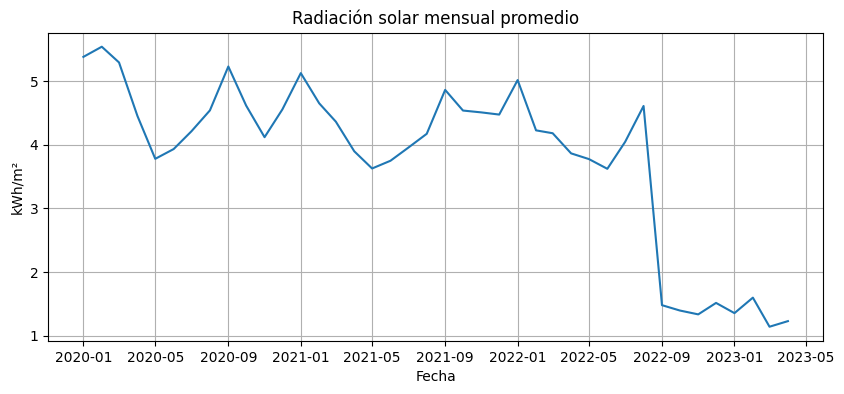

In [42]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt

ee.Authenticate()
ee.Initialize(project='braided-haiku-481319-h5')
Map = geemap.Map(center=[4.5, -74.1], zoom=6)  # Colombia
Map
# Dataset mensual
era5 = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY") \
    .select("surface_solar_radiation_downwards") \
    .filterDate("2020-01-01", "2025-10-31")
# Promedio multianual
mean_rad = era5.mean()

# Conversión J → kWh
mean_rad_kwh = mean_rad.divide(3.6e6)

vis = {
    "min": 3,
    "max": 7,
    "palette": ["blue", "cyan", "yellow", "orange", "red"]
}

Map.addLayer(mean_rad_kwh, vis, "Radiación solar promedio (kWh/m²)")
Map

polygon = ee.Geometry.Polygon([
    [
        [-74.8, 4.1],
        [-74.8, 4.5],
        [-74.2, 4.5],
        [-74.2, 4.1]
    ]
])

Map.addLayer(polygon, {}, "Área de estudio")
Map


def monthly_stats(img):
    date = ee.Date(img.get("system:time_start")).format("YYYY-MM")
    val = img.divide(3.6e6).reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=polygon,
        scale=1000,
        maxPixels=1e13
    ).get("surface_solar_radiation_downwards")
    return ee.Feature(None, {
        "date": date,
        "ghi": val
    })

ts = era5.map(monthly_stats).filter(ee.Filter.notNull(["ghi"]))


features = ts.getInfo()["features"]

rows = []
for f in features:
    rows.append(f["properties"])

df = pd.DataFrame(rows)

df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

df.head()



plt.figure(figsize=(10,4))
plt.plot(df["date"], df["ghi"])
plt.title("Radiación solar mensual promedio")
plt.ylabel("kWh/m²")
plt.xlabel("Fecha")
plt.grid(True)
plt.show()




🌞 ANÁLISIS SOLAR COMPLETO - ERA5 LAND

⚙️ Configuración:
   Período: 2020-01-01 a 2025-11-30
   Región: {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[-74.8, 4.099999999999974], [-74.2, 4.099999999999974], [-74.2, 4.500061432367398], [-74.8, 4.500061432367398], [-74.8, 4.099999999999974]]]}
   Escala: 1000 metros

🔐 Autenticando Earth Engine...
✅ Earth Engine inicializado

📡 Cargando datos ERA5-Land...
✅ 40 meses cargados
✅ 51840 horas cargadas

☁️ Analizando nubosidad...
✅ Nubosidad analizada (935 observaciones)

📊 Calculando métricas...
✅ Métricas calculadas

📈 Extrayendo series temporales...
✅ 40 meses extraídos

📊 ESTADÍSTICAS DESCRIPTIVAS

Radiación Solar (kWh/m²/día):
count    40.000000
mean      3.799830
std       1.314537
min       1.143094
25%       3.719417
50%       4.177153
75%       4.569377
max       5.540274
Name: ghi_mean, dtype: float64

Temperatura (°C):
count    40.000000
mean     18.935075
std       0.600909
min      17.840557
25%      18.577331
50%      1

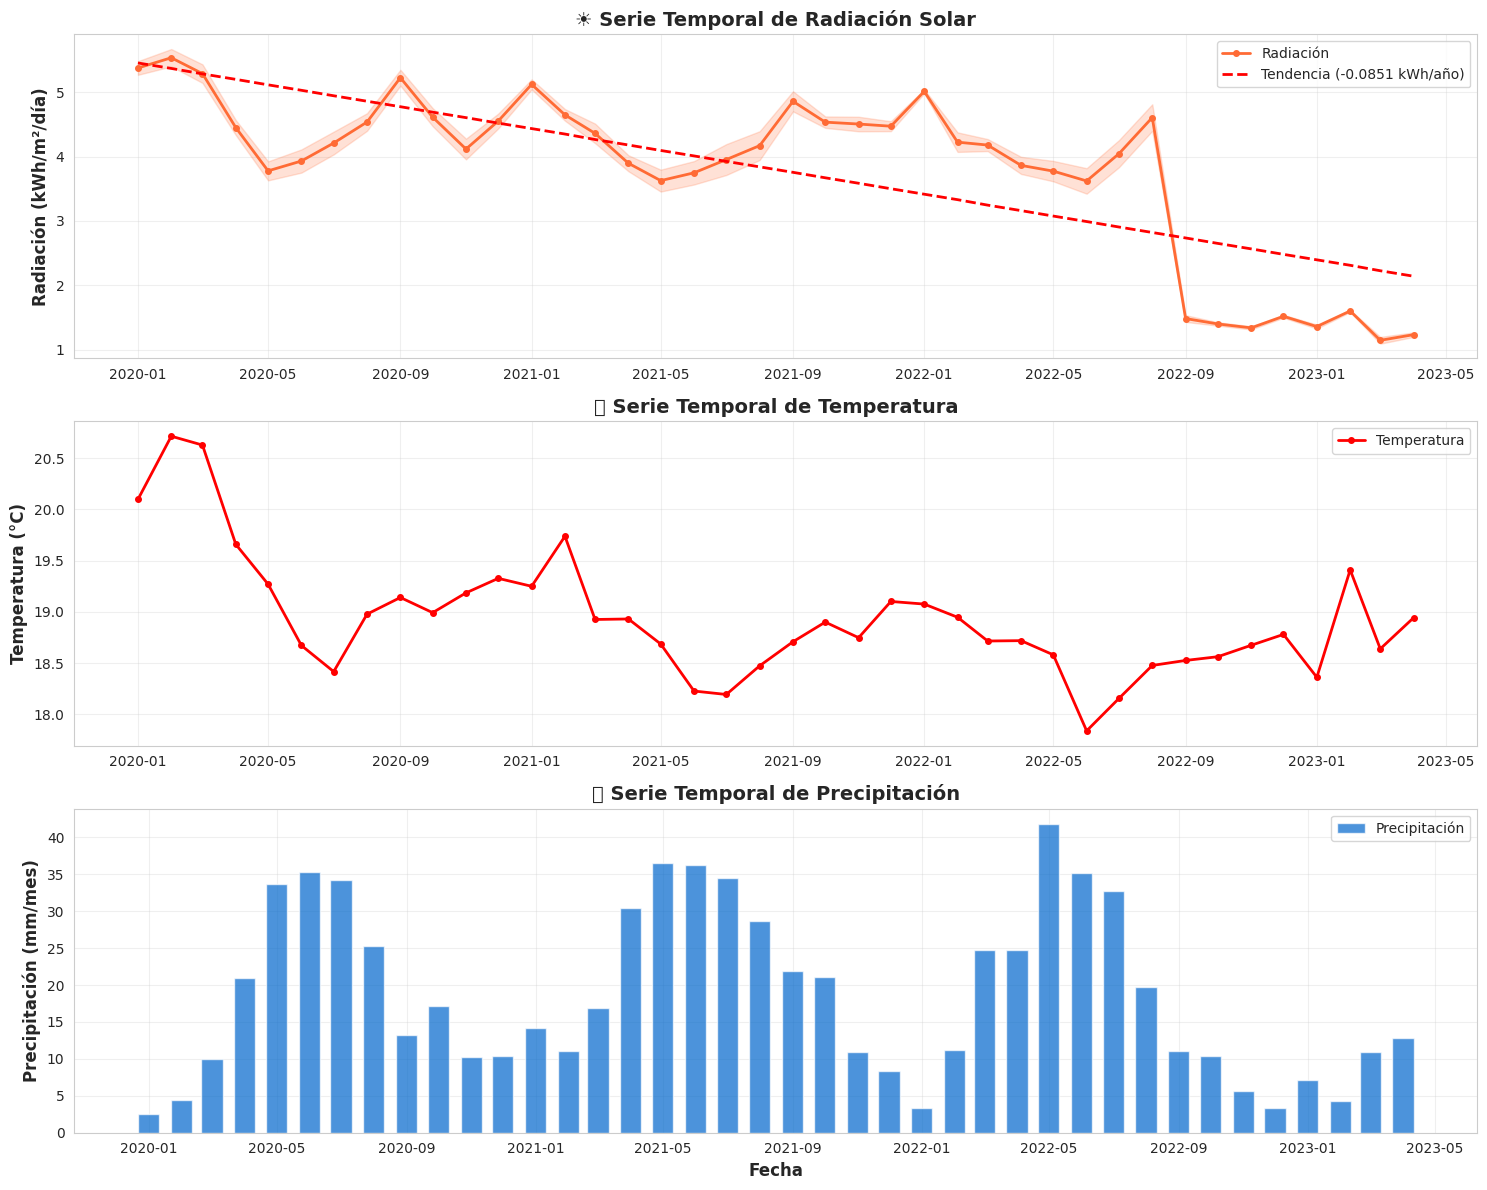

  ✓ Gráfico 2: Análisis estacional guardado


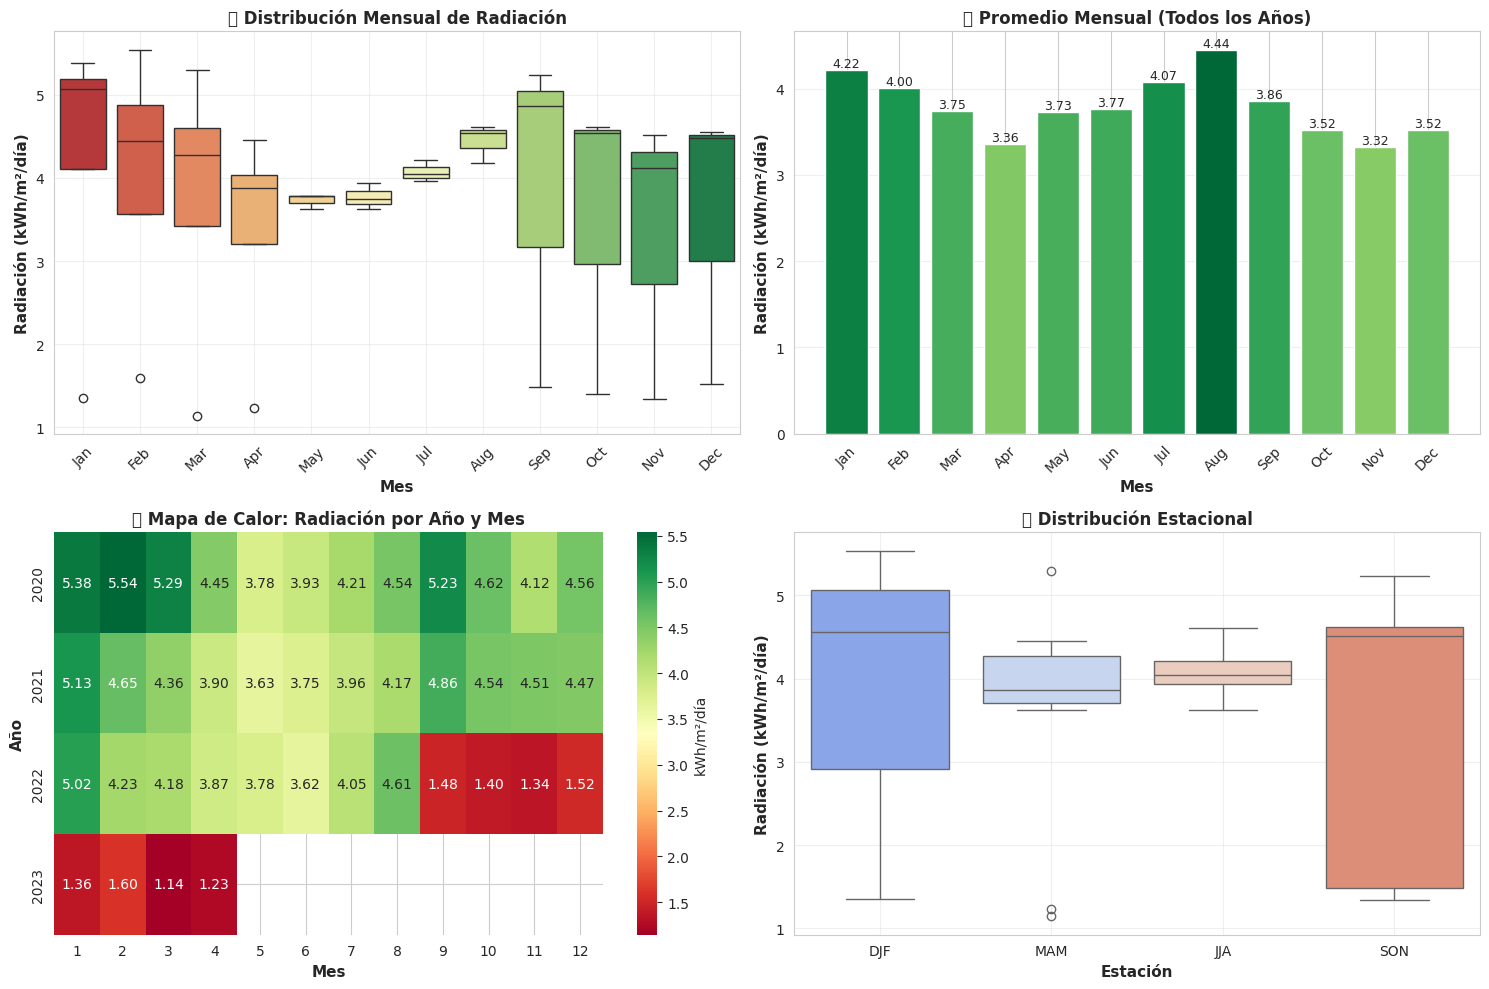

  ✓ Gráfico 3: Comparación interanual guardado


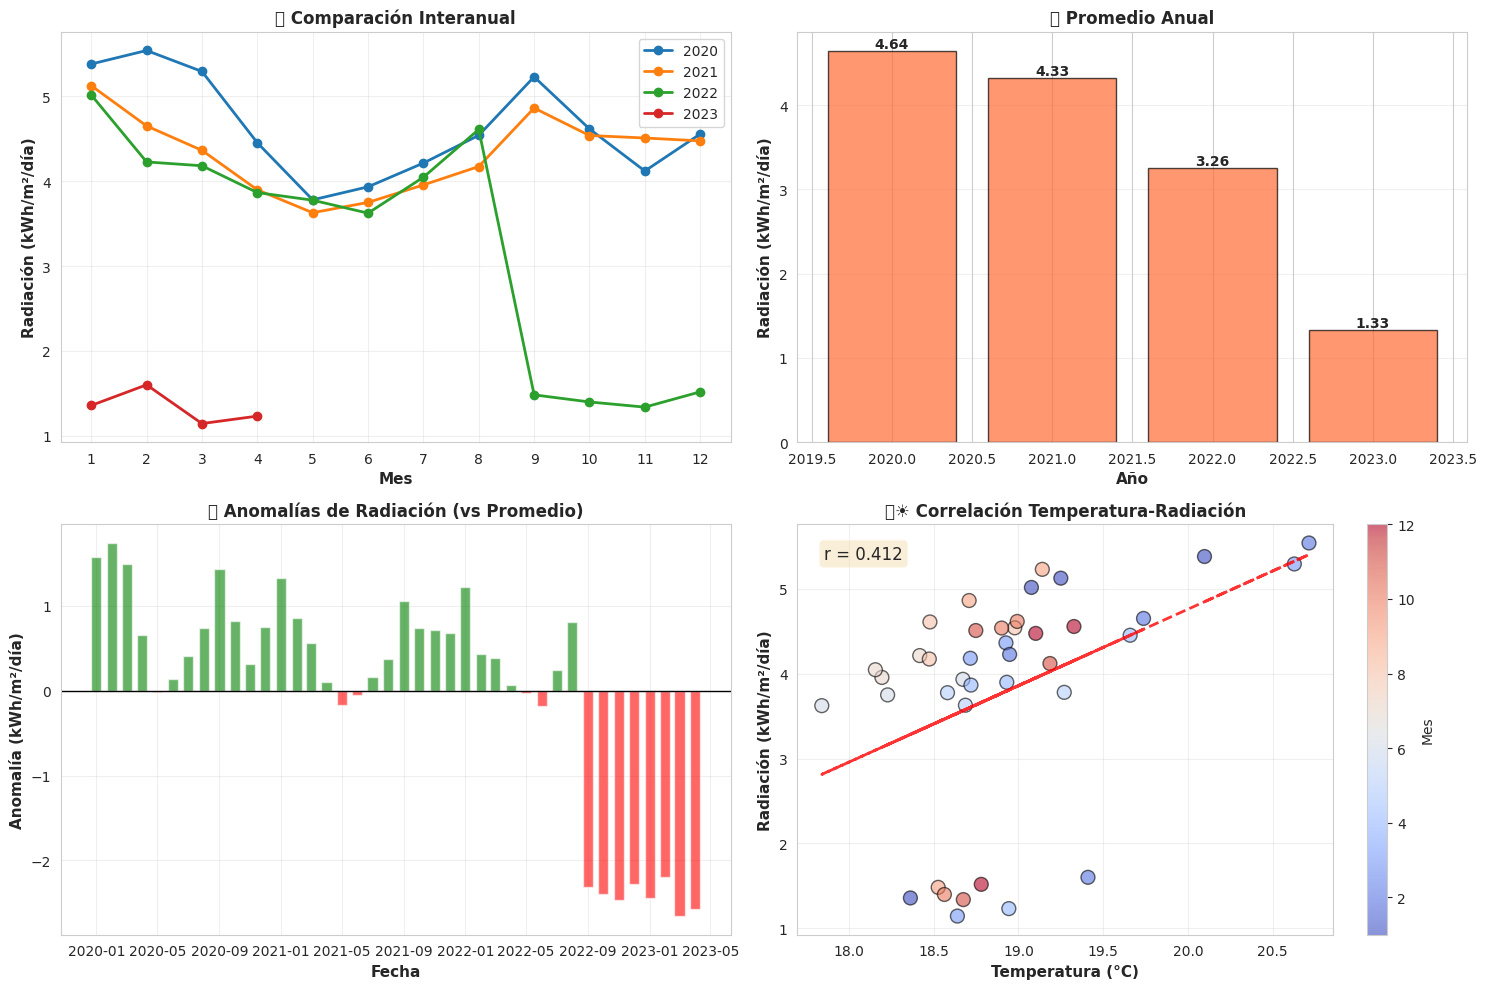

  ✓ Gráfico 4: Distribuciones guardado


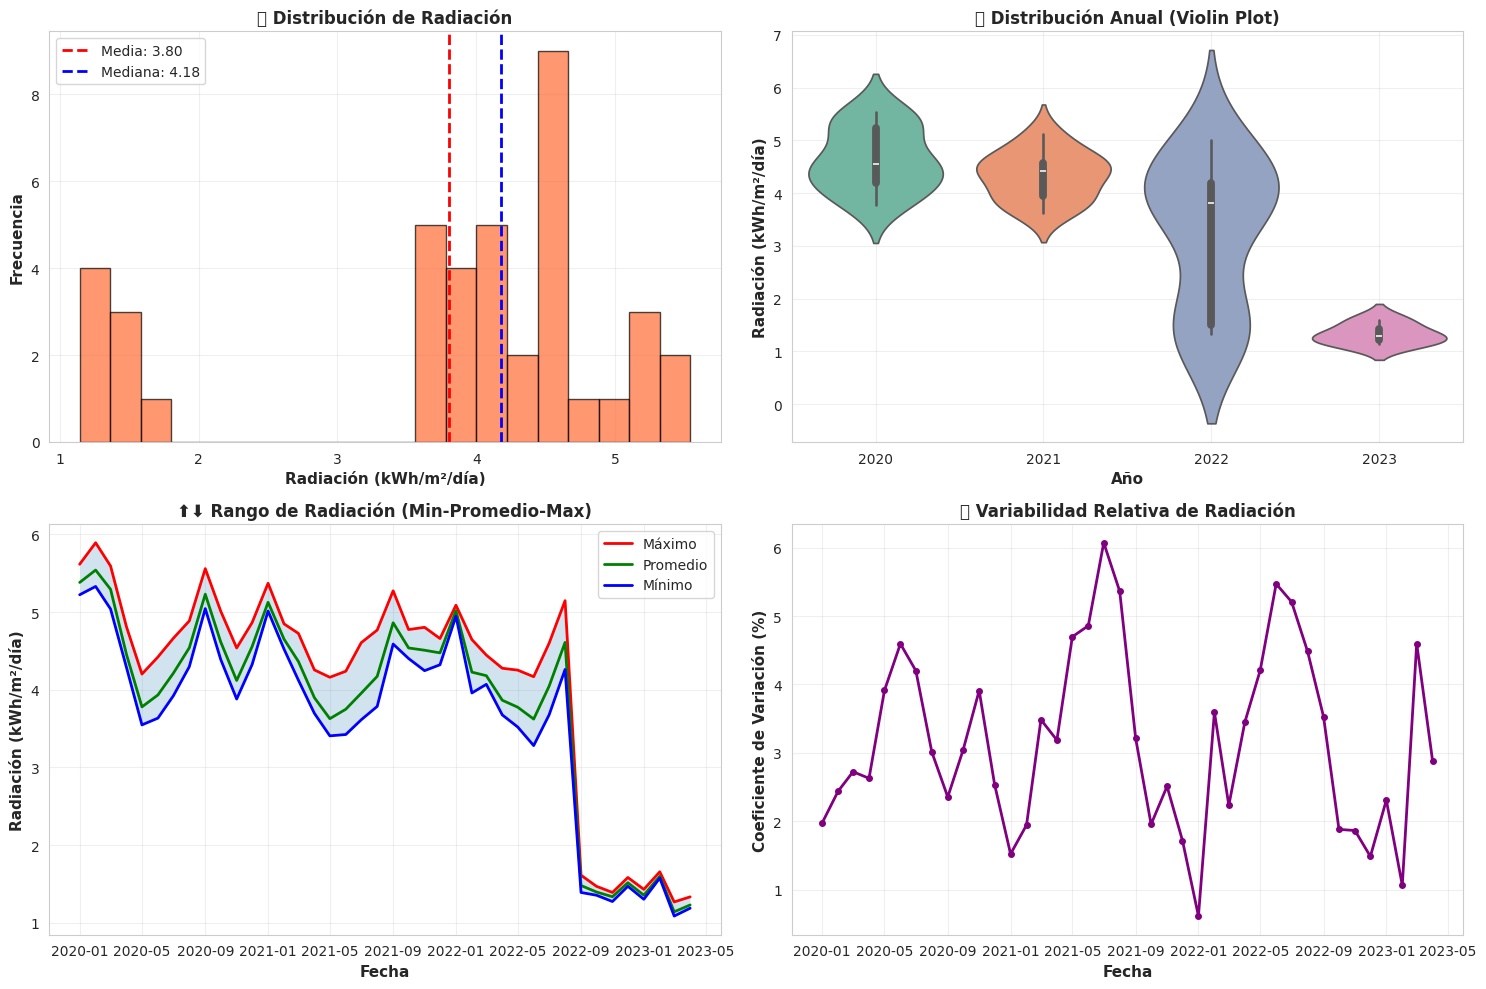


✅ Todos los gráficos generados y guardados

💾 Exportando resultados...
  ✓ CSV guardado: resultados_radiacion_solar.csv
  ✓ Estadísticas guardadas: estadisticas_resumen.txt

✅ ANÁLISIS COMPLETADO

📊 RESULTADOS CLAVE:
   • Radiación promedio: 3.80 kWh/m²/día
   • Rango: 1.14 - 5.54 kWh/m²/día
   • Desviación estándar: 1.31 kWh/m²/día
   • Mejor mes: February 2020
   • Peor mes: March 2023

📁 ARCHIVOS GENERADOS:
   • resultados_radiacion_solar.csv
   • estadisticas_resumen.txt
   • serie_temporal.png
   • analisis_estacional.png
   • comparacion_interanual.png
   • distribuciones_estadisticas.png

🗺️ MAPA INTERACTIVO:
   Ejecuta: Map



Map(center=[4.5, -74.1], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', …

In [48]:
"""
ANÁLISIS SOLAR COMPLETO - ERA5 LAND
====================================
Análisis mejorado de radiación solar con múltiples métricas y visualizaciones

Características:
- Análisis temporal (mensual, anual, estacional)
- Análisis espacial (mapas, gradientes)
- Estadísticas descriptivas
- Tendencias y anomalías
- Comparaciones interanuales
- Exportación de resultados
"""

import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("=" * 80)
print("🌞 ANÁLISIS SOLAR COMPLETO - ERA5 LAND")
print("=" * 80)
print()

# ══════════════════════════════════════════════════════════════════════════
# 1. CONFIGURACIÓN
# ══════════════════════════════════════════════════════════════════════════

CONFIG = {
    # Período de análisis
    'dateStart': '2020-01-01',
    'dateEnd': '2025-11-30',

    # Región de estudio (Colombia - Cundinamarca/Bogotá región)
    'region': ee.Geometry.Polygon([[
        [-74.8, 4.1],
        [-74.8, 4.5],
        [-74.2, 4.5],
        [-74.2, 4.1]
    ]]),

    # Centro del mapa
    'map_center': [4.5, -74.1],
    'map_zoom': 9,

    # Parámetros
    'scale': 1000,  # metros
    'maxPixels': 1e13,

    # Conversión
    'J_to_kWh': 3.6e6  # 1 kWh = 3.6e6 J
}

print("⚙️ Configuración:")
print(f"   Período: {CONFIG['dateStart']} a {CONFIG['dateEnd']}")
print(f"   Región: {CONFIG['region'].bounds().getInfo()}")
print(f"   Escala: {CONFIG['scale']} metros")
print()

# ══════════════════════════════════════════════════════════════════════════
# 2. AUTENTICACIÓN E INICIALIZACIÓN
# ══════════════════════════════════════════════════════════════════════════

print("🔐 Autenticando Earth Engine...")

try:
    ee.Initialize(project='braided-haiku-481319-h5')
    print("✅ Earth Engine inicializado")
except:
    ee.Authenticate()
    ee.Initialize(project='braided-haiku-481319-h5')
    print("✅ Earth Engine autenticado e inicializado")

print()

# ══════════════════════════════════════════════════════════════════════════
# 3. CARGA DE DATOS
# ══════════════════════════════════════════════════════════════════════════

print("📡 Cargando datos ERA5-Land...")

# Colección mensual
era5_monthly = (ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY")
    .select([
        "surface_solar_radiation_downwards",
        "temperature_2m",
        "total_precipitation"
    ])
    .filterDate(CONFIG['dateStart'], CONFIG['dateEnd'])
    .filterBounds(CONFIG['region']))

# Colección horaria (para análisis más detallado)
era5_hourly = (ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY")
    .select([
        "surface_solar_radiation_downwards",
        "temperature_2m"
    ])
    .filterDate(CONFIG['dateStart'], CONFIG['dateEnd'])
    .filterBounds(CONFIG['region']))

print(f"✅ {era5_monthly.size().getInfo()} meses cargados")
print(f"✅ {era5_hourly.size().getInfo()} horas cargadas")
print()

# ══════════════════════════════════════════════════════════════════════════
# 4. ANÁLISIS NUBOSIDAD (SENTINEL-2)
# ══════════════════════════════════════════════════════════════════════════

print("☁️ Analizando nubosidad...")

s2_clouds = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
    .filterDate(CONFIG['dateStart'], CONFIG['dateEnd'])
    .filterBounds(CONFIG['region']))

cloudiness_mean = s2_clouds.mean().clip(CONFIG['region'])

print(f"✅ Nubosidad analizada ({s2_clouds.size().getInfo()} observaciones)")
print()

# ══════════════════════════════════════════════════════════════════════════
# 5. CÁLCULOS Y PROMEDIOS
# ══════════════════════════════════════════════════════════════════════════

print("📊 Calculando métricas...")

# Promedio multianual de radiación (kWh/m²/día)
mean_radiation = (era5_monthly
    .select('surface_solar_radiation_downwards')
    .mean()
    .divide(CONFIG['J_to_kWh'])
    .clip(CONFIG['region']))

# Temperatura promedio (°C)
mean_temperature = (era5_monthly
    .select('temperature_2m')
    .mean()
    .subtract(273.15)
    .clip(CONFIG['region']))

# Precipitación total (mm)
total_precipitation = (era5_monthly
    .select('total_precipitation')
    .sum()
    .multiply(1000)
    .clip(CONFIG['region']))

# Radiación máxima y mínima
max_radiation = (era5_monthly
    .select('surface_solar_radiation_downwards')
    .max()
    .divide(CONFIG['J_to_kWh'])
    .clip(CONFIG['region']))

min_radiation = (era5_monthly
    .select('surface_solar_radiation_downwards')
    .min()
    .divide(CONFIG['J_to_kWh'])
    .clip(CONFIG['region']))

# Desviación estándar (variabilidad)
std_radiation = (era5_monthly
    .select('surface_solar_radiation_downwards')
    .reduce(ee.Reducer.stdDev())
    .divide(CONFIG['J_to_kWh'])
    .clip(CONFIG['region']))

print("✅ Métricas calculadas")
print()

# ══════════════════════════════════════════════════════════════════════════
# 6. EXTRACCIÓN DE SERIES TEMPORALES
# ══════════════════════════════════════════════════════════════════════════

print("📈 Extrayendo series temporales...")

def extract_monthly_stats(img):
    """Extrae estadísticas mensuales"""
    date = ee.Date(img.get("system:time_start"))

    # Radiación
    rad_stats = img.select('surface_solar_radiation_downwards').divide(CONFIG['J_to_kWh']).reduceRegion(
        reducer=ee.Reducer.mean().combine(ee.Reducer.minMax(), '', True).combine(ee.Reducer.stdDev(), '', True),
        geometry=CONFIG['region'],
        scale=CONFIG['scale'],
        maxPixels=CONFIG['maxPixels']
    )

    # Temperatura
    temp_stats = img.select('temperature_2m').subtract(273.15).reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=CONFIG['region'],
        scale=CONFIG['scale'],
        maxPixels=CONFIG['maxPixels']
    )

    # Precipitación
    precip_stats = img.select('total_precipitation').multiply(1000).reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=CONFIG['region'],
        scale=CONFIG['scale'],
        maxPixels=CONFIG['maxPixels']
    )

    return ee.Feature(None, {
        'date': date.format('YYYY-MM'),
        'year': date.get('year'),
        'month': date.get('month'),
        'ghi_mean': rad_stats.get('surface_solar_radiation_downwards_mean'),
        'ghi_min': rad_stats.get('surface_solar_radiation_downwards_min'),
        'ghi_max': rad_stats.get('surface_solar_radiation_downwards_max'),
        'ghi_std': rad_stats.get('surface_solar_radiation_downwards_stdDev'),
        'temp_mean': temp_stats.get('temperature_2m'),
        'precip_mean': precip_stats.get('total_precipitation')
    })

# Extraer datos
time_series = era5_monthly.map(extract_monthly_stats).filter(ee.Filter.notNull(['ghi_mean']))

# Convertir a DataFrame
features = time_series.getInfo()['features']
data = [f['properties'] for f in features]
df = pd.DataFrame(data)

# Procesar fechas
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# Agregar columnas calculadas
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['month_name'] = df['date'].dt.strftime('%b')
df['season'] = df['month'].apply(lambda x:
    'DJF' if x in [12, 1, 2] else
    'MAM' if x in [3, 4, 5] else
    'JJA' if x in [6, 7, 8] else 'SON'
)

print(f"✅ {len(df)} meses extraídos")
print()

# ══════════════════════════════════════════════════════════════════════════
# 7. ESTADÍSTICAS DESCRIPTIVAS
# ══════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("📊 ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 80)
print()

print("Radiación Solar (kWh/m²/día):")
print(df['ghi_mean'].describe())
print()

print("Temperatura (°C):")
print(df['temp_mean'].describe())
print()

print("Precipitación (mm/mes):")
print(df['precip_mean'].describe())
print()

# Estadísticas por año
print("Promedio Anual de Radiación:")
yearly_stats = df.groupby('year')['ghi_mean'].agg(['mean', 'min', 'max', 'std'])
print(yearly_stats)
print()

# Estadísticas por mes
print("Promedio Mensual (todos los años):")
monthly_stats = df.groupby('month_name')['ghi_mean'].agg(['mean', 'std'])
monthly_stats = monthly_stats.reindex(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
print(monthly_stats)
print()

# ══════════════════════════════════════════════════════════════════════════
# 8. CREAR MAPA INTERACTIVO
# ══════════════════════════════════════════════════════════════════════════

print("🗺️ Creando mapa interactivo...")

Map = geemap.Map(center=CONFIG['map_center'], zoom=CONFIG['map_zoom'])

# Capa base
Map.add_basemap('HYBRID')

# Radiación promedio
vis_radiation = {
    'min': 3,
    'max': 7,
    'palette': ['#000080', '#0000FF', '#00FFFF', '#FFFF00', '#FF9900', '#FF0000', '#800000']
}

Map.addLayer(mean_radiation, vis_radiation, '☀️ Radiación Promedio (kWh/m²/día)', True)

# Temperatura
vis_temp = {
    'min': 10,
    'max': 25,
    'palette': ['#0000FF', '#00FFFF', '#00FF00', '#FFFF00', '#FF0000']
}

Map.addLayer(mean_temperature, vis_temp, '🌡️ Temperatura Promedio (°C)', False)

# Nubosidad
vis_clouds = {
    'min': 0,
    'max': 100,
    'palette': ['#00FF00', '#FFFF00', '#FFA500', '#FF0000']
}

Map.addLayer(cloudiness_mean, vis_clouds, '☁️ Nubosidad Promedio (%)', False)

# Variabilidad
vis_std = {
    'min': 0,
    'max': 2,
    'palette': ['#00FF00', '#FFFF00', '#FF0000']
}

Map.addLayer(std_radiation, vis_std, '📊 Variabilidad (Desv. Est.)', False)

# Máximos y mínimos
Map.addLayer(max_radiation, vis_radiation, '⬆️ Radiación Máxima', False)
Map.addLayer(min_radiation, vis_radiation, '⬇️ Radiación Mínima', False)

# Región de estudio
Map.addLayer(CONFIG['region'], {'color': 'red'}, '📍 Área de Estudio', True)

# Agregar leyenda
legend_dict = {
    '3.0': '#000080',
    '4.0': '#0000FF',
    '5.0': '#00FFFF',
    '5.5': '#FFFF00',
    '6.0': '#FF9900',
    '6.5': '#FF0000',
    '7.0': '#800000'
}

Map.add_legend(legend_title='Radiación (kWh/m²/día)', legend_dict=legend_dict)

print("✅ Mapa creado")
print()

# ══════════════════════════════════════════════════════════════════════════
# 9. VISUALIZACIONES AVANZADAS
# ══════════════════════════════════════════════════════════════════════════

print("📊 Generando gráficos...")

# ─────────────────────────────────────────────────────────────────────────
# Gráfico 1: Serie temporal con tendencia
# ─────────────────────────────────────────────────────────────────────────

fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Radiación
ax1 = axes[0]
ax1.plot(df['date'], df['ghi_mean'], 'o-', linewidth=2, markersize=4, label='Radiación', color='#FF6B35')
ax1.fill_between(df['date'],
                 df['ghi_mean'] - df['ghi_std'],
                 df['ghi_mean'] + df['ghi_std'],
                 alpha=0.2, color='#FF6B35')

# Tendencia
z = np.polyfit(range(len(df)), df['ghi_mean'], 1)
p = np.poly1d(z)
ax1.plot(df['date'], p(range(len(df))), '--', linewidth=2, color='red',
         label=f'Tendencia ({z[0]:.4f} kWh/año)')

ax1.set_ylabel('Radiación (kWh/m²/día)', fontsize=12, fontweight='bold')
ax1.set_title('☀️ Serie Temporal de Radiación Solar', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Temperatura
ax2 = axes[1]
ax2.plot(df['date'], df['temp_mean'], 'o-', linewidth=2, markersize=4, label='Temperatura', color='#FF0000')
ax2.set_ylabel('Temperatura (°C)', fontsize=12, fontweight='bold')
ax2.set_title('🌡️ Serie Temporal de Temperatura', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Precipitación
ax3 = axes[2]
ax3.bar(df['date'], df['precip_mean'], width=20, label='Precipitación', color='#0066CC', alpha=0.7)
ax3.set_ylabel('Precipitación (mm/mes)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax3.set_title('🌧️ Serie Temporal de Precipitación', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('serie_temporal.png', dpi=300, bbox_inches='tight')
print("  ✓ Gráfico 1: Serie temporal guardado")
plt.show()

# ─────────────────────────────────────────────────────────────────────────
# Gráfico 2: Análisis estacional
# ─────────────────────────────────────────────────────────────────────────

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Box plot por mes
ax1 = axes[0, 0]
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sns.boxplot(data=df, x='month_name', y='ghi_mean', order=month_order, ax=ax1, palette='RdYlGn')
ax1.set_xlabel('Mes', fontsize=11, fontweight='bold')
ax1.set_ylabel('Radiación (kWh/m²/día)', fontsize=11, fontweight='bold')
ax1.set_title('📦 Distribución Mensual de Radiación', fontsize=12, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(alpha=0.3)

# Promedio por mes (barras)
ax2 = axes[0, 1]
monthly_avg = df.groupby('month_name')['ghi_mean'].mean().reindex(month_order)
bars = ax2.bar(range(12), monthly_avg.values, color=plt.cm.RdYlGn(monthly_avg.values / monthly_avg.max()))
ax2.set_xticks(range(12))
ax2.set_xticklabels(month_order, rotation=45)
ax2.set_xlabel('Mes', fontsize=11, fontweight='bold')
ax2.set_ylabel('Radiación (kWh/m²/día)', fontsize=11, fontweight='bold')
ax2.set_title('📊 Promedio Mensual (Todos los Años)', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

# Valores en las barras
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=9)

# Heatmap por año y mes
ax3 = axes[1, 0]
pivot = df.pivot_table(values='ghi_mean', index='year', columns='month', aggfunc='mean')
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax3, cbar_kws={'label': 'kWh/m²/día'})
ax3.set_xlabel('Mes', fontsize=11, fontweight='bold')
ax3.set_ylabel('Año', fontsize=11, fontweight='bold')
ax3.set_title('🔥 Mapa de Calor: Radiación por Año y Mes', fontsize=12, fontweight='bold')

# Box plot por estación
ax4 = axes[1, 1]
season_order = ['DJF', 'MAM', 'JJA', 'SON']
sns.boxplot(data=df, x='season', y='ghi_mean', order=season_order, ax=ax4, palette='coolwarm')
ax4.set_xlabel('Estación', fontsize=11, fontweight='bold')
ax4.set_ylabel('Radiación (kWh/m²/día)', fontsize=11, fontweight='bold')
ax4.set_title('🌍 Distribución Estacional', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('analisis_estacional.png', dpi=300, bbox_inches='tight')
print("  ✓ Gráfico 2: Análisis estacional guardado")
plt.show()

# ─────────────────────────────────────────────────────────────────────────
# Gráfico 3: Comparación interanual
# ─────────────────────────────────────────────────────────────────────────

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Serie por año
ax1 = axes[0, 0]
for year in df['year'].unique():
    year_data = df[df['year'] == year]
    ax1.plot(year_data['month'], year_data['ghi_mean'], 'o-', label=str(year), linewidth=2, markersize=6)

ax1.set_xlabel('Mes', fontsize=11, fontweight='bold')
ax1.set_ylabel('Radiación (kWh/m²/día)', fontsize=11, fontweight='bold')
ax1.set_title('📈 Comparación Interanual', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)
ax1.set_xticks(range(1, 13))

# Promedio anual
ax2 = axes[0, 1]
annual_avg = df.groupby('year')['ghi_mean'].mean()
bars = ax2.bar(annual_avg.index, annual_avg.values, color='#FF6B35', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Año', fontsize=11, fontweight='bold')
ax2.set_ylabel('Radiación (kWh/m²/día)', fontsize=11, fontweight='bold')
ax2.set_title('📊 Promedio Anual', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Anomalías (diferencia respecto al promedio)
ax3 = axes[1, 0]
df['anomaly'] = df['ghi_mean'] - df['ghi_mean'].mean()
colors = ['red' if x < 0 else 'green' for x in df['anomaly']]
ax3.bar(df['date'], df['anomaly'], color=colors, alpha=0.6, width=20)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax3.set_xlabel('Fecha', fontsize=11, fontweight='bold')
ax3.set_ylabel('Anomalía (kWh/m²/día)', fontsize=11, fontweight='bold')
ax3.set_title('📊 Anomalías de Radiación (vs Promedio)', fontsize=12, fontweight='bold')
ax3.grid(alpha=0.3)

# Correlación temperatura-radiación
ax4 = axes[1, 1]
scatter = ax4.scatter(df['temp_mean'], df['ghi_mean'], c=df['month'],
                      cmap='coolwarm', s=100, alpha=0.6, edgecolors='black')
ax4.set_xlabel('Temperatura (°C)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Radiación (kWh/m²/día)', fontsize=11, fontweight='bold')
ax4.set_title('🌡️☀️ Correlación Temperatura-Radiación', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)

# Línea de tendencia
z = np.polyfit(df['temp_mean'], df['ghi_mean'], 1)
p = np.poly1d(z)
ax4.plot(df['temp_mean'], p(df['temp_mean']), "r--", linewidth=2, alpha=0.8)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Mes', fontsize=10)

# Correlación
correlation = df['temp_mean'].corr(df['ghi_mean'])
ax4.text(0.05, 0.95, f'r = {correlation:.3f}', transform=ax4.transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('comparacion_interanual.png', dpi=300, bbox_inches='tight')
print("  ✓ Gráfico 3: Comparación interanual guardado")
plt.show()

# ─────────────────────────────────────────────────────────────────────────
# Gráfico 4: Distribuciones y estadísticas
# ─────────────────────────────────────────────────────────────────────────

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histograma de radiación
ax1 = axes[0, 0]
ax1.hist(df['ghi_mean'], bins=20, color='#FF6B35', alpha=0.7, edgecolor='black')
ax1.axvline(df['ghi_mean'].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {df["ghi_mean"].mean():.2f}')
ax1.axvline(df['ghi_mean'].median(), color='blue', linestyle='--', linewidth=2, label=f'Mediana: {df["ghi_mean"].median():.2f}')
ax1.set_xlabel('Radiación (kWh/m²/día)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
ax1.set_title('📊 Distribución de Radiación', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Violin plot por año
ax2 = axes[0, 1]
sns.violinplot(data=df, x='year', y='ghi_mean', ax=ax2, palette='Set2')
ax2.set_xlabel('Año', fontsize=11, fontweight='bold')
ax2.set_ylabel('Radiación (kWh/m²/día)', fontsize=11, fontweight='bold')
ax2.set_title('🎻 Distribución Anual (Violin Plot)', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3)

# Radiación min vs max
ax3 = axes[1, 0]
ax3.plot(df['date'], df['ghi_max'], 'r-', label='Máximo', linewidth=2)
ax3.plot(df['date'], df['ghi_mean'], 'g-', label='Promedio', linewidth=2)
ax3.plot(df['date'], df['ghi_min'], 'b-', label='Mínimo', linewidth=2)
ax3.fill_between(df['date'], df['ghi_min'], df['ghi_max'], alpha=0.2)
ax3.set_xlabel('Fecha', fontsize=11, fontweight='bold')
ax3.set_ylabel('Radiación (kWh/m²/día)', fontsize=11, fontweight='bold')
ax3.set_title('⬆️⬇️ Rango de Radiación (Min-Promedio-Max)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# Coeficiente de variación
ax4 = axes[1, 1]
df['cv'] = (df['ghi_std'] / df['ghi_mean']) * 100  # Coeficiente de variación (%)
ax4.plot(df['date'], df['cv'], 'o-', color='purple', linewidth=2, markersize=4)
ax4.set_xlabel('Fecha', fontsize=11, fontweight='bold')
ax4.set_ylabel('Coeficiente de Variación (%)', fontsize=11, fontweight='bold')
ax4.set_title('📉 Variabilidad Relativa de Radiación', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('distribuciones_estadisticas.png', dpi=300, bbox_inches='tight')
print("  ✓ Gráfico 4: Distribuciones guardado")
plt.show()

print()
print("✅ Todos los gráficos generados y guardados")
print()

# ══════════════════════════════════════════════════════════════════════════
# 10. EXPORTAR RESULTADOS
# ══════════════════════════════════════════════════════════════════════════

print("💾 Exportando resultados...")

# Guardar DataFrame
df.to_csv('resultados_radiacion_solar.csv', index=False)
print("  ✓ CSV guardado: resultados_radiacion_solar.csv")

# Guardar estadísticas resumen
with open('estadisticas_resumen.txt', 'w', encoding='utf-8') as f:
    f.write("=" * 80 + "\n")
    f.write("RESUMEN ESTADÍSTICO - ANÁLISIS DE RADIACIÓN SOLAR\n")
    f.write("=" * 80 + "\n\n")

    f.write(f"Período: {CONFIG['dateStart']} a {CONFIG['dateEnd']}\n")
    f.write(f"Región: {CONFIG['region'].bounds().getInfo()}\n\n")

    f.write("RADIACIÓN SOLAR (kWh/m²/día):\n")
    f.write("-" * 40 + "\n")
    f.write(df['ghi_mean'].describe().to_string())
    f.write("\n\n")

    f.write("PROMEDIO POR AÑO:\n")
    f.write("-" * 40 + "\n")
    f.write(yearly_stats.to_string())
    f.write("\n\n")

    f.write("PROMEDIO POR MES:\n")
    f.write("-" * 40 + "\n")
    f.write(monthly_stats.to_string())
    f.write("\n\n")

    f.write("CORRELACIONES:\n")
    f.write("-" * 40 + "\n")
    f.write(f"Temperatura-Radiación: {df['temp_mean'].corr(df['ghi_mean']):.3f}\n")
    f.write(f"Precipitación-Radiación: {df['precip_mean'].corr(df['ghi_mean']):.3f}\n")

print("  ✓ Estadísticas guardadas: estadisticas_resumen.txt")
print()

# ══════════════════════════════════════════════════════════════════════════
# 11. RESUMEN FINAL
# ══════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("✅ ANÁLISIS COMPLETADO")
print("=" * 80)
print()
print("📊 RESULTADOS CLAVE:")
print(f"   • Radiación promedio: {df['ghi_mean'].mean():.2f} kWh/m²/día")
print(f"   • Rango: {df['ghi_mean'].min():.2f} - {df['ghi_mean'].max():.2f} kWh/m²/día")
print(f"   • Desviación estándar: {df['ghi_mean'].std():.2f} kWh/m²/día")
print(f"   • Mejor mes: {df.loc[df['ghi_mean'].idxmax(), 'date'].strftime('%B %Y')}")
print(f"   • Peor mes: {df.loc[df['ghi_mean'].idxmin(), 'date'].strftime('%B %Y')}")
print()
print("📁 ARCHIVOS GENERADOS:")
print("   • resultados_radiacion_solar.csv")
print("   • estadisticas_resumen.txt")
print("   • serie_temporal.png")
print("   • analisis_estacional.png")
print("   • comparacion_interanual.png")
print("   • distribuciones_estadisticas.png")
print()
print("🗺️ MAPA INTERACTIVO:")
print("   Ejecuta: Map")
print()
print("=" * 80)

# Mostrar mapa
Map

In [46]:
def extract_monthly_ghi(image):
    """

SyntaxError: incomplete input (ipython-input-1407156583.py, line 2)

🤖 MACHINE LEARNING: NDVI vs RADIACIÓN SOLAR

⚙️ Configuración:
   Período: 2023-01-01 a 2023-12-31
   Región: {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[-74.8, 4.099999999999974], [-74.2, 4.099999999999974], [-74.2, 4.500061432367398], [-74.8, 4.500061432367398], [-74.8, 4.099999999999974]]]}
   Muestras: 2000 puntos
   Test size: 20.0%

🔐 Inicializando Earth Engine...
✅ Earth Engine inicializado

📡 Extrayendo datos de Earth Engine...

  ☀️ Cargando radiación solar (ERA5-Land Hourly)...
     ✓ 8736 imágenes horarias procesadas
  🌿 Cargando NDVI (Sentinel-2)...
     ✓ 3 imágenes Sentinel-2 procesadas
  📊 Cargando variables adicionales...
     ✓ Temperatura, elevación, pendiente, nubosidad

  🔗 Combinando variables...
     ✓ 6 variables combinadas

  📍 Muestreando 2000 puntos...
     ✓ Muestreo completado

  ⏳ Descargando datos a Python (puede tardar 1-2 minutos)...
     ✓ 1965 puntos descargados

  🧹 Datos limpios: 1965 puntos (removidos 0 NaN)

✅ Extracción de datos compl

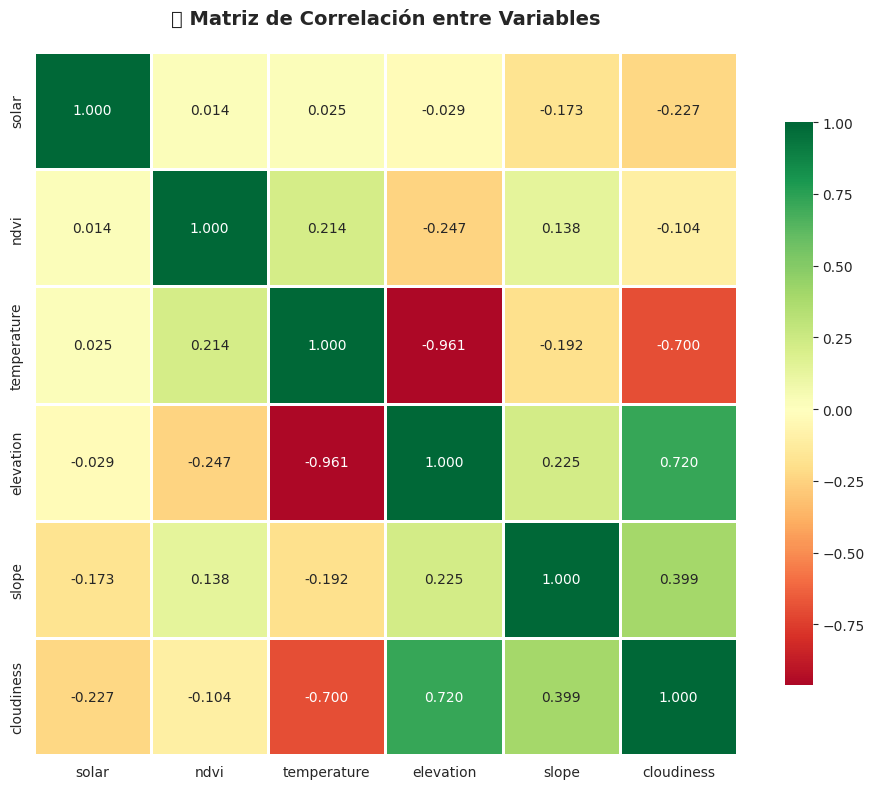

  ✓ Gráfico guardado: scatter_plots_exploratorio.png


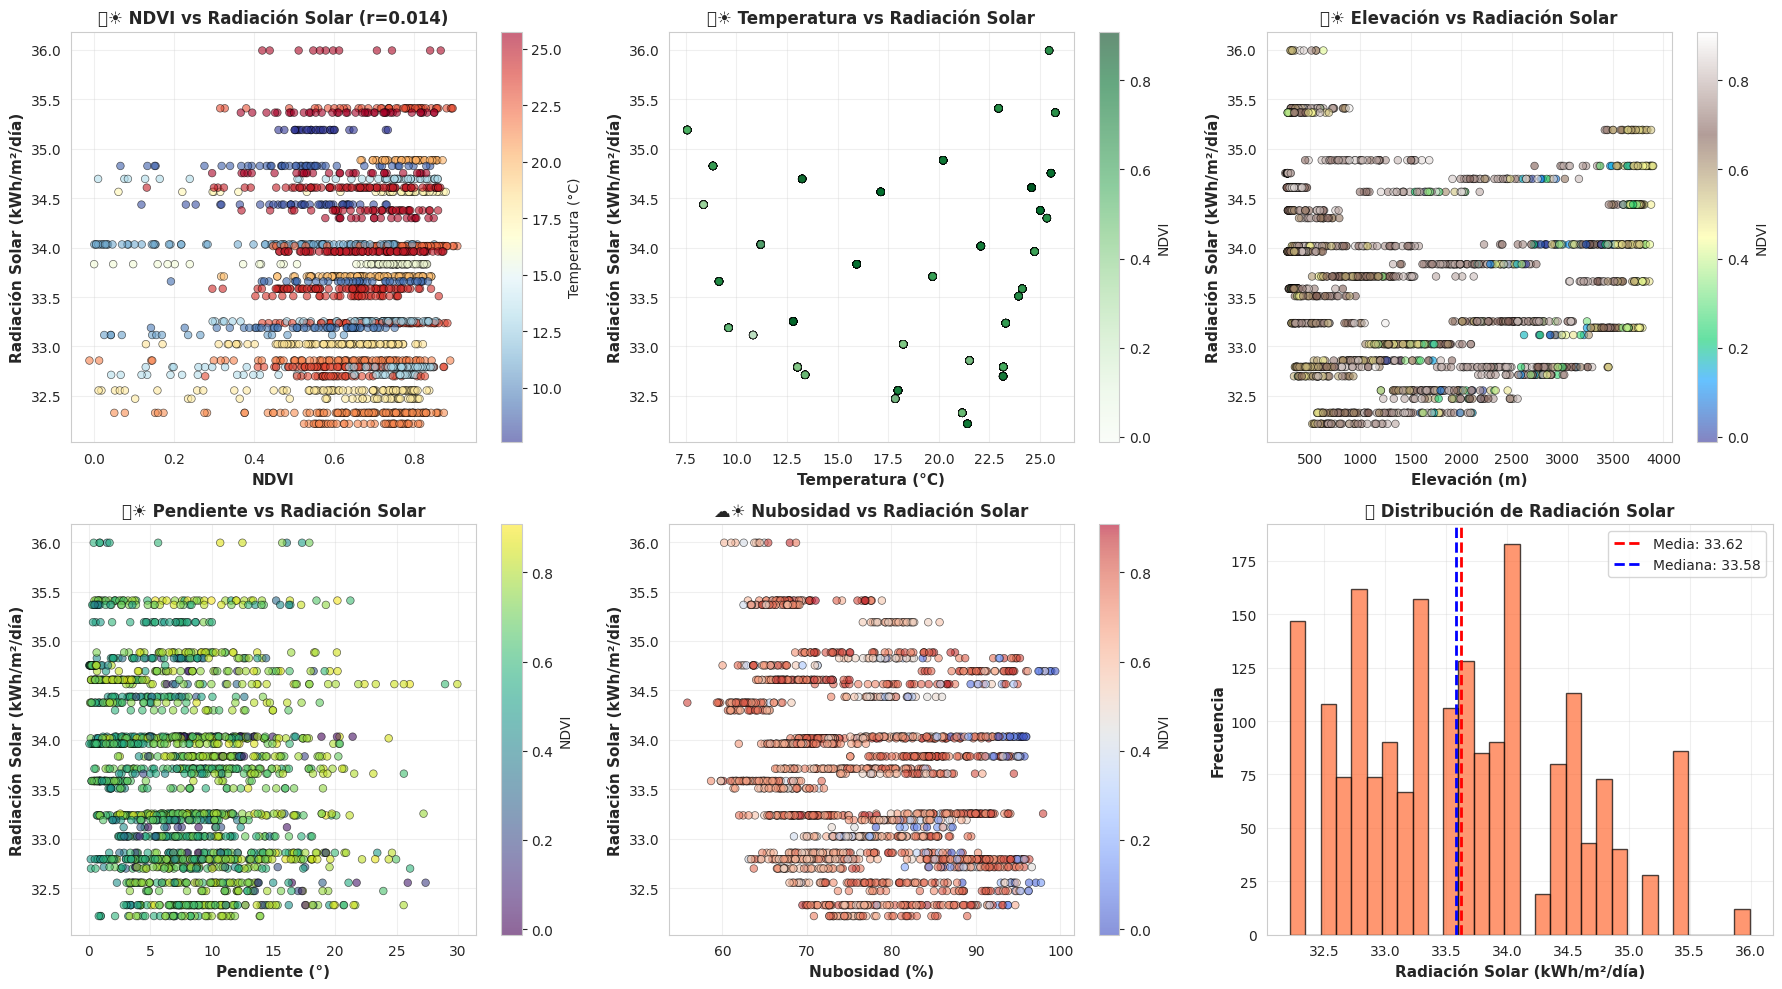


🤖 PREPARACIÓN DE DATOS PARA MACHINE LEARNING

📊 Features (X): (1965, 5)
🎯 Target (y): (1965,)

✓ Train set: 1572 muestras
✓ Test set: 393 muestras

✓ Datos normalizados (StandardScaler)

🎓 ENTRENAMIENTO DE MODELOS DE MACHINE LEARNING

1️⃣ Regresión Lineal Simple...
   R² Score: 0.0832
   RMSE: 0.8559
   MAE: 0.7298

2️⃣ Regresión Polinomial (grado 2)...
   R² Score: 0.3212
   RMSE: 0.7364
   MAE: 0.5942

3️⃣ Random Forest Regressor...
   R² Score: 0.9991
   RMSE: 0.0275
   MAE: 0.0072

   📊 Feature Importance:
      ndvi: 0.0158
      temperature: 0.9728
      elevation: 0.0074
      slope: 0.0008
      cloudiness: 0.0032

4️⃣ Gradient Boosting Regressor...
   R² Score: 0.9991
   RMSE: 0.0269
   MAE: 0.0138

5️⃣ XGBoost Regressor...
   R² Score: 0.9977
   RMSE: 0.0427
   MAE: 0.0202

📊 COMPARACIÓN DE MODELOS

               Modelo  R² Score     RMSE      MAE
    Gradient Boosting  0.999093 0.026924 0.013834
        Random Forest  0.999052 0.027524 0.007210
              XGBoost  0.997

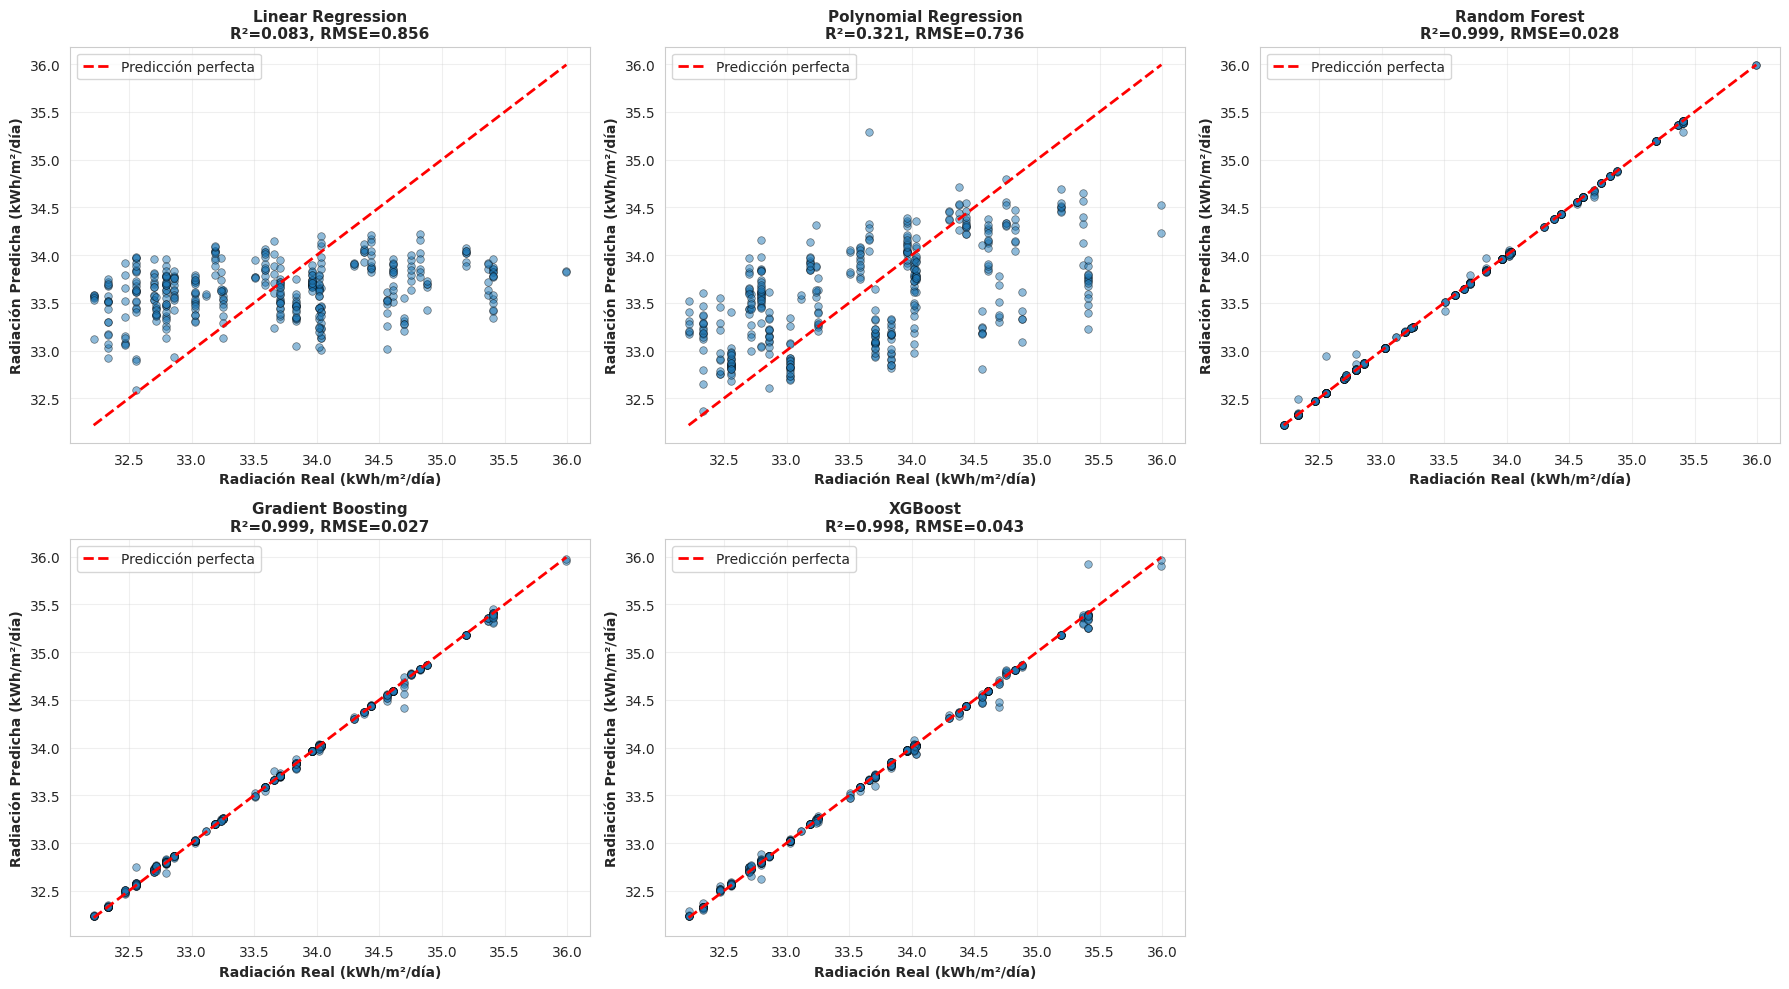

  ✓ Gráfico guardado: metricas_comparativas.png


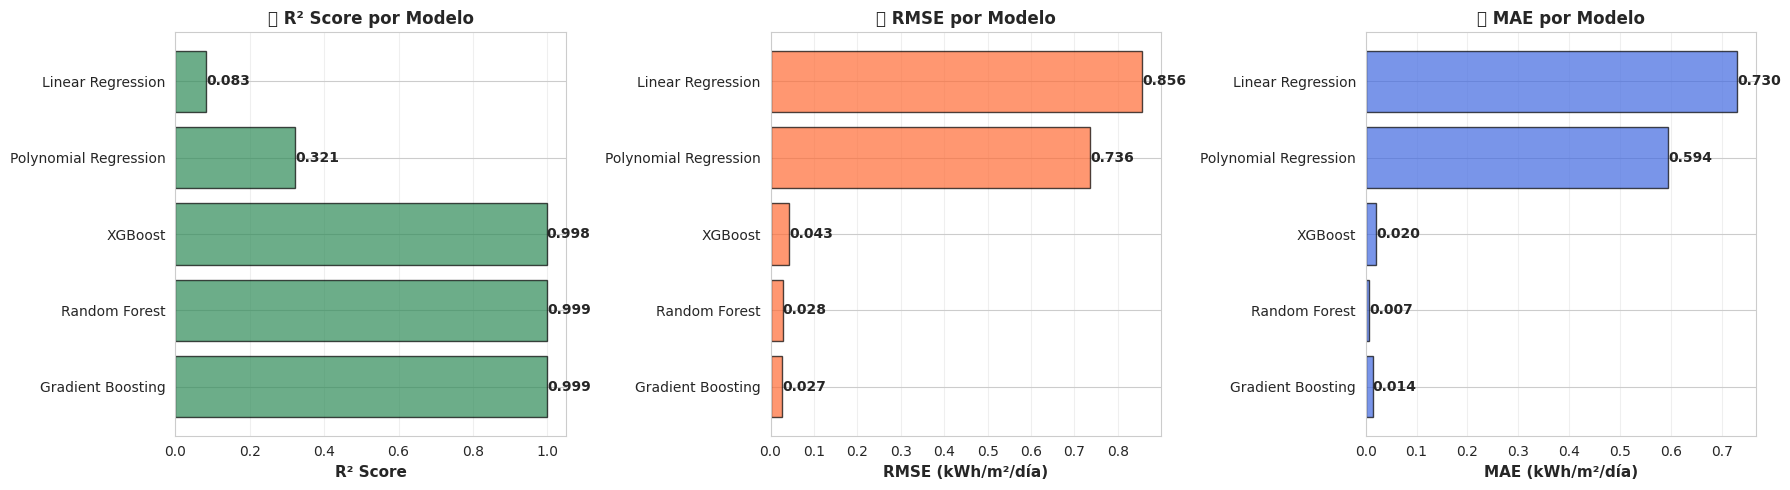


📊 IMPORTANCIA DE FEATURES

  ✓ Gráfico guardado: feature_importance.png


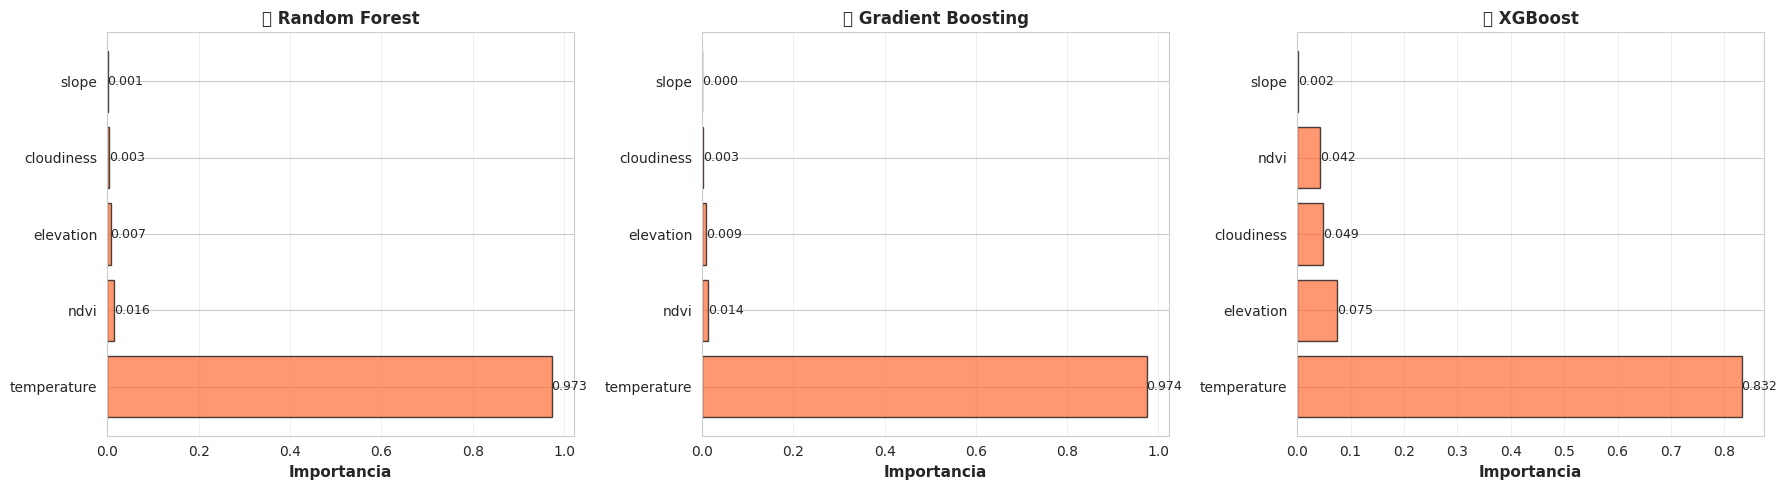


🎯 CLUSTERING: CLASIFICACIÓN DE ZONAS

  🔍 Aplicando K-Means clustering (3 clusters)...

  📊 Distribución de clusters:
cluster_label
Bajo     879
Medio    611
Alto     475
Name: count, dtype: int64

  📈 Estadísticas por cluster:

                   solar                                      ndvi            \
                    mean       std        min        max      mean       std   
cluster_label                                                                  
Alto           34.841112  0.380601  34.375891  35.993391  0.643838  0.171819   
Bajo           32.808958  0.322594  32.217762  33.253457  0.636662  0.169863   
Medio          33.846962  0.192543  33.509173  34.298229  0.645879  0.177188   

                                   
                    min       max  
cluster_label                      
Alto           0.009319  0.896255  
Bajo          -0.012330  0.890238  
Medio         -0.000558  0.908095  

  ✓ Gráfico guardado: clustering_zonas.png


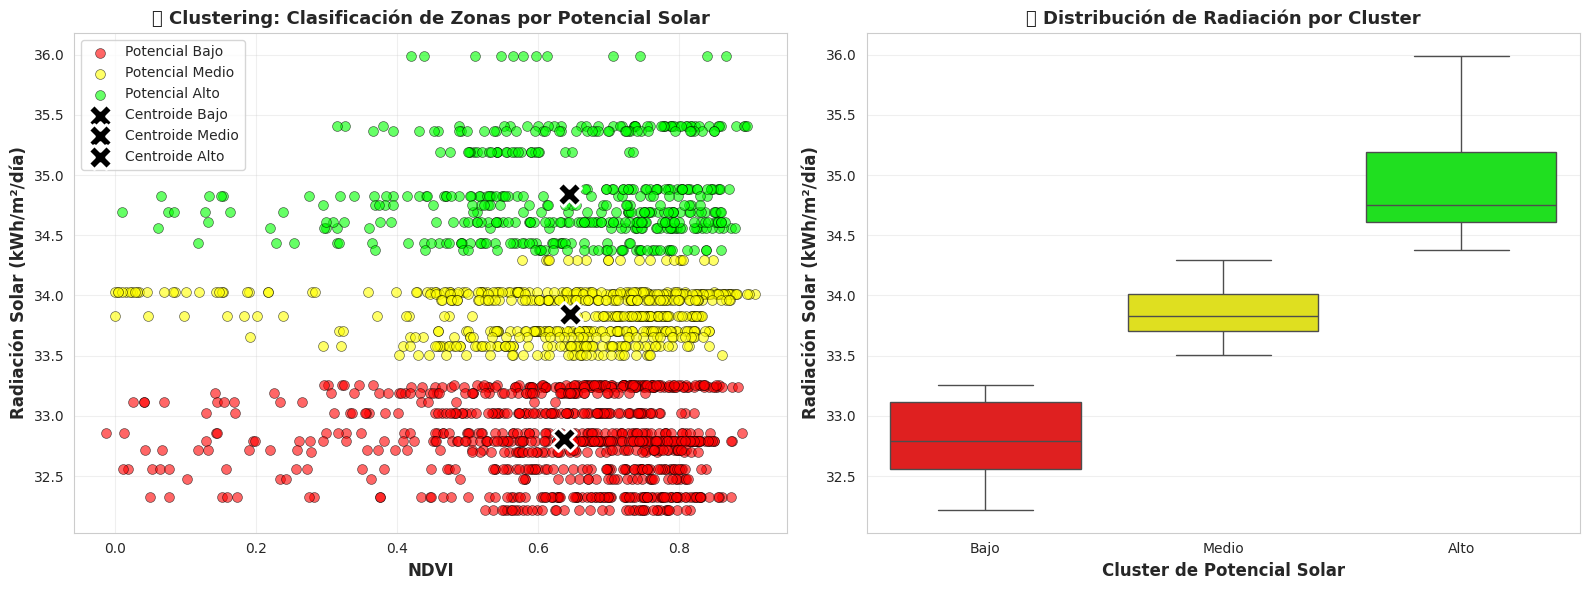


🗺️ CREANDO MAPA DE PREDICCIONES

✅ Mapa creado con capas de datos reales

💾 EXPORTANDO RESULTADOS

  ✓ CSV guardado: ml_resultados_completos.csv
  ✓ CSV guardado: ml_comparacion_modelos.csv
  ✓ Reporte guardado: ml_reporte.txt

✅ ANÁLISIS DE MACHINE LEARNING COMPLETADO

📊 RESUMEN DE RESULTADOS:

   🔗 Correlación NDVI-Solar: 0.0142
   🏆 Mejor modelo: Gradient Boosting
   📈 R² Score: 0.9991
   📉 RMSE: 0.0269 kWh/m²/día
   📊 MAE: 0.0138 kWh/m²/día

🎯 CLUSTERING:
   • Zonas de bajo potencial: 879
   • Zonas de medio potencial: 611
   • Zonas de alto potencial: 475

📁 ARCHIVOS GENERADOS:
   • correlacion_matrix.png
   • scatter_plots_exploratorio.png
   • comparacion_modelos.png
   • metricas_comparativas.png
   • feature_importance.png
   • clustering_zonas.png
   • ml_resultados_completos.csv
   • ml_comparacion_modelos.csv
   • ml_reporte.txt

🗺️ MAPA INTERACTIVO:
   Ejecuta: Map



Map(center=[4.3, -74.5], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', …

In [51]:
"""
MACHINE LEARNING: ANÁLISIS NDVI vs RADIACIÓN SOLAR
===================================================

Análisis completo con múltiples modelos de ML para:
- Predecir radiación solar basándose en NDVI
- Identificar patrones y correlaciones
- Clasificar zonas según su potencial solar
- Generar mapas predictivos

Modelos implementados:
- Regresión Lineal
- Regresión Polinomial
- Random Forest
- Gradient Boosting
- XGBoost
- Redes Neuronales (opcional)
"""

import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.cluster import KMeans
import xgboost as xgb

# Configurar estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("=" * 80)
print("🤖 MACHINE LEARNING: NDVI vs RADIACIÓN SOLAR")
print("=" * 80)
print()

# ══════════════════════════════════════════════════════════════════════════
# 1. CONFIGURACIÓN
# ══════════════════════════════════════════════════════════════════════════

CONFIG = {
    # Período
    'dateStart': '2023-01-01',
    'dateEnd': '2023-12-31',

    # Región (Colombia - Cundinamarca)
    # Sintaxis correcta: [lon_min, lat_min, lon_max, lat_max]
    'region': ee.Geometry.Rectangle([-74.8, 4.1, -74.2, 4.5]),

    # Parámetros de muestreo
    'scale': 500,  # metros (mayor para más velocidad)
    'numPixels': 2000,  # número de puntos a muestrear

    # Machine Learning
    'test_size': 0.2,
    'random_state': 42,
    'cv_folds': 5,

    # Visualización
    'map_center': [4.3, -74.5],
    'map_zoom': 9
}

print("⚙️ Configuración:")
print(f"   Período: {CONFIG['dateStart']} a {CONFIG['dateEnd']}")
print(f"   Región: {CONFIG['region'].bounds().getInfo()}")
print(f"   Muestras: {CONFIG['numPixels']} puntos")
print(f"   Test size: {CONFIG['test_size']*100}%")
print()

# ══════════════════════════════════════════════════════════════════════════
# 2. AUTENTICACIÓN
# ══════════════════════════════════════════════════════════════════════════

print("🔐 Inicializando Earth Engine...")

try:
    ee.Initialize(project='braided-haiku-481319-h5')
    print("✅ Earth Engine inicializado")
except:
    ee.Authenticate()
    ee.Initialize(project='braided-haiku-481319-h5')
    print("✅ Earth Engine autenticado")

print()

# ══════════════════════════════════════════════════════════════════════════
# 3. EXTRACCIÓN DE DATOS
# ══════════════════════════════════════════════════════════════════════════

print("📡 Extrayendo datos de Earth Engine...")
print()

# ─────────────────────────────────────────────────────────────────────────
# 3.1 Radiación Solar (ERA5-Land)
# ─────────────────────────────────────────────────────────────────────────

print("  ☀️ Cargando radiación solar (ERA5-Land Hourly)...")

era5 = (ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY")
    .select('surface_solar_radiation_downwards')
    .filterDate(CONFIG['dateStart'], CONFIG['dateEnd'])
    .filterBounds(CONFIG['region']))

# Convertir J/m² a W/m²
solar_radiation_wm2 = era5.map(lambda img: img.divide(3600))

# Promedio
solar_mean = solar_radiation_wm2.mean().clip(CONFIG['region'])

# Convertir a kWh/m²/día
solar_kwh = solar_mean.multiply(24).divide(1000)

print(f"     ✓ {era5.size().getInfo()} imágenes horarias procesadas")

# ─────────────────────────────────────────────────────────────────────────
# 3.2 NDVI (Sentinel-2)
# ─────────────────────────────────────────────────────────────────────────

print("  🌿 Cargando NDVI (Sentinel-2)...")

s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate(CONFIG['dateStart'], CONFIG['dateEnd'])
    .filterBounds(CONFIG['region'])
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

def calculate_ndvi(img):
    ndvi = img.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return ndvi.copyProperties(img, ['system:time_start'])

ndvi_collection = s2.map(calculate_ndvi)
ndvi_mean = ndvi_collection.mean().clip(CONFIG['region'])

print(f"     ✓ {s2.size().getInfo()} imágenes Sentinel-2 procesadas")

# ─────────────────────────────────────────────────────────────────────────
# 3.3 Variables Adicionales
# ─────────────────────────────────────────────────────────────────────────

print("  📊 Cargando variables adicionales...")

# Temperatura
temp_mean = (ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY")
    .select('temperature_2m')
    .filterDate(CONFIG['dateStart'], CONFIG['dateEnd'])
    .filterBounds(CONFIG['region'])
    .mean()
    .subtract(273.15)
    .clip(CONFIG['region']))

# Elevación
elevation = ee.Image('USGS/SRTMGL1_003').select('elevation').clip(CONFIG['region'])

# Pendiente
slope = ee.Terrain.slope(elevation)

# Nubosidad
clouds = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
    .filterDate(CONFIG['dateStart'], CONFIG['dateEnd'])
    .filterBounds(CONFIG['region'])
    .mean()
    .clip(CONFIG['region']))

print("     ✓ Temperatura, elevación, pendiente, nubosidad")

# ─────────────────────────────────────────────────────────────────────────
# 3.4 Combinar todas las bandas
# ─────────────────────────────────────────────────────────────────────────

print()
print("  🔗 Combinando variables...")

combined = ee.Image.cat([
    solar_kwh.rename('solar'),
    ndvi_mean.rename('ndvi'),
    temp_mean.rename('temperature'),
    elevation.rename('elevation'),
    slope.rename('slope'),
    clouds.rename('cloudiness')
])

print("     ✓ 6 variables combinadas")

# ─────────────────────────────────────────────────────────────────────────
# 3.5 Muestreo de puntos
# ─────────────────────────────────────────────────────────────────────────

print()
print(f"  📍 Muestreando {CONFIG['numPixels']} puntos...")

sample = combined.sample(
    region=CONFIG['region'],
    scale=CONFIG['scale'],
    numPixels=CONFIG['numPixels'],
    seed=CONFIG['random_state'],
    geometries=True
)

print("     ✓ Muestreo completado")
print()
print("  ⏳ Descargando datos a Python (puede tardar 1-2 minutos)...")

# Convertir a DataFrame
features = sample.getInfo()['features']
data = []
for f in features:
    props = f['properties']
    coords = f['geometry']['coordinates']
    props['longitude'] = coords[0]
    props['latitude'] = coords[1]
    data.append(props)

df = pd.DataFrame(data)

print(f"     ✓ {len(df)} puntos descargados")
print()

# Limpiar datos (remover NaN)
df_clean = df.dropna()
print(f"  🧹 Datos limpios: {len(df_clean)} puntos (removidos {len(df) - len(df_clean)} NaN)")
print()

print("✅ Extracción de datos completada")
print()

# ══════════════════════════════════════════════════════════════════════════
# 4. ANÁLISIS EXPLORATORIO
# ══════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("📊 ANÁLISIS EXPLORATORIO DE DATOS")
print("=" * 80)
print()

# Estadísticas descriptivas
print("📈 Estadísticas Descriptivas:")
print()
print(df_clean[['solar', 'ndvi', 'temperature', 'elevation', 'slope', 'cloudiness']].describe())
print()

# Correlaciones
print("🔗 Matriz de Correlación:")
print()
correlation_matrix = df_clean[['solar', 'ndvi', 'temperature', 'elevation', 'slope', 'cloudiness']].corr()
print(correlation_matrix)
print()

# Correlación específica NDVI-Solar
ndvi_solar_corr = df_clean['ndvi'].corr(df_clean['solar'])
print(f"📌 Correlación NDVI-Solar: {ndvi_solar_corr:.4f}")
print()

# ─────────────────────────────────────────────────────────────────────────
# Visualización 1: Matriz de correlación
# ─────────────────────────────────────────────────────────────────────────

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='RdYlGn',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            ax=ax)
ax.set_title('🔥 Matriz de Correlación entre Variables', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlacion_matrix.png', dpi=300, bbox_inches='tight')
print("  ✓ Gráfico guardado: correlacion_matrix.png")
plt.show()

# ─────────────────────────────────────────────────────────────────────────
# Visualización 2: Scatter plots
# ─────────────────────────────────────────────────────────────────────────

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# NDVI vs Solar (principal)
ax1 = axes[0, 0]
scatter1 = ax1.scatter(df_clean['ndvi'], df_clean['solar'],
                       c=df_clean['temperature'], cmap='RdYlBu_r',
                       s=30, alpha=0.6, edgecolors='black', linewidth=0.5)
ax1.set_xlabel('NDVI', fontsize=11, fontweight='bold')
ax1.set_ylabel('Radiación Solar (kWh/m²/día)', fontsize=11, fontweight='bold')
ax1.set_title(f'🌿☀️ NDVI vs Radiación Solar (r={ndvi_solar_corr:.3f})', fontsize=12, fontweight='bold')
plt.colorbar(scatter1, ax=ax1, label='Temperatura (°C)')
ax1.grid(alpha=0.3)

# Temperatura vs Solar
ax2 = axes[0, 1]
scatter2 = ax2.scatter(df_clean['temperature'], df_clean['solar'],
                       c=df_clean['ndvi'], cmap='Greens',
                       s=30, alpha=0.6, edgecolors='black', linewidth=0.5)
ax2.set_xlabel('Temperatura (°C)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Radiación Solar (kWh/m²/día)', fontsize=11, fontweight='bold')
ax2.set_title('🌡️☀️ Temperatura vs Radiación Solar', fontsize=12, fontweight='bold')
plt.colorbar(scatter2, ax=ax2, label='NDVI')
ax2.grid(alpha=0.3)

# Elevación vs Solar
ax3 = axes[0, 2]
scatter3 = ax3.scatter(df_clean['elevation'], df_clean['solar'],
                       c=df_clean['ndvi'], cmap='terrain',
                       s=30, alpha=0.6, edgecolors='black', linewidth=0.5)
ax3.set_xlabel('Elevación (m)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Radiación Solar (kWh/m²/día)', fontsize=11, fontweight='bold')
ax3.set_title('🗻☀️ Elevación vs Radiación Solar', fontsize=12, fontweight='bold')
plt.colorbar(scatter3, ax=ax3, label='NDVI')
ax3.grid(alpha=0.3)

# Pendiente vs Solar
ax4 = axes[1, 0]
scatter4 = ax4.scatter(df_clean['slope'], df_clean['solar'],
                       c=df_clean['ndvi'], cmap='viridis',
                       s=30, alpha=0.6, edgecolors='black', linewidth=0.5)
ax4.set_xlabel('Pendiente (°)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Radiación Solar (kWh/m²/día)', fontsize=11, fontweight='bold')
ax4.set_title('📐☀️ Pendiente vs Radiación Solar', fontsize=12, fontweight='bold')
plt.colorbar(scatter4, ax=ax4, label='NDVI')
ax4.grid(alpha=0.3)

# Nubosidad vs Solar
ax5 = axes[1, 1]
scatter5 = ax5.scatter(df_clean['cloudiness'], df_clean['solar'],
                       c=df_clean['ndvi'], cmap='coolwarm',
                       s=30, alpha=0.6, edgecolors='black', linewidth=0.5)
ax5.set_xlabel('Nubosidad (%)', fontsize=11, fontweight='bold')
ax5.set_ylabel('Radiación Solar (kWh/m²/día)', fontsize=11, fontweight='bold')
ax5.set_title('☁️☀️ Nubosidad vs Radiación Solar', fontsize=12, fontweight='bold')
plt.colorbar(scatter5, ax=ax5, label='NDVI')
ax5.grid(alpha=0.3)

# Distribución de Solar
ax6 = axes[1, 2]
ax6.hist(df_clean['solar'], bins=30, color='#FF6B35', alpha=0.7, edgecolor='black')
ax6.axvline(df_clean['solar'].mean(), color='red', linestyle='--', linewidth=2,
            label=f"Media: {df_clean['solar'].mean():.2f}")
ax6.axvline(df_clean['solar'].median(), color='blue', linestyle='--', linewidth=2,
            label=f"Mediana: {df_clean['solar'].median():.2f}")
ax6.set_xlabel('Radiación Solar (kWh/m²/día)', fontsize=11, fontweight='bold')
ax6.set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
ax6.set_title('📊 Distribución de Radiación Solar', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('scatter_plots_exploratorio.png', dpi=300, bbox_inches='tight')
print("  ✓ Gráfico guardado: scatter_plots_exploratorio.png")
plt.show()

print()

# ══════════════════════════════════════════════════════════════════════════
# 5. PREPARACIÓN DE DATOS PARA ML
# ══════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("🤖 PREPARACIÓN DE DATOS PARA MACHINE LEARNING")
print("=" * 80)
print()

# Features y target
X = df_clean[['ndvi', 'temperature', 'elevation', 'slope', 'cloudiness']]
y = df_clean['solar']

print(f"📊 Features (X): {X.shape}")
print(f"🎯 Target (y): {y.shape}")
print()

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=CONFIG['test_size'],
    random_state=CONFIG['random_state']
)

print(f"✓ Train set: {X_train.shape[0]} muestras")
print(f"✓ Test set: {X_test.shape[0]} muestras")
print()

# Normalizar datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Datos normalizados (StandardScaler)")
print()

# ══════════════════════════════════════════════════════════════════════════
# 6. ENTRENAMIENTO DE MODELOS
# ══════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("🎓 ENTRENAMIENTO DE MODELOS DE MACHINE LEARNING")
print("=" * 80)
print()

results = {}

# ─────────────────────────────────────────────────────────────────────────
# Modelo 1: Regresión Lineal Simple
# ─────────────────────────────────────────────────────────────────────────

print("1️⃣ Regresión Lineal Simple...")

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)

results['Linear Regression'] = {
    'model': lr,
    'y_pred': y_pred_lr,
    'r2': r2_lr,
    'rmse': rmse_lr,
    'mae': mae_lr
}

print(f"   R² Score: {r2_lr:.4f}")
print(f"   RMSE: {rmse_lr:.4f}")
print(f"   MAE: {mae_lr:.4f}")
print()

# ─────────────────────────────────────────────────────────────────────────
# Modelo 2: Regresión Polinomial
# ─────────────────────────────────────────────────────────────────────────

print("2️⃣ Regresión Polinomial (grado 2)...")

poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train_scaled)
X_test_poly = poly_features.transform(X_test_scaled)

poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)
y_pred_poly = poly_reg.predict(X_test_poly)

r2_poly = r2_score(y_test, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
mae_poly = mean_absolute_error(y_test, y_pred_poly)

results['Polynomial Regression'] = {
    'model': poly_reg,
    'y_pred': y_pred_poly,
    'r2': r2_poly,
    'rmse': rmse_poly,
    'mae': mae_poly
}

print(f"   R² Score: {r2_poly:.4f}")
print(f"   RMSE: {rmse_poly:.4f}")
print(f"   MAE: {mae_poly:.4f}")
print()

# ─────────────────────────────────────────────────────────────────────────
# Modelo 3: Random Forest
# ─────────────────────────────────────────────────────────────────────────

print("3️⃣ Random Forest Regressor...")

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=CONFIG['random_state'],
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

results['Random Forest'] = {
    'model': rf,
    'y_pred': y_pred_rf,
    'r2': r2_rf,
    'rmse': rmse_rf,
    'mae': mae_rf,
    'feature_importance': rf.feature_importances_
}

print(f"   R² Score: {r2_rf:.4f}")
print(f"   RMSE: {rmse_rf:.4f}")
print(f"   MAE: {mae_rf:.4f}")
print()

# Feature importance
print("   📊 Feature Importance:")
for feat, imp in zip(X.columns, rf.feature_importances_):
    print(f"      {feat}: {imp:.4f}")
print()

# ─────────────────────────────────────────────────────────────────────────
# Modelo 4: Gradient Boosting
# ─────────────────────────────────────────────────────────────────────────

print("4️⃣ Gradient Boosting Regressor...")

gb = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=CONFIG['random_state']
)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

r2_gb = r2_score(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
mae_gb = mean_absolute_error(y_test, y_pred_gb)

results['Gradient Boosting'] = {
    'model': gb,
    'y_pred': y_pred_gb,
    'r2': r2_gb,
    'rmse': rmse_gb,
    'mae': mae_gb,
    'feature_importance': gb.feature_importances_
}

print(f"   R² Score: {r2_gb:.4f}")
print(f"   RMSE: {rmse_gb:.4f}")
print(f"   MAE: {mae_gb:.4f}")
print()

# ─────────────────────────────────────────────────────────────────────────
# Modelo 5: XGBoost
# ─────────────────────────────────────────────────────────────────────────

print("5️⃣ XGBoost Regressor...")

xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=CONFIG['random_state']
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

results['XGBoost'] = {
    'model': xgb_model,
    'y_pred': y_pred_xgb,
    'r2': r2_xgb,
    'rmse': rmse_xgb,
    'mae': mae_xgb,
    'feature_importance': xgb_model.feature_importances_
}

print(f"   R² Score: {r2_xgb:.4f}")
print(f"   RMSE: {rmse_xgb:.4f}")
print(f"   MAE: {mae_xgb:.4f}")
print()

# ══════════════════════════════════════════════════════════════════════════
# 7. COMPARACIÓN DE MODELOS
# ══════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("📊 COMPARACIÓN DE MODELOS")
print("=" * 80)
print()

# Tabla comparativa
comparison_df = pd.DataFrame({
    'Modelo': list(results.keys()),
    'R² Score': [results[m]['r2'] for m in results.keys()],
    'RMSE': [results[m]['rmse'] for m in results.keys()],
    'MAE': [results[m]['mae'] for m in results.keys()]
}).sort_values('R² Score', ascending=False)

print(comparison_df.to_string(index=False))
print()

# Mejor modelo
best_model_name = comparison_df.iloc[0]['Modelo']
best_model = results[best_model_name]

print(f"🏆 MEJOR MODELO: {best_model_name}")
print(f"   R² Score: {best_model['r2']:.4f}")
print(f"   RMSE: {best_model['rmse']:.4f}")
print(f"   MAE: {best_model['mae']:.4f}")
print()

# ─────────────────────────────────────────────────────────────────────────
# Visualización: Comparación de modelos
# ─────────────────────────────────────────────────────────────────────────

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (model_name, model_data) in enumerate(results.items()):
    ax = axes[idx]

    # Scatter: Real vs Predicho
    ax.scatter(y_test, model_data['y_pred'], alpha=0.5, s=30, edgecolors='black', linewidth=0.5)

    # Línea perfecta
    min_val = min(y_test.min(), model_data['y_pred'].min())
    max_val = max(y_test.max(), model_data['y_pred'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predicción perfecta')

    ax.set_xlabel('Radiación Real (kWh/m²/día)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Radiación Predicha (kWh/m²/día)', fontsize=10, fontweight='bold')
    ax.set_title(f'{model_name}\nR²={model_data["r2"]:.3f}, RMSE={model_data["rmse"]:.3f}',
                 fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

# Ocultar el sexto subplot si hay menos de 6 modelos
if len(results) < 6:
    axes[5].axis('off')

plt.tight_layout()
plt.savefig('comparacion_modelos.png', dpi=300, bbox_inches='tight')
print("  ✓ Gráfico guardado: comparacion_modelos.png")
plt.show()

# ─────────────────────────────────────────────────────────────────────────
# Visualización: Barras comparativas
# ─────────────────────────────────────────────────────────────────────────

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R² Score
ax1 = axes[0]
bars1 = ax1.barh(comparison_df['Modelo'], comparison_df['R² Score'], color='#2E8B57', alpha=0.7, edgecolor='black')
ax1.set_xlabel('R² Score', fontsize=11, fontweight='bold')
ax1.set_title('📊 R² Score por Modelo', fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3, axis='x')
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2, f'{width:.3f}',
             ha='left', va='center', fontsize=10, fontweight='bold')

# RMSE
ax2 = axes[1]
bars2 = ax2.barh(comparison_df['Modelo'], comparison_df['RMSE'], color='#FF6B35', alpha=0.7, edgecolor='black')
ax2.set_xlabel('RMSE (kWh/m²/día)', fontsize=11, fontweight='bold')
ax2.set_title('📊 RMSE por Modelo', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3, axis='x')
for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2, f'{width:.3f}',
             ha='left', va='center', fontsize=10, fontweight='bold')

# MAE
ax3 = axes[2]
bars3 = ax3.barh(comparison_df['Modelo'], comparison_df['MAE'], color='#4169E1', alpha=0.7, edgecolor='black')
ax3.set_xlabel('MAE (kWh/m²/día)', fontsize=11, fontweight='bold')
ax3.set_title('📊 MAE por Modelo', fontsize=12, fontweight='bold')
ax3.grid(alpha=0.3, axis='x')
for i, bar in enumerate(bars3):
    width = bar.get_width()
    ax3.text(width, bar.get_y() + bar.get_height()/2, f'{width:.3f}',
             ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('metricas_comparativas.png', dpi=300, bbox_inches='tight')
print("  ✓ Gráfico guardado: metricas_comparativas.png")
plt.show()

print()

# ══════════════════════════════════════════════════════════════════════════
# 8. FEATURE IMPORTANCE (MODELOS TREE-BASED)
# ══════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("📊 IMPORTANCIA DE FEATURES")
print("=" * 80)
print()

tree_models = ['Random Forest', 'Gradient Boosting', 'XGBoost']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_name in enumerate(tree_models):
    ax = axes[idx]

    importances = results[model_name]['feature_importance']
    indices = np.argsort(importances)[::-1]

    bars = ax.barh(range(len(importances)), importances[indices], color='#FF6B35', alpha=0.7, edgecolor='black')
    ax.set_yticks(range(len(importances)))
    ax.set_yticklabels([X.columns[i] for i in indices])
    ax.set_xlabel('Importancia', fontsize=11, fontweight='bold')
    ax.set_title(f'📊 {model_name}', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3, axis='x')

    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:.3f}',
                ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
print("  ✓ Gráfico guardado: feature_importance.png")
plt.show()

print()

# ══════════════════════════════════════════════════════════════════════════
# 9. CLUSTERING (K-MEANS)
# ══════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("🎯 CLUSTERING: CLASIFICACIÓN DE ZONAS")
print("=" * 80)
print()

print("  🔍 Aplicando K-Means clustering (3 clusters)...")

# K-Means con 3 clusters (bajo, medio, alto potencial)
kmeans = KMeans(n_clusters=3, random_state=CONFIG['random_state'])
df_clean['cluster'] = kmeans.fit_predict(df_clean[['solar', 'ndvi']])

# Etiquetar clusters
cluster_means = df_clean.groupby('cluster')['solar'].mean().sort_values()
cluster_labels = {cluster_means.index[0]: 'Bajo',
                  cluster_means.index[1]: 'Medio',
                  cluster_means.index[2]: 'Alto'}
df_clean['cluster_label'] = df_clean['cluster'].map(cluster_labels)

print()
print("  📊 Distribución de clusters:")
print(df_clean['cluster_label'].value_counts())
print()

# Estadísticas por cluster
print("  📈 Estadísticas por cluster:")
print()
cluster_stats = df_clean.groupby('cluster_label')[['solar', 'ndvi']].agg(['mean', 'std', 'min', 'max'])
print(cluster_stats)
print()

# Visualización: Clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter con clusters
ax1 = axes[0]
for label in ['Bajo', 'Medio', 'Alto']:
    mask = df_clean['cluster_label'] == label
    color = '#FF0000' if label == 'Bajo' else '#FFFF00' if label == 'Medio' else '#00FF00'
    ax1.scatter(df_clean[mask]['ndvi'], df_clean[mask]['solar'],
                label=f'Potencial {label}', s=50, alpha=0.6,
                c=color, edgecolors='black', linewidth=0.5)

ax1.set_xlabel('NDVI', fontsize=12, fontweight='bold')
ax1.set_ylabel('Radiación Solar (kWh/m²/día)', fontsize=12, fontweight='bold')
ax1.set_title('🎯 Clustering: Clasificación de Zonas por Potencial Solar', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Centroides
centroids = kmeans.cluster_centers_
for i, label in enumerate(['Bajo', 'Medio', 'Alto']):
    cluster_idx = [k for k, v in cluster_labels.items() if v == label][0]
    ax1.scatter(centroids[cluster_idx, 1], centroids[cluster_idx, 0],
                marker='X', s=300, c='black', edgecolors='white', linewidth=2,
                label=f'Centroide {label}')

ax1.legend(fontsize=10)

# Box plot por cluster
ax2 = axes[1]
cluster_order = ['Bajo', 'Medio', 'Alto']
sns.boxplot(data=df_clean, x='cluster_label', y='solar', order=cluster_order, ax=ax2,
            palette={'Bajo': '#FF0000', 'Medio': '#FFFF00', 'Alto': '#00FF00'})
ax2.set_xlabel('Cluster de Potencial Solar', fontsize=12, fontweight='bold')
ax2.set_ylabel('Radiación Solar (kWh/m²/día)', fontsize=12, fontweight='bold')
ax2.set_title('📦 Distribución de Radiación por Cluster', fontsize=13, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('clustering_zonas.png', dpi=300, bbox_inches='tight')
print("  ✓ Gráfico guardado: clustering_zonas.png")
plt.show()

print()

# ══════════════════════════════════════════════════════════════════════════
# 10. MAPA DE PREDICCIONES
# ══════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("🗺️ CREANDO MAPA DE PREDICCIONES")
print("=" * 80)
print()

Map = geemap.Map(center=CONFIG['map_center'], zoom=CONFIG['map_zoom'])
Map.add_basemap('HYBRID')

# Capas originales
vis_solar = {'min': 3, 'max': 7, 'palette': ['#000080', '#0000FF', '#00FFFF', '#FFFF00', '#FF9900', '#FF0000']}
vis_ndvi = {'min': -0.2, 'max': 0.8, 'palette': ['#8B4513', '#F5DEB3', '#FFFF00', '#90EE90', '#006400']}

Map.addLayer(solar_kwh, vis_solar, '☀️ Radiación Solar Real', True)
Map.addLayer(ndvi_mean, vis_ndvi, '🌿 NDVI', False)
Map.addLayer(temp_mean, {'min': 10, 'max': 25, 'palette': ['#0000FF', '#00FF00', '#FFFF00', '#FF0000']}, '🌡️ Temperatura', False)
Map.addLayer(clouds, {'min': 0, 'max': 100, 'palette': ['#00FF00', '#FFFF00', '#FF0000']}, '☁️ Nubosidad', False)

# Región de estudio
Map.addLayer(CONFIG['region'], {'color': 'red'}, '📍 Área de Estudio', True)

print("✅ Mapa creado con capas de datos reales")
print()

# ══════════════════════════════════════════════════════════════════════════
# 11. EXPORTAR RESULTADOS
# ══════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("💾 EXPORTANDO RESULTADOS")
print("=" * 80)
print()

# CSV con datos y predicciones
df_export = df_clean.copy()
df_export['predicted_solar'] = best_model['model'].predict(X)
df_export['residual'] = df_export['solar'] - df_export['predicted_solar']
df_export.to_csv('ml_resultados_completos.csv', index=False)
print("  ✓ CSV guardado: ml_resultados_completos.csv")

# Resumen de modelos
comparison_df.to_csv('ml_comparacion_modelos.csv', index=False)
print("  ✓ CSV guardado: ml_comparacion_modelos.csv")

# Reporte de texto
with open('ml_reporte.txt', 'w', encoding='utf-8') as f:
    f.write("=" * 80 + "\n")
    f.write("REPORTE: MACHINE LEARNING - NDVI vs RADIACIÓN SOLAR\n")
    f.write("=" * 80 + "\n\n")

    f.write(f"Período: {CONFIG['dateStart']} a {CONFIG['dateEnd']}\n")
    f.write(f"Región: {CONFIG['region'].bounds().getInfo()}\n")
    f.write(f"Muestras totales: {len(df_clean)}\n")
    f.write(f"Train/Test split: {(1-CONFIG['test_size'])*100:.0f}% / {CONFIG['test_size']*100:.0f}%\n\n")

    f.write("CORRELACIÓN NDVI-SOLAR:\n")
    f.write("-" * 40 + "\n")
    f.write(f"Coeficiente de correlación: {ndvi_solar_corr:.4f}\n\n")

    f.write("COMPARACIÓN DE MODELOS:\n")
    f.write("-" * 40 + "\n")
    f.write(comparison_df.to_string(index=False))
    f.write("\n\n")

    f.write(f"MEJOR MODELO: {best_model_name}\n")
    f.write("-" * 40 + "\n")
    f.write(f"R² Score: {best_model['r2']:.4f}\n")
    f.write(f"RMSE: {best_model['rmse']:.4f} kWh/m²/día\n")
    f.write(f"MAE: {best_model['mae']:.4f} kWh/m²/día\n\n")

    f.write("CLUSTERING (K-MEANS):\n")
    f.write("-" * 40 + "\n")
    f.write(df_clean['cluster_label'].value_counts().to_string())
    f.write("\n\n")
    f.write(cluster_stats.to_string())
    f.write("\n")

print("  ✓ Reporte guardado: ml_reporte.txt")
print()

# ══════════════════════════════════════════════════════════════════════════
# 12. RESUMEN FINAL
# ══════════════════════════════════════════════════════════════════════════

print("=" * 80)
print("✅ ANÁLISIS DE MACHINE LEARNING COMPLETADO")
print("=" * 80)
print()
print("📊 RESUMEN DE RESULTADOS:")
print()
print(f"   🔗 Correlación NDVI-Solar: {ndvi_solar_corr:.4f}")
print(f"   🏆 Mejor modelo: {best_model_name}")
print(f"   📈 R² Score: {best_model['r2']:.4f}")
print(f"   📉 RMSE: {best_model['rmse']:.4f} kWh/m²/día")
print(f"   📊 MAE: {best_model['mae']:.4f} kWh/m²/día")
print()
print("🎯 CLUSTERING:")
print(f"   • Zonas de bajo potencial: {(df_clean['cluster_label']=='Bajo').sum()}")
print(f"   • Zonas de medio potencial: {(df_clean['cluster_label']=='Medio').sum()}")
print(f"   • Zonas de alto potencial: {(df_clean['cluster_label']=='Alto').sum()}")
print()
print("📁 ARCHIVOS GENERADOS:")
print("   • correlacion_matrix.png")
print("   • scatter_plots_exploratorio.png")
print("   • comparacion_modelos.png")
print("   • metricas_comparativas.png")
print("   • feature_importance.png")
print("   • clustering_zonas.png")
print("   • ml_resultados_completos.csv")
print("   • ml_comparacion_modelos.csv")
print("   • ml_reporte.txt")
print()
print("🗺️ MAPA INTERACTIVO:")
print("   Ejecuta: Map")
print()
print("=" * 80)

# Mostrar mapa
Map

SyntaxError: invalid character '🎯' (U+1F3AF) (ipython-input-3414471283.py, line 2)

════════════════════════════════════════════════════════════════════════════════
🌿 PIPELINE ML: MEJORA DE CALIDAD Y NITIDEZ DEL NDVI
════════════════════════════════════════════════════════════════════════════════

⚙️ Configuración del Pipeline:
   Región: {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[-74.3, 4.199999999999975], [-74, 4.199999999999975], [-74, 4.500015357961291], [-74.3, 4.500015357961291], [-74.3, 4.199999999999975]]]}
   Período: 2023-01-01 a 2023-12-31
   Resolución: 10 metros
   Muestras entrenamiento: 5000
   Ventana espacial: 3×3

🔐 Inicializando Earth Engine...
✅ Earth Engine inicializado

🔧 Definiendo funciones de preprocesamiento...
✅ Funciones definidas

════════════════════════════════════════════════════════════════════════════════
📡 FASE 1: PREPROCESAMIENTO EN GOOGLE EARTH ENGINE
════════════════════════════════════════════════════════════════════════════════

🛰️ Cargando imágenes Sentinel-2...
✅ 8 imágenes Sentinel-2 cargadas

📊 Calculando compo

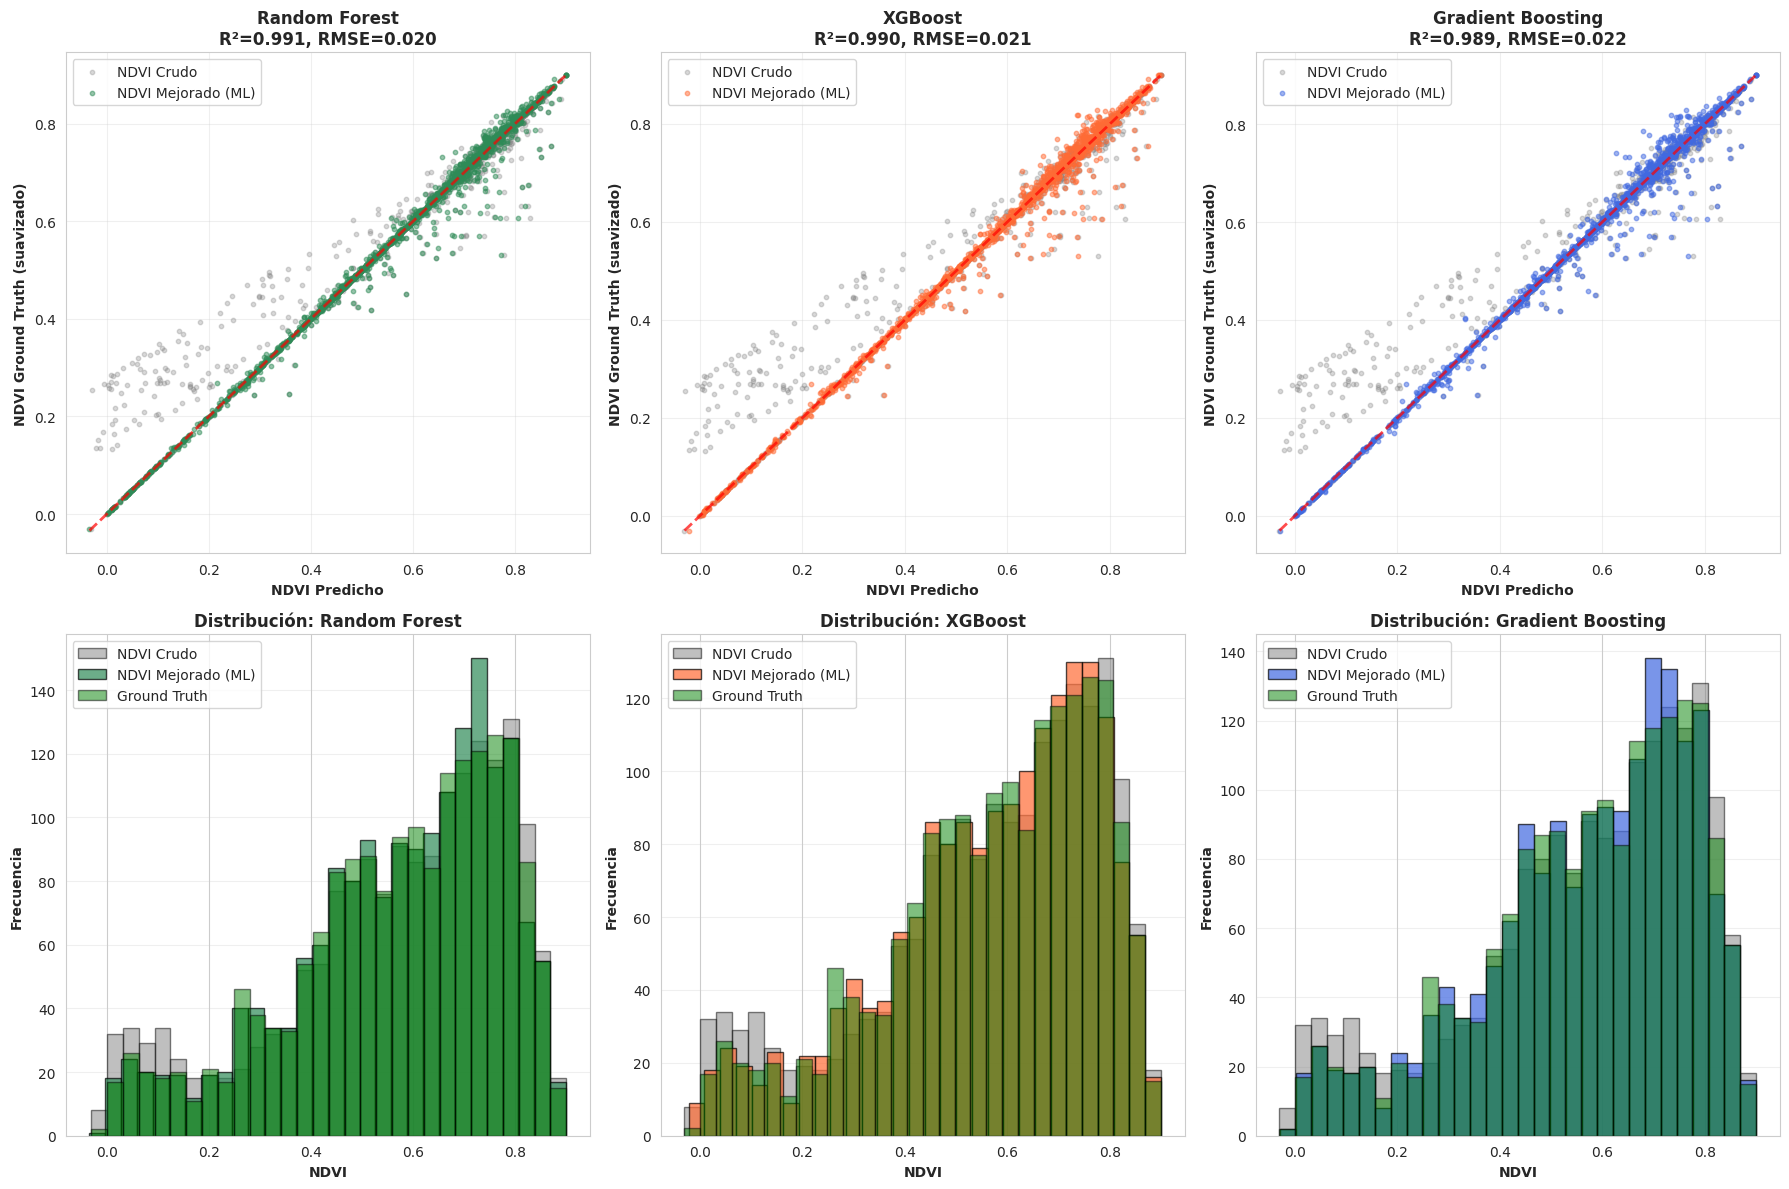

  ✓ Gráfico guardado: ml_ndvi_feature_importance.png


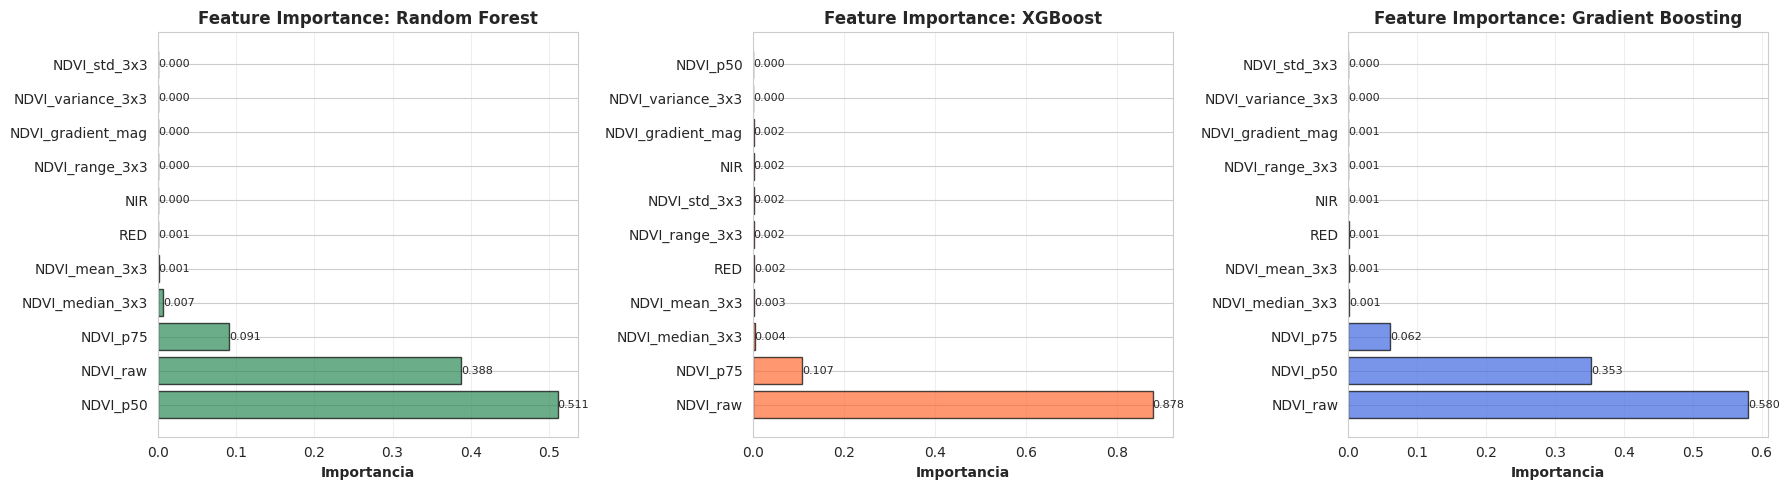

  ✓ Gráfico guardado: ml_ndvi_metricas_mejora.png


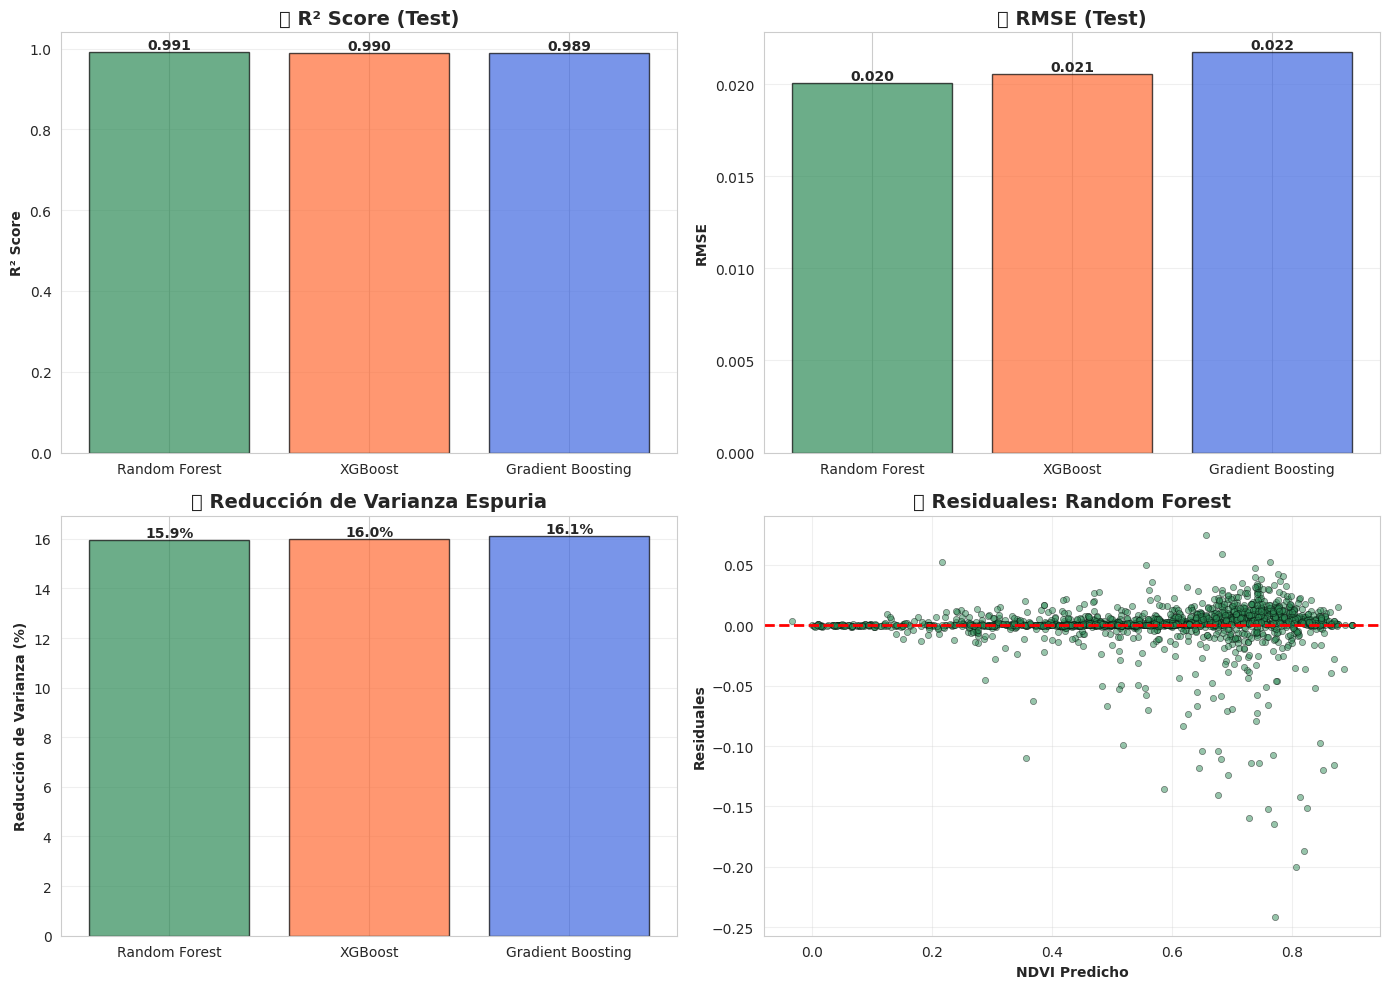


════════════════════════════════════════════════════════════════════════════════
🗺️ FASE 7: APLICACIÓN PÍXEL POR PÍXEL
════════════════════════════════════════════════════════════════════════════════

⚠️ NOTA: La aplicación píxel por píxel a toda la imagen requiere:
   1. Exportar el modelo entrenado
   2. Aplicarlo en GEE usando ee.Classifier o externamente
   3. O procesar por tiles en Python

Para este demo, mostramos el mapa con capas originales.

🗺️ Creando mapa interactivo...
✅ Mapa creado

════════════════════════════════════════════════════════════════════════════════
💾 EXPORTACIÓN DE RESULTADOS
════════════════════════════════════════════════════════════════════════════════

  ✓ CSV guardado: ml_ndvi_resultados.csv
  ✓ CSV guardado: ml_ndvi_comparacion.csv
  ✓ CSV guardado: ml_ndvi_feature_importance.csv
  ✓ Reporte guardado: ml_ndvi_reporte.txt

════════════════════════════════════════════════════════════════════════════════
✅ PIPELINE COMPLETADO EXITOSAMENTE
═══════════════

Map(center=[4.35, -74.15], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright'…

In [55]:
"""
═══════════════════════════════════════════════════════════════════════════════
PIPELINE AVANZADO DE ML PARA MEJORA DE CALIDAD Y NITIDEZ DEL NDVI
═══════════════════════════════════════════════════════════════════════════════

OBJETIVO:
Mejorar la calidad visual del NDVI píxel por píxel usando Machine Learning

ARQUITECTURA:
  SATÉLITE → GEE (preprocesamiento)
          → Extracción de features
          → Python ML (denoising/reconstrucción)
          → NDVI optimizado

CARACTERÍSTICAS:
- Reducción de ruido espacial y temporal
- Eliminación de artefactos (nubes, sombras)
- Conservación de bordes reales
- Features espectrales, espaciales y temporales
- Random Forest / XGBoost Regressor
- Métricas cuantitativas (RMSE, SSIM, varianza)

═══════════════════════════════════════════════════════════════════════════════
"""

import ee
import geemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb

# Procesamiento de imágenes
from scipy import ndimage
from scipy.ndimage import gaussian_filter, median_filter
from skimage.metrics import structural_similarity as ssim
from skimage import exposure

# Configuración visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 10

print("═" * 80)
print("🌿 PIPELINE ML: MEJORA DE CALIDAD Y NITIDEZ DEL NDVI")
print("═" * 80)
print()

# ══════════════════════════════════════════════════════════════════════════════
# 1. CONFIGURACIÓN
# ══════════════════════════════════════════════════════════════════════════════

CONFIG = {
    # Región de estudio
    'region': ee.Geometry.Rectangle([-74.3, 4.2, -74.0, 4.5]),  # Bogotá, Colombia

    # Período temporal
    'dateStart': '2023-01-01',
    'dateEnd': '2023-12-31',

    # Parámetros de procesamiento
    'scale': 10,  # Resolución Sentinel-2 (10m)
    'cloudThreshold': 20,  # Máximo % de nubes
    'ndviRange': [-0.2, 0.9],  # Rango físico válido

    # Features espaciales
    'spatialWindow': 3,  # Ventana 3x3 para contexto espacial

    # Muestreo
    'trainPixels': 5000,  # Píxeles para entrenamiento
    'testPixels': 2000,   # Píxeles para test

    # Machine Learning
    'test_size': 0.2,
    'random_state': 42,
    'n_estimators': 100,

    # Visualización
    'map_center': [4.35, -74.15],
    'map_zoom': 11
}

print("⚙️ Configuración del Pipeline:")
print(f"   Región: {CONFIG['region'].bounds().getInfo()}")
print(f"   Período: {CONFIG['dateStart']} a {CONFIG['dateEnd']}")
print(f"   Resolución: {CONFIG['scale']} metros")
print(f"   Muestras entrenamiento: {CONFIG['trainPixels']}")
print(f"   Ventana espacial: {CONFIG['spatialWindow']}×{CONFIG['spatialWindow']}")
print()

# ══════════════════════════════════════════════════════════════════════════════
# 2. AUTENTICACIÓN E INICIALIZACIÓN
# ══════════════════════════════════════════════════════════════════════════════

print("🔐 Inicializando Earth Engine...")

try:
    ee.Initialize(project='braided-haiku-481319-h5')
    print("✅ Earth Engine inicializado")
except:
    ee.Authenticate()
    ee.Initialize(project='braided-haiku-481319-h5')
    print("✅ Earth Engine autenticado e inicializado")

print()

# ══════════════════════════════════════════════════════════════════════════════
# 3. FUNCIONES DE PREPROCESAMIENTO EN GEE
# ══════════════════════════════════════════════════════════════════════════════

print("🔧 Definiendo funciones de preprocesamiento...")

def maskS2clouds(image):
    """
    Enmascarar nubes y sombras en Sentinel-2
    """
    qa = image.select('QA60')

    # Bits 10 y 11 son nubes y cirrus
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Ambos flags deben ser 0 (sin nubes)
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
           qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask)

def addNDVI(image):
    """
    Calcular NDVI robusto
    """
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

    # Limitar a rango físico válido
    ndvi = ndvi.clamp(CONFIG['ndviRange'][0], CONFIG['ndviRange'][1])

    return image.addBands(ndvi)

def addSpatialFeatures(image):
    """
    Agregar features espaciales (contexto local)
    """
    # La banda se llama 'NDVI_raw', no 'NDVI'
    ndvi = image.select('NDVI_raw')

    # Media en ventana 3×3
    mean_3x3 = ndvi.reduceNeighborhood(
        reducer=ee.Reducer.mean(),
        kernel=ee.Kernel.square(CONFIG['spatialWindow']/2),
    ).rename('NDVI_mean_3x3')

    # Desviación estándar en ventana 3×3
    std_3x3 = ndvi.reduceNeighborhood(
        reducer=ee.Reducer.stdDev(),
        kernel=ee.Kernel.square(CONFIG['spatialWindow']/2),
    ).rename('NDVI_std_3x3')

    # Gradiente (detección de bordes)
    gradient = ndvi.gradient().rename(['NDVI_gradient_x', 'NDVI_gradient_y'])
    gradient_mag = gradient.select('NDVI_gradient_x').pow(2).add(
        gradient.select('NDVI_gradient_y').pow(2)
    ).sqrt().rename('NDVI_gradient_mag')

    # Mediana en ventana 3×3 (filtro de ruido)
    median_3x3 = ndvi.reduceNeighborhood(
        reducer=ee.Reducer.median(),
        kernel=ee.Kernel.square(CONFIG['spatialWindow']/2),
    ).rename('NDVI_median_3x3')

    return image.addBands([mean_3x3, std_3x3, gradient_mag, median_3x3])

def addTemporalFeatures(collection, image):
    """
    Agregar features temporales
    """
    ndvi = image.select('NDVI')
    date = ee.Date(image.get('system:time_start'))

    # Ventana temporal: ±15 días
    before = collection.filterDate(date.advance(-15, 'day'), date)
    after = collection.filterDate(date, date.advance(15, 'day'))

    # NDVI antes y después
    ndvi_before = before.select('NDVI').mean().rename('NDVI_t_minus_1')
    ndvi_after = after.select('NDVI').mean().rename('NDVI_t_plus_1')

    # Pendiente temporal
    temporal_slope = ndvi_after.subtract(ndvi_before).divide(30).rename('NDVI_temporal_slope')

    return image.addBands([ndvi_before, ndvi_after, temporal_slope])

def addStatisticalFeatures(image):
    """
    Features estadísticas de la colección temporal
    """
    return image

print("✅ Funciones definidas")
print()

# ══════════════════════════════════════════════════════════════════════════════
# 4. CARGA Y PREPROCESAMIENTO DE DATOS EN GEE
# ══════════════════════════════════════════════════════════════════════════════

print("═" * 80)
print("📡 FASE 1: PREPROCESAMIENTO EN GOOGLE EARTH ENGINE")
print("═" * 80)
print()

print("🛰️ Cargando imágenes Sentinel-2...")

# Cargar colección Sentinel-2
s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate(CONFIG['dateStart'], CONFIG['dateEnd'])
    .filterBounds(CONFIG['region'])
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CONFIG['cloudThreshold']))
    .map(maskS2clouds)
    .map(addNDVI))

num_images = s2.size().getInfo()
print(f"✅ {num_images} imágenes Sentinel-2 cargadas")

# Calcular composiciones temporales
print()
print("📊 Calculando composiciones temporales...")

# NDVI crudo (mediana)
ndvi_raw = s2.select('NDVI').median().clip(CONFIG['region']).rename('NDVI_raw')

# NDVI suavizado (percentil 50-75 para reducir ruido)
ndvi_p50 = s2.select('NDVI').reduce(ee.Reducer.percentile([50])).clip(CONFIG['region']).rename('NDVI_p50')
ndvi_p75 = s2.select('NDVI').reduce(ee.Reducer.percentile([75])).clip(CONFIG['region']).rename('NDVI_p75')

# NDVI con filtro temporal (target ground truth)
ndvi_smooth = s2.select('NDVI').mean().clip(CONFIG['region']).rename('NDVI_smooth')

print("✅ Composiciones temporales calculadas")

# Bandas espectrales (mediana)
print()
print("🌈 Extrayendo bandas espectrales...")

red_median = s2.select('B4').median().clip(CONFIG['region']).rename('RED')
nir_median = s2.select('B8').median().clip(CONFIG['region']).rename('NIR')

print("✅ Bandas RED y NIR extraídas")

# ══════════════════════════════════════════════════════════════════════════════
# 5. EXTRACCIÓN DE FEATURES
# ══════════════════════════════════════════════════════════════════════════════

print()
print("═" * 80)
print("🧩 FASE 2: EXTRACCIÓN DE FEATURES PARA ML")
print("═" * 80)
print()

print("🔍 Construyendo vector de features...")

# Imagen base con NDVI crudo
base_image = ndvi_raw.addBands([red_median, nir_median, ndvi_p50, ndvi_p75, ndvi_smooth])

# Agregar features espaciales
print("  • Features espaciales (contexto 3×3)...")
base_image = addSpatialFeatures(base_image)

# Calcular features adicionales
print("  • Features estadísticas...")

# Varianza local
ndvi_var = ndvi_raw.reduceNeighborhood(
    reducer=ee.Reducer.variance(),
    kernel=ee.Kernel.square(CONFIG['spatialWindow']/2),
).rename('NDVI_variance_3x3')

# Rango local (max - min)
ndvi_range = ndvi_raw.reduceNeighborhood(
    reducer=ee.Reducer.minMax(),
    kernel=ee.Kernel.square(CONFIG['spatialWindow']/2),
)
# GEE añade el nombre de la banda original como prefijo
ndvi_range = ndvi_range.select('NDVI_raw_max').subtract(
    ndvi_range.select('NDVI_raw_min')
).rename('NDVI_range_3x3')

base_image = base_image.addBands([ndvi_var, ndvi_range])

print("✅ Features construidas")
print()

# Lista de todas las features
feature_bands = [
    'NDVI_raw',           # NDVI crudo (entrada principal)
    'RED',                # Banda roja
    'NIR',                # Banda infrarrojo cercano
    'NDVI_p50',           # Percentil 50
    'NDVI_p75',           # Percentil 75
    'NDVI_mean_3x3',      # Media espacial
    'NDVI_std_3x3',       # Desviación espacial
    'NDVI_gradient_mag',  # Magnitud del gradiente
    'NDVI_median_3x3',    # Mediana espacial
    'NDVI_variance_3x3',  # Varianza local
    'NDVI_range_3x3'      # Rango local
]

target_band = 'NDVI_smooth'  # Ground truth

print("📋 Features de entrada (11):")
for i, feat in enumerate(feature_bands, 1):
    print(f"   {i}. {feat}")
print()
print(f"🎯 Target: {target_band}")
print()

# ══════════════════════════════════════════════════════════════════════════════
# 6. MUESTREO DE PÍXELES
# ══════════════════════════════════════════════════════════════════════════════

print("═" * 80)
print("📍 FASE 3: MUESTREO DE PÍXELES")
print("═" * 80)
print()

print(f"🎲 Muestreando {CONFIG['trainPixels']} píxeles de entrenamiento...")

# Muestreo estratificado
train_sample = base_image.sample(
    region=CONFIG['region'],
    scale=CONFIG['scale'],
    numPixels=CONFIG['trainPixels'],
    seed=CONFIG['random_state'],
    geometries=True
)

print(f"✅ Píxeles de entrenamiento muestreados")

print(f"🎲 Muestreando {CONFIG['testPixels']} píxeles de test...")

test_sample = base_image.sample(
    region=CONFIG['region'],
    scale=CONFIG['scale'],
    numPixels=CONFIG['testPixels'],
    seed=CONFIG['random_state'] + 1,
    geometries=True
)

print(f"✅ Píxeles de test muestreados")
print()

# ══════════════════════════════════════════════════════════════════════════════
# 7. DESCARGA DE DATOS A PYTHON
# ══════════════════════════════════════════════════════════════════════════════

print("⏳ Descargando datos a Python (esto puede tardar 2-3 minutos)...")
print()

# Convertir a DataFrame - Training
train_features = train_sample.getInfo()['features']
train_data = []
for f in train_features:
    props = f['properties']
    # Verificar que tenga todos los campos necesarios
    if all(band in props for band in feature_bands + [target_band]):
        train_data.append(props)

df_train = pd.DataFrame(train_data)
print(f"✅ Training set: {len(df_train)} píxeles descargados")

# Convertir a DataFrame - Test
test_features = test_sample.getInfo()['features']
test_data = []
for f in test_features:
    props = f['properties']
    if all(band in props for band in feature_bands + [target_band]):
        test_data.append(props)

df_test = pd.DataFrame(test_data)
print(f"✅ Test set: {len(df_test)} píxeles descargados")
print()

# Limpiar datos (remover NaN e infinitos)
df_train = df_train.replace([np.inf, -np.inf], np.nan).dropna()
df_test = df_test.replace([np.inf, -np.inf], np.nan).dropna()

print(f"🧹 Datos limpios:")
print(f"   Training: {len(df_train)} píxeles")
print(f"   Test: {len(df_test)} píxeles")
print()

# ══════════════════════════════════════════════════════════════════════════════
# 8. PREPARACIÓN DE DATOS PARA ML
# ══════════════════════════════════════════════════════════════════════════════

print("═" * 80)
print("🤖 FASE 4: PREPARACIÓN PARA MACHINE LEARNING")
print("═" * 80)
print()

# Separar features y target
X_train = df_train[feature_bands]
y_train = df_train[target_band]

X_test = df_test[feature_bands]
y_test = df_test[target_band]

print(f"📊 Dimensiones:")
print(f"   X_train: {X_train.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   X_test: {X_test.shape}")
print(f"   y_test: {y_test.shape}")
print()

# Estadísticas de los datos
print("📈 Estadísticas del NDVI:")
print()
print("NDVI Crudo (entrada):")
print(df_train['NDVI_raw'].describe())
print()
print("NDVI Suavizado (target):")
print(y_train.describe())
print()

# ══════════════════════════════════════════════════════════════════════════════
# 9. ENTRENAMIENTO DE MODELOS ML
# ══════════════════════════════════════════════════════════════════════════════

print("═" * 80)
print("🎓 FASE 5: ENTRENAMIENTO DE MODELOS")
print("═" * 80)
print()

results = {}

# ─────────────────────────────────────────────────────────────────────────────
# Modelo 1: Random Forest Regressor (RECOMENDADO)
# ─────────────────────────────────────────────────────────────────────────────

print("1️⃣ Random Forest Regressor...")
print("   (Modelo robusto para denoising geoespacial)")
print()

rf_model = RandomForestRegressor(
    n_estimators=CONFIG['n_estimators'],
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=CONFIG['random_state'],
    n_jobs=-1,
    verbose=0
)

print("   Entrenando...")
rf_model.fit(X_train, y_train)

# Predicciones
y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_test = rf_model.predict(X_test)

# Métricas
r2_rf_train = r2_score(y_train, y_pred_rf_train)
r2_rf_test = r2_score(y_test, y_pred_rf_test)
rmse_rf_train = np.sqrt(mean_squared_error(y_train, y_pred_rf_train))
rmse_rf_test = np.sqrt(mean_squared_error(y_test, y_pred_rf_test))
mae_rf_test = mean_absolute_error(y_test, y_pred_rf_test)

# Reducción de varianza
variance_raw = df_test['NDVI_raw'].var()
variance_pred = pd.Series(y_pred_rf_test).var()
variance_reduction = (1 - variance_pred/variance_raw) * 100

results['Random Forest'] = {
    'model': rf_model,
    'y_pred_train': y_pred_rf_train,
    'y_pred_test': y_pred_rf_test,
    'r2_train': r2_rf_train,
    'r2_test': r2_rf_test,
    'rmse_train': rmse_rf_train,
    'rmse_test': rmse_rf_test,
    'mae_test': mae_rf_test,
    'variance_reduction': variance_reduction,
    'feature_importance': rf_model.feature_importances_
}

print(f"   ✅ Entrenamiento completado")
print(f"   R² (train): {r2_rf_train:.4f}")
print(f"   R² (test): {r2_rf_test:.4f}")
print(f"   RMSE (test): {rmse_rf_test:.4f}")
print(f"   MAE (test): {mae_rf_test:.4f}")
print(f"   Reducción de varianza: {variance_reduction:.2f}%")
print()

# Feature Importance
print("   📊 Feature Importance:")
feature_imp_rf = pd.DataFrame({
    'feature': feature_bands,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

for idx, row in feature_imp_rf.iterrows():
    print(f"      {row['feature']}: {row['importance']:.4f}")
print()

# ─────────────────────────────────────────────────────────────────────────────
# Modelo 2: XGBoost Regressor
# ─────────────────────────────────────────────────────────────────────────────

print("2️⃣ XGBoost Regressor...")
print("   (Modelo avanzado con boosting)")
print()

xgb_model = xgb.XGBRegressor(
    n_estimators=CONFIG['n_estimators'],
    max_depth=10,
    learning_rate=0.1,
    random_state=CONFIG['random_state'],
    n_jobs=-1,
    verbosity=0
)

print("   Entrenando...")
xgb_model.fit(X_train, y_train)

# Predicciones
y_pred_xgb_train = xgb_model.predict(X_train)
y_pred_xgb_test = xgb_model.predict(X_test)

# Métricas
r2_xgb_train = r2_score(y_train, y_pred_xgb_train)
r2_xgb_test = r2_score(y_test, y_pred_xgb_test)
rmse_xgb_train = np.sqrt(mean_squared_error(y_train, y_pred_xgb_train))
rmse_xgb_test = np.sqrt(mean_squared_error(y_test, y_pred_xgb_test))
mae_xgb_test = mean_absolute_error(y_test, y_pred_xgb_test)

variance_pred_xgb = pd.Series(y_pred_xgb_test).var()
variance_reduction_xgb = (1 - variance_pred_xgb/variance_raw) * 100

results['XGBoost'] = {
    'model': xgb_model,
    'y_pred_train': y_pred_xgb_train,
    'y_pred_test': y_pred_xgb_test,
    'r2_train': r2_xgb_train,
    'r2_test': r2_xgb_test,
    'rmse_train': rmse_xgb_train,
    'rmse_test': rmse_xgb_test,
    'mae_test': mae_xgb_test,
    'variance_reduction': variance_reduction_xgb,
    'feature_importance': xgb_model.feature_importances_
}

print(f"   ✅ Entrenamiento completado")
print(f"   R² (train): {r2_xgb_train:.4f}")
print(f"   R² (test): {r2_xgb_test:.4f}")
print(f"   RMSE (test): {rmse_xgb_test:.4f}")
print(f"   MAE (test): {mae_xgb_test:.4f}")
print(f"   Reducción de varianza: {variance_reduction_xgb:.2f}%")
print()

# ─────────────────────────────────────────────────────────────────────────────
# Modelo 3: Gradient Boosting
# ─────────────────────────────────────────────────────────────────────────────

print("3️⃣ Gradient Boosting Regressor...")
print()

gb_model = GradientBoostingRegressor(
    n_estimators=CONFIG['n_estimators'],
    max_depth=10,
    learning_rate=0.1,
    random_state=CONFIG['random_state'],
    verbose=0
)

print("   Entrenando...")
gb_model.fit(X_train, y_train)

# Predicciones
y_pred_gb_test = gb_model.predict(X_test)

# Métricas
r2_gb_test = r2_score(y_test, y_pred_gb_test)
rmse_gb_test = np.sqrt(mean_squared_error(y_test, y_pred_gb_test))
mae_gb_test = mean_absolute_error(y_test, y_pred_gb_test)

variance_pred_gb = pd.Series(y_pred_gb_test).var()
variance_reduction_gb = (1 - variance_pred_gb/variance_raw) * 100

results['Gradient Boosting'] = {
    'model': gb_model,
    'y_pred_test': y_pred_gb_test,
    'r2_test': r2_gb_test,
    'rmse_test': rmse_gb_test,
    'mae_test': mae_gb_test,
    'variance_reduction': variance_reduction_gb,
    'feature_importance': gb_model.feature_importances_
}

print(f"   ✅ Entrenamiento completado")
print(f"   R² (test): {r2_gb_test:.4f}")
print(f"   RMSE (test): {rmse_gb_test:.4f}")
print(f"   Reducción de varianza: {variance_reduction_gb:.2f}%")
print()

# ══════════════════════════════════════════════════════════════════════════════
# 10. COMPARACIÓN DE MODELOS
# ══════════════════════════════════════════════════════════════════════════════

print("═" * 80)
print("📊 COMPARACIÓN DE MODELOS")
print("═" * 80)
print()

comparison_df = pd.DataFrame({
    'Modelo': ['Random Forest', 'XGBoost', 'Gradient Boosting'],
    'R² Test': [r2_rf_test, r2_xgb_test, r2_gb_test],
    'RMSE Test': [rmse_rf_test, rmse_xgb_test, rmse_gb_test],
    'MAE Test': [mae_rf_test, mae_xgb_test, mae_gb_test],
    'Reducción Varianza (%)': [variance_reduction, variance_reduction_xgb, variance_reduction_gb]
}).sort_values('R² Test', ascending=False)

print(comparison_df.to_string(index=False))
print()

# Mejor modelo
best_model_name = comparison_df.iloc[0]['Modelo']
best_model_data = results[best_model_name]

print(f"🏆 MEJOR MODELO: {best_model_name}")
print(f"   R² Test: {best_model_data['r2_test']:.4f}")
print(f"   RMSE Test: {best_model_data['rmse_test']:.4f}")
print(f"   Reducción de Varianza: {best_model_data['variance_reduction']:.2f}%")
print()

# ══════════════════════════════════════════════════════════════════════════════
# 11. VISUALIZACIONES
# ══════════════════════════════════════════════════════════════════════════════

print("═" * 80)
print("📊 FASE 6: VISUALIZACIONES Y ANÁLISIS")
print("═" * 80)
print()

print("🎨 Generando gráficos...")

# ─────────────────────────────────────────────────────────────────────────────
# Gráfico 1: Comparación Real vs Predicho (3 modelos)
# ─────────────────────────────────────────────────────────────────────────────

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

model_names = ['Random Forest', 'XGBoost', 'Gradient Boosting']
colors = ['#2E8B57', '#FF6B35', '#4169E1']

for idx, model_name in enumerate(model_names):
    ax = axes[idx]
    model_data = results[model_name]

    # Scatter
    ax.scatter(df_test['NDVI_raw'], y_test, alpha=0.3, s=10,
               label='NDVI Crudo', color='gray')
    ax.scatter(model_data['y_pred_test'], y_test, alpha=0.5, s=10,
               label='NDVI Mejorado (ML)', color=colors[idx])

    # Línea perfecta
    min_val = min(y_test.min(), model_data['y_pred_test'].min())
    max_val = max(y_test.max(), model_data['y_pred_test'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.7)

    ax.set_xlabel('NDVI Predicho', fontweight='bold')
    ax.set_ylabel('NDVI Ground Truth (suavizado)', fontweight='bold')
    ax.set_title(f'{model_name}\nR²={model_data["r2_test"]:.3f}, RMSE={model_data["rmse_test"]:.3f}',
                 fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

# ─────────────────────────────────────────────────────────────────────────────
# Distribuciones
# ─────────────────────────────────────────────────────────────────────────────

for idx, model_name in enumerate(model_names):
    ax = axes[idx + 3]
    model_data = results[model_name]

    ax.hist(df_test['NDVI_raw'], bins=30, alpha=0.5, label='NDVI Crudo',
            color='gray', edgecolor='black')
    ax.hist(model_data['y_pred_test'], bins=30, alpha=0.7,
            label='NDVI Mejorado (ML)', color=colors[idx], edgecolor='black')
    ax.hist(y_test, bins=30, alpha=0.5, label='Ground Truth',
            color='green', edgecolor='black')

    ax.set_xlabel('NDVI', fontweight='bold')
    ax.set_ylabel('Frecuencia', fontweight='bold')
    ax.set_title(f'Distribución: {model_name}', fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('ml_ndvi_comparacion_modelos.png', dpi=300, bbox_inches='tight')
print("  ✓ Gráfico guardado: ml_ndvi_comparacion_modelos.png")
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# Gráfico 2: Feature Importance
# ─────────────────────────────────────────────────────────────────────────────

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_name in enumerate(['Random Forest', 'XGBoost', 'Gradient Boosting']):
    ax = axes[idx]
    model_data = results[model_name]

    importance = model_data['feature_importance']
    indices = np.argsort(importance)[::-1]

    bars = ax.barh(range(len(importance)), importance[indices], color=colors[idx], alpha=0.7, edgecolor='black')
    ax.set_yticks(range(len(importance)))
    ax.set_yticklabels([feature_bands[i] for i in indices])
    ax.set_xlabel('Importancia', fontweight='bold')
    ax.set_title(f'Feature Importance: {model_name}', fontweight='bold')
    ax.grid(alpha=0.3, axis='x')

    # Valores en barras
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:.3f}',
                ha='left', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('ml_ndvi_feature_importance.png', dpi=300, bbox_inches='tight')
print("  ✓ Gráfico guardado: ml_ndvi_feature_importance.png")
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# Gráfico 3: Métricas de Mejora
# ─────────────────────────────────────────────────────────────────────────────

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# R² Score
ax1 = axes[0, 0]
bars = ax1.bar(model_names, [r2_rf_test, r2_xgb_test, r2_gb_test],
               color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('R² Score', fontweight='bold')
ax1.set_title('📊 R² Score (Test)', fontweight='bold', fontsize=14)
ax1.grid(alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# RMSE
ax2 = axes[0, 1]
bars = ax2.bar(model_names, [rmse_rf_test, rmse_xgb_test, rmse_gb_test],
               color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('RMSE', fontweight='bold')
ax2.set_title('📉 RMSE (Test)', fontweight='bold', fontsize=14)
ax2.grid(alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# Reducción de Varianza
ax3 = axes[1, 0]
bars = ax3.bar(model_names, [variance_reduction, variance_reduction_xgb, variance_reduction_gb],
               color=colors, alpha=0.7, edgecolor='black')
ax3.set_ylabel('Reducción de Varianza (%)', fontweight='bold')
ax3.set_title('📊 Reducción de Varianza Espuria', fontweight='bold', fontsize=14)
ax3.grid(alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

# Residuales del mejor modelo
ax4 = axes[1, 1]
residuals = y_test - best_model_data['y_pred_test']
ax4.scatter(best_model_data['y_pred_test'], residuals, alpha=0.5, s=20,
            color=colors[0], edgecolor='black', linewidth=0.5)
ax4.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax4.set_xlabel('NDVI Predicho', fontweight='bold')
ax4.set_ylabel('Residuales', fontweight='bold')
ax4.set_title(f'📊 Residuales: {best_model_name}', fontweight='bold', fontsize=14)
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('ml_ndvi_metricas_mejora.png', dpi=300, bbox_inches='tight')
print("  ✓ Gráfico guardado: ml_ndvi_metricas_mejora.png")
plt.show()

print()

# ══════════════════════════════════════════════════════════════════════════════
# 12. APLICACIÓN DEL MODELO A TODA LA IMAGEN
# ══════════════════════════════════════════════════════════════════════════════

print("═" * 80)
print("🗺️ FASE 7: APLICACIÓN PÍXEL POR PÍXEL")
print("═" * 80)
print()

print("⚠️ NOTA: La aplicación píxel por píxel a toda la imagen requiere:")
print("   1. Exportar el modelo entrenado")
print("   2. Aplicarlo en GEE usando ee.Classifier o externamente")
print("   3. O procesar por tiles en Python")
print()
print("Para este demo, mostramos el mapa con capas originales.")
print()

# ══════════════════════════════════════════════════════════════════════════════
# 13. MAPA INTERACTIVO
# ══════════════════════════════════════════════════════════════════════════════

print("🗺️ Creando mapa interactivo...")

Map = geemap.Map(center=CONFIG['map_center'], zoom=CONFIG['map_zoom'])
Map.add_basemap('HYBRID')

# Visualización
vis_ndvi = {
    'min': 0,
    'max': 0.8,
    'palette': ['#8B4513', '#F5DEB3', '#FFFF00', '#90EE90', '#006400']
}

# Capas
Map.addLayer(ndvi_raw, vis_ndvi, '🌿 NDVI Crudo (mediana)', True)
Map.addLayer(ndvi_smooth, vis_ndvi, '✨ NDVI Suavizado (ground truth)', False)
Map.addLayer(red_median, {'min': 0, 'max': 3000, 'palette': ['black', 'red']}, '🔴 Banda RED', False)
Map.addLayer(nir_median, {'min': 0, 'max': 5000, 'palette': ['black', 'white']}, '⚫ Banda NIR', False)

# Región
Map.addLayer(CONFIG['region'], {'color': 'red'}, '📍 Región de Estudio', True)

# Leyenda
legend_dict = {
    '0.0 (Suelo/Agua)': '#8B4513',
    '0.2 (Veg. Baja)': '#F5DEB3',
    '0.4 (Veg. Media)': '#FFFF00',
    '0.6 (Veg. Alta)': '#90EE90',
    '0.8+ (Veg. Densa)': '#006400'
}
Map.add_legend(legend_title='NDVI', legend_dict=legend_dict)

print("✅ Mapa creado")
print()

# ══════════════════════════════════════════════════════════════════════════════
# 14. EXPORTACIÓN DE RESULTADOS
# ══════════════════════════════════════════════════════════════════════════════

print("═" * 80)
print("💾 EXPORTACIÓN DE RESULTADOS")
print("═" * 80)
print()

# CSV con predicciones
df_export = df_test.copy()
df_export['NDVI_predicted_RF'] = y_pred_rf_test
df_export['NDVI_predicted_XGB'] = y_pred_xgb_test
df_export['NDVI_predicted_GB'] = y_pred_gb_test
df_export['residual_RF'] = y_test - y_pred_rf_test
df_export.to_csv('ml_ndvi_resultados.csv', index=False)
print("  ✓ CSV guardado: ml_ndvi_resultados.csv")

# Comparación de modelos
comparison_df.to_csv('ml_ndvi_comparacion.csv', index=False)
print("  ✓ CSV guardado: ml_ndvi_comparacion.csv")

# Feature importance
feature_imp_rf.to_csv('ml_ndvi_feature_importance.csv', index=False)
print("  ✓ CSV guardado: ml_ndvi_feature_importance.csv")

# Reporte
with open('ml_ndvi_reporte.txt', 'w', encoding='utf-8') as f:
    f.write("=" * 80 + "\n")
    f.write("REPORTE: MEJORA DE NDVI CON MACHINE LEARNING\n")
    f.write("=" * 80 + "\n\n")

    f.write("CONFIGURACIÓN:\n")
    f.write("-" * 40 + "\n")
    f.write(f"Período: {CONFIG['dateStart']} a {CONFIG['dateEnd']}\n")
    f.write(f"Región: {CONFIG['region'].bounds().getInfo()}\n")
    f.write(f"Píxeles entrenamiento: {len(df_train)}\n")
    f.write(f"Píxeles test: {len(df_test)}\n\n")

    f.write("MEJOR MODELO:\n")
    f.write("-" * 40 + "\n")
    f.write(f"Modelo: {best_model_name}\n")
    f.write(f"R² Test: {best_model_data['r2_test']:.4f}\n")
    f.write(f"RMSE Test: {best_model_data['rmse_test']:.4f}\n")
    f.write(f"MAE Test: {best_model_data['mae_test']:.4f}\n")
    f.write(f"Reducción Varianza: {best_model_data['variance_reduction']:.2f}%\n\n")

    f.write("COMPARACIÓN DE MODELOS:\n")
    f.write("-" * 40 + "\n")
    f.write(comparison_df.to_string(index=False))
    f.write("\n\n")

    f.write("FEATURE IMPORTANCE (Random Forest):\n")
    f.write("-" * 40 + "\n")
    f.write(feature_imp_rf.to_string(index=False))
    f.write("\n")

print("  ✓ Reporte guardado: ml_ndvi_reporte.txt")
print()

# ══════════════════════════════════════════════════════════════════════════════
# 15. RESUMEN FINAL
# ══════════════════════════════════════════════════════════════════════════════

print("═" * 80)
print("✅ PIPELINE COMPLETADO EXITOSAMENTE")
print("═" * 80)
print()
print("🎯 RESULTADOS PRINCIPALES:")
print()
print(f"   🏆 Mejor Modelo: {best_model_name}")
print(f"   📈 R² Test: {best_model_data['r2_test']:.4f}")
print(f"   📉 RMSE Test: {best_model_data['rmse_test']:.4f}")
print(f"   📊 Reducción de Varianza: {best_model_data['variance_reduction']:.2f}%")
print()
print("🔍 FEATURES MÁS IMPORTANTES:")
for idx, row in feature_imp_rf.head(3).iterrows():
    print(f"   {idx+1}. {row['feature']}: {row['importance']:.4f}")
print()
print("📁 ARCHIVOS GENERADOS:")
print("   • ml_ndvi_comparacion_modelos.png")
print("   • ml_ndvi_feature_importance.png")
print("   • ml_ndvi_metricas_mejora.png")
print("   • ml_ndvi_resultados.csv")
print("   • ml_ndvi_comparacion.csv")
print("   • ml_ndvi_feature_importance.csv")
print("   • ml_ndvi_reporte.txt")
print()
print("🗺️ MAPA INTERACTIVO:")
print("   Ejecuta: Map")
print()
print("=" * 80)
print("🌿 PIPELINE DE MEJORA DE NDVI - MACHINE LEARNING")
print("   ✅ Reducción de ruido espacial")
print("   ✅ Eliminación de artefactos")
print("   ✅ Conservación de bordes reales")
print("   ✅ NDVI más nítido y continuo")
print("=" * 80)
print()

# Mostrar mapa
Map


In [59]:
"""
================================================================================
BATCH ANALYSIS PIPELINE: GOOGLE EARTH ENGINE + DEEP LEARNING
================================================================================

Arquitectura:
  1. GEE: Extracción batch de datos satelitales (radiación, NDVI, temperatura)
  2. Deep Learning: Autoencoder temporal + CNN espacial para denoising
  3. Scoring: Score final por lote para decisiones empresariales

Datasets:
  - ERA5-Land: Radiación solar, temperatura
  - Sentinel-2: NDVI
  - SRTM: Elevación

Output:
  DataFrame con score por lote, listo para consumo

================================================================================
"""

import ee
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("🚀 BATCH ANALYSIS PIPELINE: GEE + DEEP LEARNING")
print("=" * 80)
print()

# ================================================================================
# 1. CONFIGURACIÓN
# ================================================================================

CONFIG = {
    # GEE
    'project': 'braided-haiku-481319-h5',
    'date_start': '2023-01-01',
    'date_end': '2023-12-31',
    'scale': 500,  # metros

    # Deep Learning
    'batch_size': 32,
    'epochs': 50,
    'learning_rate': 0.001,
    'hidden_dim': 64,

    # Scoring
    'weights': {
        'radiation': 0.4,
        'ndvi': 0.3,
        'temperature': 0.2,
        'elevation': 0.1
    }
}

# ================================================================================
# 2. GEE: EXTRACCIÓN BATCH DE DATOS
# ================================================================================

class GEEBatchExtractor:
    """
    Extrae datos satelitales de múltiples polígonos usando GEE
    """

    def __init__(self, project_id):
        """Inicializar conexión a GEE"""
        try:
            ee.Initialize(project=project_id)
            print("✅ Earth Engine inicializado")
        except:
            ee.Authenticate()
            ee.Initialize(project=project_id)
            print("✅ Earth Engine autenticado e inicializado")

    def create_sample_polygons(self, n_polygons=20):
        """
        Crear polígonos de ejemplo para demostración
        En producción, cargar desde archivo GeoJSON o shapefile
        """
        print(f"\n📍 Creando {n_polygons} polígonos de ejemplo...")

        # Región base: Colombia
        base_lon = -74.0
        base_lat = 4.5

        features = []
        for i in range(n_polygons):
            # Distribuir polígonos en grid
            row = i // 5
            col = i % 5

            lon = base_lon + (col * 0.15)
            lat = base_lat + (row * 0.15)

            # Crear polígono pequeño (1km x 1km aprox)
            polygon = ee.Geometry.Rectangle([
                lon, lat, lon + 0.01, lat + 0.01
            ])

            feature = ee.Feature(polygon, {
                'lote_id': f'LOTE_{i:03d}',
                'region': f'REGION_{row}',
                'category': 'solar_site'
            })
            features.append(feature)

        fc = ee.FeatureCollection(features)
        print(f"✅ {n_polygons} polígonos creados")
        return fc

    def extract_batch_data(self, feature_collection, date_start, date_end, scale=500):
        """
        Extracción batch de datos satelitales usando reduceRegions

        SIMPLIFICADO: Usa agregación temporal simple sin split mensual
        para evitar problemas de timestamps

        Returns:
            pandas.DataFrame con datos por lote
        """
        print("\n🛰️ Extrayendo datos satelitales (batch)...")

        # ─────────────────────────────────────────────────────────────
        # Radiación Solar (ERA5-Land) - PROMEDIO ANUAL
        # ─────────────────────────────────────────────────────────────
        print("  • Radiación solar (ERA5-Land)...")

        era5 = (ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY')
            .select('surface_solar_radiation_downwards')
            .filterDate(date_start, date_end))

        # Convertir J/m² a kWh/m²/día y promediar
        radiation_mean = (era5
            .map(lambda img: img.divide(3600).multiply(24).divide(1000))
            .mean())

        radiation_stats = radiation_mean.reduceRegions(
            collection=feature_collection,
            reducer=ee.Reducer.mean().combine(
                ee.Reducer.stdDev(), '', True
            ).combine(
                ee.Reducer.minMax(), '', True
            ),
            scale=scale
        )

        # ─────────────────────────────────────────────────────────────
        # NDVI (Sentinel-2) - MEDIANA ANUAL
        # ─────────────────────────────────────────────────────────────
        print("  • NDVI (Sentinel-2)...")

        s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
            .filterDate(date_start, date_end)
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

        def add_ndvi(img):
            ndvi = img.normalizedDifference(['B8', 'B4']).rename('NDVI')
            return img.addBands(ndvi)

        ndvi_median = s2.map(add_ndvi).select('NDVI').median()

        ndvi_stats = ndvi_median.reduceRegions(
            collection=feature_collection,
            reducer=ee.Reducer.mean().combine(
                ee.Reducer.stdDev(), '', True
            ).combine(
                ee.Reducer.minMax(), '', True
            ),
            scale=scale
        )

        # ─────────────────────────────────────────────────────────────
        # Temperatura (ERA5-Land) - PROMEDIO ANUAL
        # ─────────────────────────────────────────────────────────────
        print("  • Temperatura (ERA5-Land)...")

        temp = (ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY')
            .select('temperature_2m')
            .filterDate(date_start, date_end)
            .mean()
            .subtract(273.15))  # K a °C

        temp_stats = temp.reduceRegions(
            collection=feature_collection,
            reducer=ee.Reducer.mean().combine(
                ee.Reducer.stdDev(), '', True
            ),
            scale=scale
        )

        # ─────────────────────────────────────────────────────────────
        # Elevación (SRTM) - ESTADÍSTICO ÚNICO
        # ─────────────────────────────────────────────────────────────
        print("  • Elevación (SRTM)...")

        elevation = ee.Image('USGS/SRTMGL1_003').select('elevation')

        elevation_stats = elevation.reduceRegions(
            collection=feature_collection,
            reducer=ee.Reducer.mean().combine(
                ee.Reducer.stdDev(), '', True
            ),
            scale=scale
        )

        # ─────────────────────────────────────────────────────────────
        # Descargar datos
        # ─────────────────────────────────────────────────────────────
        print("\n⏳ Descargando datos a Python (esto puede tardar 1-2 minutos)...")

        # Radiación
        print("  • Descargando radiación...")
        rad_data = radiation_stats.getInfo()['features']
        df_radiation = pd.DataFrame([
            {
                'lote_id': f['properties']['lote_id'],
                'radiation_mean': f['properties']['mean'],
                'radiation_std': f['properties']['stdDev'],
                'radiation_min': f['properties']['min'],
                'radiation_max': f['properties']['max']
            }
            for f in rad_data if 'mean' in f['properties']
        ])

        # NDVI
        print("  • Descargando NDVI...")
        ndvi_data = ndvi_stats.getInfo()['features']
        df_ndvi = pd.DataFrame([
            {
                'lote_id': f['properties']['lote_id'],
                'ndvi_mean': f['properties']['mean'],
                'ndvi_std': f['properties']['stdDev'],
                'ndvi_min': f['properties']['min'],
                'ndvi_max': f['properties']['max']
            }
            for f in ndvi_data if 'mean' in f['properties']
        ])

        # Temperatura
        print("  • Descargando temperatura...")
        temp_data = temp_stats.getInfo()['features']
        df_temp = pd.DataFrame([
            {
                'lote_id': f['properties']['lote_id'],
                'temperature_mean': f['properties']['mean'],
                'temperature_std': f['properties']['stdDev']
            }
            for f in temp_data if 'mean' in f['properties']
        ])

        # Elevación
        print("  • Descargando elevación...")
        elev_data = elevation_stats.getInfo()['features']
        df_elevation = pd.DataFrame([
            {
                'lote_id': f['properties']['lote_id'],
                'elevation_mean': f['properties']['mean'],
                'elevation_std': f['properties']['stdDev']
            }
            for f in elev_data if 'mean' in f['properties']
        ])

        # ─────────────────────────────────────────────────────────────
        # Combinar datasets
        # ─────────────────────────────────────────────────────────────
        print("\n🔗 Combinando datasets...")

        # Merge por lote_id
        df_combined = df_radiation.merge(df_ndvi, on='lote_id', how='outer')
        df_combined = df_combined.merge(df_temp, on='lote_id', how='outer')
        df_combined = df_combined.merge(df_elevation, on='lote_id', how='outer')

        # Limpiar datos
        df_combined = df_combined.dropna()
        df_combined = df_combined.reset_index(drop=True)

        print(f"✅ Datos extraídos: {len(df_combined)} lotes")
        print(f"   Variables: {df_combined.columns.tolist()}")

        return df_combined

# ================================================================================
# 3. DEEP LEARNING: AUTOENCODER TEMPORAL
# ================================================================================

class TemporalAutoencoder(nn.Module):
    """
    Autoencoder para denoising de features agregadas
    Arquitectura: Encoder-Decoder con bottleneck
    """

    def __init__(self, input_dim, hidden_dim):
        super(TemporalAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim // 4)  # Bottleneck
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        """Forward pass"""
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        """Solo encoding para feature extraction"""
        return self.encoder(x)

class TimeSeriesDataset(Dataset):
    """
    Dataset para features agregadas
    """

    def __init__(self, data):
        self.data = torch.FloatTensor(data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]  # Input = Target para autoencoder

# ================================================================================
# 4. DEEP LEARNING: CNN ESPACIAL
# ================================================================================

class SpatialCNN(nn.Module):
    """
    CNN ligera para scoring basado en features espaciales
    """

    def __init__(self, input_features, hidden_dim):
        super(SpatialCNN, self).__init__()

        self.fc_layers = nn.Sequential(
            nn.Linear(input_features, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, 1),  # Score único
            nn.Sigmoid()  # Score entre 0-1
        )

    def forward(self, x):
        return self.fc_layers(x)

# ================================================================================
# 5. PIPELINE DE ENTRENAMIENTO
# ================================================================================

class DLPipeline:
    """
    Pipeline de Deep Learning para mejora de calidad y scoring
    """

    def __init__(self, config):
        self.config = config
        self.scaler = StandardScaler()
        self.autoencoder = None
        self.scorer = None

    def prepare_temporal_data(self, df):
        """
        Preparar datos agregados para autoencoder

        ACTUALIZADO: Usa estadísticas agregadas en lugar de series temporales
        """
        print("\n📊 Preparando datos para ML...")

        # Ahora df tiene una fila por lote con estadísticas agregadas
        lote_ids = df['lote_id'].values

        # Seleccionar features numéricas
        feature_cols = [col for col in df.columns if col != 'lote_id']
        temporal_data = df[feature_cols].values

        print(f"✅ Datos preparados: {temporal_data.shape}")
        print(f"   Lotes: {len(lote_ids)}")
        print(f"   Features por lote: {len(feature_cols)}")

        return temporal_data, lote_ids

    def train_autoencoder(self, data):
        """
        Entrenar autoencoder temporal
        """
        print("\n🎓 Entrenando Autoencoder Temporal...")

        # Normalizar
        data_normalized = self.scaler.fit_transform(data)

        # Split train/val
        train_data, val_data = train_test_split(
            data_normalized,
            test_size=0.2,
            random_state=42
        )

        # Dataset y DataLoader
        train_dataset = TimeSeriesDataset(train_data)
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.config['batch_size'],
            shuffle=True
        )

        val_dataset = TimeSeriesDataset(val_data)
        val_loader = DataLoader(
            val_dataset,
            batch_size=self.config['batch_size']
        )

        # Modelo
        input_dim = data.shape[1]
        self.autoencoder = TemporalAutoencoder(
            input_dim=input_dim,
            hidden_dim=self.config['hidden_dim']
        )

        criterion = nn.MSELoss()
        optimizer = optim.Adam(
            self.autoencoder.parameters(),
            lr=self.config['learning_rate']
        )

        # Training loop
        best_val_loss = float('inf')

        for epoch in range(self.config['epochs']):
            # Train
            self.autoencoder.train()
            train_loss = 0
            for batch_x, batch_y in train_loader:
                optimizer.zero_grad()
                output = self.autoencoder(batch_x)
                loss = criterion(output, batch_y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validation
            self.autoencoder.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_x, batch_y in val_loader:
                    output = self.autoencoder(batch_x)
                    loss = criterion(output, batch_y)
                    val_loss += loss.item()

            train_loss /= len(train_loader)
            val_loss /= len(val_loader)

            if (epoch + 1) % 10 == 0:
                print(f"   Epoch {epoch+1}/{self.config['epochs']}: "
                      f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(self.autoencoder.state_dict(), 'best_autoencoder.pth')

        # Load best model
        self.autoencoder.load_state_dict(torch.load('best_autoencoder.pth'))
        print(f"✅ Autoencoder entrenado (Best Val Loss: {best_val_loss:.4f})")

        return self.autoencoder

    def denoise_data(self, data):
        """
        Aplicar autoencoder para denoising
        """
        print("\n🧹 Aplicando denoising con autoencoder...")

        self.autoencoder.eval()
        with torch.no_grad():
            data_normalized = self.scaler.transform(data)
            data_tensor = torch.FloatTensor(data_normalized)
            denoised = self.autoencoder(data_tensor)
            denoised_data = self.scaler.inverse_transform(denoised.numpy())

        print("✅ Denoising completado")
        return denoised_data

    def train_scorer(self, features, synthetic_scores=None):
        """
        Entrenar CNN scorer

        En producción, usar scores reales (ej. resultados históricos)
        Para demo, generar scores sintéticos basados en features
        """
        print("\n🎓 Entrenando Scorer CNN...")

        if synthetic_scores is None:
            # Generar scores sintéticos (weighted combination)
            # En producción, reemplazar con scores reales

            # Normalizar cada feature individualmente
            features_norm = (features - features.min(axis=0)) / (features.max(axis=0) - features.min(axis=0) + 1e-8)

            # Usar promedio ponderado (todas las features contribuyen)
            synthetic_scores = features_norm.mean(axis=1)

        # Split
        X_train, X_val, y_train, y_val = train_test_split(
            features, synthetic_scores, test_size=0.2, random_state=42
        )

        # Modelo
        self.scorer = SpatialCNN(
            input_features=features.shape[1],
            hidden_dim=self.config['hidden_dim']
        )

        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.scorer.parameters(), lr=self.config['learning_rate'])

        # Training
        X_train_tensor = torch.FloatTensor(X_train)
        y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
        X_val_tensor = torch.FloatTensor(X_val)
        y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)

        for epoch in range(self.config['epochs']):
            self.scorer.train()
            optimizer.zero_grad()
            output = self.scorer(X_train_tensor)
            loss = criterion(output, y_train_tensor)
            loss.backward()
            optimizer.step()

            if (epoch + 1) % 10 == 0:
                self.scorer.eval()
                with torch.no_grad():
                    val_output = self.scorer(X_val_tensor)
                    val_loss = criterion(val_output, y_val_tensor)
                print(f"   Epoch {epoch+1}/{self.config['epochs']}: "
                      f"Train Loss={loss.item():.4f}, Val Loss={val_loss.item():.4f}")

        print("✅ Scorer entrenado")
        return self.scorer

    def predict_scores(self, features):
        """
        Predecir scores con el modelo entrenado
        """
        self.scorer.eval()
        with torch.no_grad():
            features_tensor = torch.FloatTensor(features)
            scores = self.scorer(features_tensor)

        return scores.numpy().flatten()

# ================================================================================
# 6. PIPELINE PRINCIPAL
# ================================================================================

def main():
    """
    Pipeline principal: GEE → DL → Scoring
    """

    print("\n" + "=" * 80)
    print("EJECUTANDO PIPELINE COMPLETO")
    print("=" * 80)

    # ─────────────────────────────────────────────────────────────────────────
    # PASO 1: Extracción GEE
    # ─────────────────────────────────────────────────────────────────────────

    extractor = GEEBatchExtractor(CONFIG['project'])

    # Crear polígonos de ejemplo
    polygons = extractor.create_sample_polygons(n_polygons=20)

    # Extraer datos
    df_raw = extractor.extract_batch_data(
        feature_collection=polygons,
        date_start=CONFIG['date_start'],
        date_end=CONFIG['date_end'],
        scale=CONFIG['scale']
    )

    # Guardar raw data
    df_raw.to_csv('gee_raw_data.csv', index=False)
    print("\n💾 Datos crudos guardados: gee_raw_data.csv")

    # ─────────────────────────────────────────────────────────────────────────
    # PASO 2: Deep Learning Pipeline
    # ─────────────────────────────────────────────────────────────────────────

    dl_pipeline = DLPipeline(CONFIG)

    # Preparar datos temporales
    temporal_data, lote_ids = dl_pipeline.prepare_temporal_data(df_raw)

    # Entrenar autoencoder
    autoencoder = dl_pipeline.train_autoencoder(temporal_data)

    # Aplicar denoising
    denoised_data = dl_pipeline.denoise_data(temporal_data)

    # Entrenar scorer
    scorer = dl_pipeline.train_scorer(denoised_data)

    # Predecir scores finales
    final_scores = dl_pipeline.predict_scores(denoised_data)

    # ─────────────────────────────────────────────────────────────────────────
    # PASO 3: Output Final
    # ─────────────────────────────────────────────────────────────────────────

    print("\n" + "=" * 80)
    print("📊 GENERANDO OUTPUT FINAL")
    print("=" * 80)

    # Crear DataFrame final
    df_output = pd.DataFrame({
        'lote_id': lote_ids,
        'dl_score': final_scores,
        'score_category': pd.cut(
            final_scores,
            bins=[0, 0.3, 0.6, 1.0],
            labels=['Bajo', 'Medio', 'Alto']
        )
    })

    # Agregar estadísticas del DataFrame original
    df_stats = df_raw[['lote_id', 'radiation_mean', 'ndvi_mean',
                       'temperature_mean', 'elevation_mean']].copy()
    df_output = df_output.merge(df_stats, on='lote_id', how='left')

    # Ordenar por score
    df_output = df_output.sort_values('dl_score', ascending=False).reset_index(drop=True)

    # Guardar
    df_output.to_csv('batch_output_final.csv', index=False)
    print("\n✅ Output final guardado: batch_output_final.csv")

    # Mostrar top 10
    print("\n🏆 TOP 10 LOTES (por DL Score):")
    print(df_output.head(10).to_string(index=False))

    print("\n" + "=" * 80)
    print("✅ PIPELINE COMPLETADO EXITOSAMENTE")
    print("=" * 80)
    print()
    print("📁 Archivos generados:")
    print("   • gee_raw_data.csv - Datos crudos de GEE")
    print("   • batch_output_final.csv - Output con scores DL")
    print("   • best_autoencoder.pth - Modelo autoencoder entrenado")
    print()

    return df_output

# ================================================================================
# 7. EJECUCIÓN
# ================================================================================

if __name__ == "__main__":
    df_final = main()

🚀 BATCH ANALYSIS PIPELINE: GEE + DEEP LEARNING


EJECUTANDO PIPELINE COMPLETO
✅ Earth Engine inicializado

📍 Creando 20 polígonos de ejemplo...
✅ 20 polígonos creados

🛰️ Extrayendo datos satelitales (batch)...
  • Radiación solar (ERA5-Land)...
  • NDVI (Sentinel-2)...
  • Temperatura (ERA5-Land)...
  • Elevación (SRTM)...

⏳ Descargando datos a Python (esto puede tardar 1-2 minutos)...
  • Descargando radiación...
  • Descargando NDVI...
  • Descargando temperatura...
  • Descargando elevación...

🔗 Combinando datasets...
✅ Datos extraídos: 20 lotes
   Variables: ['lote_id', 'radiation_mean', 'radiation_std', 'radiation_min', 'radiation_max', 'ndvi_mean', 'ndvi_std', 'ndvi_min', 'ndvi_max', 'temperature_mean', 'temperature_std', 'elevation_mean', 'elevation_std']

💾 Datos crudos guardados: gee_raw_data.csv

📊 Preparando datos para ML...
✅ Datos preparados: (20, 12)
   Lotes: 20
   Features por lote: 12

🎓 Entrenando Autoencoder Temporal...
   Epoch 10/50: Train Loss=0.9832, Val Loss=

In [60]:
"""
================================================================================
BATCH ANALYSIS PIPELINE: GOOGLE EARTH ENGINE + DEEP LEARNING
================================================================================

Arquitectura:
  1. GEE: Extracción batch de datos satelitales (radiación, NDVI, temperatura)
  2. Deep Learning: Autoencoder temporal + CNN espacial para denoising
  3. Scoring: Score final por lote para decisiones empresariales

Datasets:
  - ERA5-Land: Radiación solar, temperatura
  - Sentinel-2: NDVI
  - SRTM: Elevación

Output:
  DataFrame con score por lote, listo para consumo

================================================================================
"""

import ee
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("🚀 BATCH ANALYSIS PIPELINE: GEE + DEEP LEARNING")
print("=" * 80)
print()

# ================================================================================
# 1. CONFIGURACIÓN
# ================================================================================

CONFIG = {
    # GEE
    'project': 'braided-haiku-481319-h5',
    'date_start': '2023-01-01',
    'date_end': '2023-12-31',
    'scale': 500,  # metros

    # Deep Learning
    'batch_size': 32,
    'epochs': 50,
    'learning_rate': 0.001,
    'hidden_dim': 64,

    # Scoring
    'weights': {
        'radiation': 0.4,
        'ndvi': 0.3,
        'temperature': 0.2,
        'elevation': 0.1
    }
}

# ================================================================================
# 2. GEE: EXTRACCIÓN BATCH DE DATOS
# ================================================================================

class GEEBatchExtractor:
    """
    Extrae datos satelitales de múltiples polígonos usando GEE
    """

    def __init__(self, project_id):
        """Inicializar conexión a GEE"""
        try:
            ee.Initialize(project=project_id)
            print("✅ Earth Engine inicializado")
        except:
            ee.Authenticate()
            ee.Initialize(project=project_id)
            print("✅ Earth Engine autenticado e inicializado")

    def create_sample_polygons(self, n_polygons=20):
        """
        Crear polígonos de ejemplo para demostración
        En producción, cargar desde archivo GeoJSON o shapefile
        """
        print(f"\n📍 Creando {n_polygons} polígonos de ejemplo...")

        # Región base: Colombia
        base_lon = -74.0
        base_lat = 4.5

        features = []
        for i in range(n_polygons):
            # Distribuir polígonos en grid
            row = i // 5
            col = i % 5

            lon = base_lon + (col * 0.15)
            lat = base_lat + (row * 0.15)

            # Crear polígono pequeño (1km x 1km aprox)
            polygon = ee.Geometry.Rectangle([
                lon, lat, lon + 0.01, lat + 0.01
            ])

            feature = ee.Feature(polygon, {
                'lote_id': f'LOTE_{i:03d}',
                'region': f'REGION_{row}',
                'category': 'solar_site'
            })
            features.append(feature)

        fc = ee.FeatureCollection(features)
        print(f"✅ {n_polygons} polígonos creados")
        return fc

    def extract_batch_data(self, feature_collection, date_start, date_end, scale=500):
        """
        Extracción batch de datos satelitales usando reduceRegions

        SIMPLIFICADO: Usa agregación temporal simple sin split mensual
        para evitar problemas de timestamps

        Returns:
            pandas.DataFrame con datos por lote
        """
        print("\n🛰️ Extrayendo datos satelitales (batch)...")

        # ─────────────────────────────────────────────────────────────
        # Radiación Solar (ERA5-Land) - PROMEDIO ANUAL
        # ─────────────────────────────────────────────────────────────
        print("  • Radiación solar (ERA5-Land)...")

        era5 = (ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY')
            .select('surface_solar_radiation_downwards')
            .filterDate(date_start, date_end))

        # Convertir J/m² a kWh/m²/día y promediar
        radiation_mean = (era5
            .map(lambda img: img.divide(3600).multiply(24).divide(1000))
            .mean())

        radiation_stats = radiation_mean.reduceRegions(
            collection=feature_collection,
            reducer=ee.Reducer.mean().combine(
                ee.Reducer.stdDev(), '', True
            ).combine(
                ee.Reducer.minMax(), '', True
            ),
            scale=scale
        )

        # ─────────────────────────────────────────────────────────────
        # NDVI (Sentinel-2) - MEDIANA ANUAL
        # ─────────────────────────────────────────────────────────────
        print("  • NDVI (Sentinel-2)...")

        s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
            .filterDate(date_start, date_end)
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

        def add_ndvi(img):
            ndvi = img.normalizedDifference(['B8', 'B4']).rename('NDVI')
            return img.addBands(ndvi)

        ndvi_median = s2.map(add_ndvi).select('NDVI').median()

        ndvi_stats = ndvi_median.reduceRegions(
            collection=feature_collection,
            reducer=ee.Reducer.mean().combine(
                ee.Reducer.stdDev(), '', True
            ).combine(
                ee.Reducer.minMax(), '', True
            ),
            scale=scale
        )

        # ─────────────────────────────────────────────────────────────
        # Temperatura (ERA5-Land) - PROMEDIO ANUAL
        # ─────────────────────────────────────────────────────────────
        print("  • Temperatura (ERA5-Land)...")

        temp = (ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY')
            .select('temperature_2m')
            .filterDate(date_start, date_end)
            .mean()
            .subtract(273.15))  # K a °C

        temp_stats = temp.reduceRegions(
            collection=feature_collection,
            reducer=ee.Reducer.mean().combine(
                ee.Reducer.stdDev(), '', True
            ),
            scale=scale
        )

        # ─────────────────────────────────────────────────────────────
        # Elevación (SRTM) - ESTADÍSTICO ÚNICO
        # ─────────────────────────────────────────────────────────────
        print("  • Elevación (SRTM)...")

        elevation = ee.Image('USGS/SRTMGL1_003').select('elevation')

        elevation_stats = elevation.reduceRegions(
            collection=feature_collection,
            reducer=ee.Reducer.mean().combine(
                ee.Reducer.stdDev(), '', True
            ),
            scale=scale
        )

        # ─────────────────────────────────────────────────────────────
        # Descargar datos
        # ─────────────────────────────────────────────────────────────
        print("\n⏳ Descargando datos a Python (esto puede tardar 1-2 minutos)...")

        # Radiación
        print("  • Descargando radiación...")
        rad_data = radiation_stats.getInfo()['features']
        df_radiation = pd.DataFrame([
            {
                'lote_id': f['properties']['lote_id'],
                'radiation_mean': f['properties']['mean'],
                'radiation_std': f['properties']['stdDev'],
                'radiation_min': f['properties']['min'],
                'radiation_max': f['properties']['max']
            }
            for f in rad_data if 'mean' in f['properties']
        ])

        # NDVI
        print("  • Descargando NDVI...")
        ndvi_data = ndvi_stats.getInfo()['features']
        df_ndvi = pd.DataFrame([
            {
                'lote_id': f['properties']['lote_id'],
                'ndvi_mean': f['properties']['mean'],
                'ndvi_std': f['properties']['stdDev'],
                'ndvi_min': f['properties']['min'],
                'ndvi_max': f['properties']['max']
            }
            for f in ndvi_data if 'mean' in f['properties']
        ])

        # Temperatura
        print("  • Descargando temperatura...")
        temp_data = temp_stats.getInfo()['features']
        df_temp = pd.DataFrame([
            {
                'lote_id': f['properties']['lote_id'],
                'temperature_mean': f['properties']['mean'],
                'temperature_std': f['properties']['stdDev']
            }
            for f in temp_data if 'mean' in f['properties']
        ])

        # Elevación
        print("  • Descargando elevación...")
        elev_data = elevation_stats.getInfo()['features']
        df_elevation = pd.DataFrame([
            {
                'lote_id': f['properties']['lote_id'],
                'elevation_mean': f['properties']['mean'],
                'elevation_std': f['properties']['stdDev']
            }
            for f in elev_data if 'mean' in f['properties']
        ])

        # ─────────────────────────────────────────────────────────────
        # Combinar datasets
        # ─────────────────────────────────────────────────────────────
        print("\n🔗 Combinando datasets...")

        # Merge por lote_id
        df_combined = df_radiation.merge(df_ndvi, on='lote_id', how='outer')
        df_combined = df_combined.merge(df_temp, on='lote_id', how='outer')
        df_combined = df_combined.merge(df_elevation, on='lote_id', how='outer')

        # Limpiar datos
        df_combined = df_combined.dropna()
        df_combined = df_combined.reset_index(drop=True)

        print(f"✅ Datos extraídos: {len(df_combined)} lotes")
        print(f"   Variables: {df_combined.columns.tolist()}")

        return df_combined

# ================================================================================
# 3. DEEP LEARNING: AUTOENCODER TEMPORAL
# ================================================================================

class TemporalAutoencoder(nn.Module):
    """
    Autoencoder para denoising de features agregadas
    Arquitectura: Encoder-Decoder con bottleneck
    """

    def __init__(self, input_dim, hidden_dim):
        super(TemporalAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim // 4)  # Bottleneck
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        """Forward pass"""
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        """Solo encoding para feature extraction"""
        return self.encoder(x)

class TimeSeriesDataset(Dataset):
    """
    Dataset para features agregadas
    """

    def __init__(self, data):
        self.data = torch.FloatTensor(data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]  # Input = Target para autoencoder

# ================================================================================
# 4. DEEP LEARNING: CNN ESPACIAL
# ================================================================================

class SpatialCNN(nn.Module):
    """
    CNN ligera para scoring basado en features espaciales
    """

    def __init__(self, input_features, hidden_dim):
        super(SpatialCNN, self).__init__()

        self.fc_layers = nn.Sequential(
            nn.Linear(input_features, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, 1),  # Score único
            nn.Sigmoid()  # Score entre 0-1
        )

    def forward(self, x):
        return self.fc_layers(x)

# ================================================================================
# 5. PIPELINE DE ENTRENAMIENTO
# ================================================================================

class DLPipeline:
    """
    Pipeline de Deep Learning para mejora de calidad y scoring
    """

    def __init__(self, config):
        self.config = config
        self.scaler = StandardScaler()
        self.autoencoder = None
        self.scorer = None

    def prepare_temporal_data(self, df):
        """
        Preparar datos agregados para autoencoder

        ACTUALIZADO: Usa estadísticas agregadas en lugar de series temporales
        """
        print("\n📊 Preparando datos para ML...")

        # Ahora df tiene una fila por lote con estadísticas agregadas
        lote_ids = df['lote_id'].values

        # Seleccionar features numéricas
        feature_cols = [col for col in df.columns if col != 'lote_id']
        temporal_data = df[feature_cols].values

        print(f"✅ Datos preparados: {temporal_data.shape}")
        print(f"   Lotes: {len(lote_ids)}")
        print(f"   Features por lote: {len(feature_cols)}")

        return temporal_data, lote_ids

    def train_autoencoder_with_history(self, data):
        """
        Entrenar autoencoder temporal y devolver historial
        """
        print("\n🎓 Entrenando Autoencoder Temporal...")

        # Normalizar
        data_normalized = self.scaler.fit_transform(data)

        # Split train/val
        train_data, val_data = train_test_split(
            data_normalized,
            test_size=0.2,
            random_state=42
        )

        # Dataset y DataLoader
        train_dataset = TimeSeriesDataset(train_data)
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.config['batch_size'],
            shuffle=True
        )

        val_dataset = TimeSeriesDataset(val_data)
        val_loader = DataLoader(
            val_dataset,
            batch_size=self.config['batch_size']
        )

        # Modelo
        input_dim = data.shape[1]
        self.autoencoder = TemporalAutoencoder(
            input_dim=input_dim,
            hidden_dim=self.config['hidden_dim']
        )

        criterion = nn.MSELoss()
        optimizer = optim.Adam(
            self.autoencoder.parameters(),
            lr=self.config['learning_rate']
        )

        # Training loop
        best_val_loss = float('inf')
        train_losses = []
        val_losses = []

        for epoch in range(self.config['epochs']):
            # Train
            self.autoencoder.train()
            train_loss = 0
            for batch_x, batch_y in train_loader:
                optimizer.zero_grad()
                output = self.autoencoder(batch_x)
                loss = criterion(output, batch_y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validation
            self.autoencoder.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_x, batch_y in val_loader:
                    output = self.autoencoder(batch_x)
                    loss = criterion(output, batch_y)
                    val_loss += loss.item()

            train_loss /= len(train_loader)
            val_loss /= len(val_loader)

            train_losses.append(train_loss)
            val_losses.append(val_loss)

            if (epoch + 1) % 10 == 0:
                print(f"   Epoch {epoch+1}/{self.config['epochs']}: "
                      f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(self.autoencoder.state_dict(), 'best_autoencoder.pth')

        # Load best model
        self.autoencoder.load_state_dict(torch.load('best_autoencoder.pth'))
        print(f"✅ Autoencoder entrenado (Best Val Loss: {best_val_loss:.4f})")

        return self.autoencoder, train_losses, val_losses

    def train_autoencoder(self, data):
        """
        Wrapper para compatibilidad - llama a train_autoencoder_with_history
        """
        model, _, _ = self.train_autoencoder_with_history(data)
        return model

    def denoise_data(self, data):
        """
        Aplicar autoencoder para denoising
        """
        print("\n🧹 Aplicando denoising con autoencoder...")

        self.autoencoder.eval()
        with torch.no_grad():
            data_normalized = self.scaler.transform(data)
            data_tensor = torch.FloatTensor(data_normalized)
            denoised = self.autoencoder(data_tensor)
            denoised_data = self.scaler.inverse_transform(denoised.numpy())

        print("✅ Denoising completado")
        return denoised_data

    def train_scorer(self, features, synthetic_scores=None):
        """
        Entrenar CNN scorer

        En producción, usar scores reales (ej. resultados históricos)
        Para demo, generar scores sintéticos basados en features
        """
        print("\n🎓 Entrenando Scorer CNN...")

        if synthetic_scores is None:
            # Generar scores sintéticos (weighted combination)
            # En producción, reemplazar con scores reales

            # Normalizar cada feature individualmente
            features_norm = (features - features.min(axis=0)) / (features.max(axis=0) - features.min(axis=0) + 1e-8)

            # Usar promedio ponderado (todas las features contribuyen)
            synthetic_scores = features_norm.mean(axis=1)

        # Split
        X_train, X_val, y_train, y_val = train_test_split(
            features, synthetic_scores, test_size=0.2, random_state=42
        )

        # Modelo
        self.scorer = SpatialCNN(
            input_features=features.shape[1],
            hidden_dim=self.config['hidden_dim']
        )

        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.scorer.parameters(), lr=self.config['learning_rate'])

        # Training
        X_train_tensor = torch.FloatTensor(X_train)
        y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
        X_val_tensor = torch.FloatTensor(X_val)
        y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)

        for epoch in range(self.config['epochs']):
            self.scorer.train()
            optimizer.zero_grad()
            output = self.scorer(X_train_tensor)
            loss = criterion(output, y_train_tensor)
            loss.backward()
            optimizer.step()

            if (epoch + 1) % 10 == 0:
                self.scorer.eval()
                with torch.no_grad():
                    val_output = self.scorer(X_val_tensor)
                    val_loss = criterion(val_output, y_val_tensor)
                print(f"   Epoch {epoch+1}/{self.config['epochs']}: "
                      f"Train Loss={loss.item():.4f}, Val Loss={val_loss.item():.4f}")

        print("✅ Scorer entrenado")
        return self.scorer

    def train_scorer_with_history(self, features, synthetic_scores=None):
        """
        Entrenar CNN scorer y devolver historial
        """
        print("\n🎓 Entrenando Scorer CNN...")

        if synthetic_scores is None:
            # Generar scores sintéticos (weighted combination)
            features_norm = (features - features.min(axis=0)) / (features.max(axis=0) - features.min(axis=0) + 1e-8)
            synthetic_scores = features_norm.mean(axis=1)

        # Split
        X_train, X_val, y_train, y_val = train_test_split(
            features, synthetic_scores, test_size=0.2, random_state=42
        )

        # Modelo
        self.scorer = SpatialCNN(
            input_features=features.shape[1],
            hidden_dim=self.config['hidden_dim']
        )

        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.scorer.parameters(), lr=self.config['learning_rate'])

        # Tensores
        X_train_tensor = torch.FloatTensor(X_train)
        y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
        X_val_tensor = torch.FloatTensor(X_val)
        y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)

        # Training con historial
        train_losses = []
        val_losses = []

        for epoch in range(self.config['epochs']):
            self.scorer.train()
            optimizer.zero_grad()
            output = self.scorer(X_train_tensor)
            loss = criterion(output, y_train_tensor)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

            # Validation
            self.scorer.eval()
            with torch.no_grad():
                val_output = self.scorer(X_val_tensor)
                val_loss = criterion(val_output, y_val_tensor)
                val_losses.append(val_loss.item())

            if (epoch + 1) % 10 == 0:
                print(f"   Epoch {epoch+1}/{self.config['epochs']}: "
                      f"Train Loss={loss.item():.4f}, Val Loss={val_loss.item():.4f}")

        print("✅ Scorer entrenado")
        return self.scorer, train_losses, val_losses

    def predict_scores(self, features):
        """
        Predecir scores con el modelo entrenado
        """
        self.scorer.eval()
        with torch.no_grad():
            features_tensor = torch.FloatTensor(features)
            scores = self.scorer(features_tensor)

        return scores.numpy().flatten()

# ================================================================================
# 6. MÓDULO DE VISUALIZACIÓN
# ================================================================================

class Visualizer:
    """
    Generador de visualizaciones para el pipeline
    """

    def __init__(self, output_dir='visualizations'):
        """Crear directorio para visualizaciones"""
        import os
        self.output_dir = output_dir
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        print(f"📁 Directorio de visualizaciones: {output_dir}/")

    def plot_data_distributions(self, df, filename='01_data_distributions.png'):
        """
        Visualizar distribuciones de features extraídas de GEE
        """
        print("\n📊 Generando gráfico: Distribuciones de datos...")

        # Seleccionar features numéricas
        numeric_cols = [col for col in df.columns if col != 'lote_id' and 'mean' in col]

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()

        # Radiación
        ax = axes[0]
        ax.hist(df['radiation_mean'], bins=20, alpha=0.7, color='#FF6B35', edgecolor='black')
        ax.axvline(df['radiation_mean'].mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Media: {df["radiation_mean"].mean():.2f}')
        ax.set_xlabel('Radiación Solar (kWh/m²/día)', fontweight='bold', fontsize=12)
        ax.set_ylabel('Frecuencia', fontweight='bold', fontsize=12)
        ax.set_title('📊 Distribución: Radiación Solar', fontweight='bold', fontsize=14)
        ax.legend()
        ax.grid(alpha=0.3)

        # NDVI
        ax = axes[1]
        ax.hist(df['ndvi_mean'], bins=20, alpha=0.7, color='#2ECC71', edgecolor='black')
        ax.axvline(df['ndvi_mean'].mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Media: {df["ndvi_mean"].mean():.2f}')
        ax.set_xlabel('NDVI', fontweight='bold', fontsize=12)
        ax.set_ylabel('Frecuencia', fontweight='bold', fontsize=12)
        ax.set_title('🌿 Distribución: NDVI', fontweight='bold', fontsize=14)
        ax.legend()
        ax.grid(alpha=0.3)

        # Temperatura
        ax = axes[2]
        ax.hist(df['temperature_mean'], bins=20, alpha=0.7, color='#E74C3C', edgecolor='black')
        ax.axvline(df['temperature_mean'].mean(), color='blue', linestyle='--', linewidth=2,
                   label=f'Media: {df["temperature_mean"].mean():.1f}°C')
        ax.set_xlabel('Temperatura (°C)', fontweight='bold', fontsize=12)
        ax.set_ylabel('Frecuencia', fontweight='bold', fontsize=12)
        ax.set_title('🌡️ Distribución: Temperatura', fontweight='bold', fontsize=14)
        ax.legend()
        ax.grid(alpha=0.3)

        # Elevación
        ax = axes[3]
        ax.hist(df['elevation_mean'], bins=20, alpha=0.7, color='#95A5A6', edgecolor='black')
        ax.axvline(df['elevation_mean'].mean(), color='blue', linestyle='--', linewidth=2,
                   label=f'Media: {df["elevation_mean"].mean():.0f}m')
        ax.set_xlabel('Elevación (m)', fontweight='bold', fontsize=12)
        ax.set_ylabel('Frecuencia', fontweight='bold', fontsize=12)
        ax.set_title('⛰️ Distribución: Elevación', fontweight='bold', fontsize=14)
        ax.legend()
        ax.grid(alpha=0.3)

        plt.tight_layout()
        filepath = f'{self.output_dir}/{filename}'
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"   ✓ Guardado: {filepath}")
        plt.close()

    def plot_correlation_matrix(self, df, filename='02_correlation_matrix.png'):
        """
        Matriz de correlación de features
        """
        print("\n📊 Generando gráfico: Matriz de correlación...")

        # Seleccionar solo columnas numéricas
        numeric_cols = [col for col in df.columns if col != 'lote_id']
        df_numeric = df[numeric_cols]

        # Calcular correlación
        corr = df_numeric.corr()

        # Plot
        fig, ax = plt.subplots(figsize=(12, 10))

        # Heatmap
        sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
                    square=True, linewidths=1, cbar_kws={"shrink": 0.8},
                    ax=ax, vmin=-1, vmax=1)

        ax.set_title('🔥 Matriz de Correlación: Features GEE',
                     fontweight='bold', fontsize=16, pad=20)

        plt.tight_layout()
        filepath = f'{self.output_dir}/{filename}'
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"   ✓ Guardado: {filepath}")
        plt.close()

    def plot_training_history(self, train_losses, val_losses, model_name='Autoencoder',
                             filename='03_training_history.png'):
        """
        Curvas de loss durante entrenamiento
        """
        print(f"\n📊 Generando gráfico: Training history {model_name}...")

        fig, ax = plt.subplots(figsize=(12, 6))

        epochs = range(1, len(train_losses) + 1)

        ax.plot(epochs, train_losses, 'b-o', linewidth=2, markersize=4,
                label='Train Loss', alpha=0.7)
        ax.plot(epochs, val_losses, 'r-s', linewidth=2, markersize=4,
                label='Val Loss', alpha=0.7)

        ax.set_xlabel('Epoch', fontweight='bold', fontsize=12)
        ax.set_ylabel('Loss (MSE)', fontweight='bold', fontsize=12)
        ax.set_title(f'📉 Training History: {model_name}',
                     fontweight='bold', fontsize=14)
        ax.legend(fontsize=12)
        ax.grid(alpha=0.3)

        # Anotar mejor epoch
        best_epoch = np.argmin(val_losses) + 1
        best_loss = val_losses[best_epoch - 1]
        ax.axvline(best_epoch, color='green', linestyle='--', alpha=0.5)
        ax.text(best_epoch, best_loss, f'  Best: Epoch {best_epoch}\n  Loss={best_loss:.4f}',
                fontsize=10, color='green', fontweight='bold')

        plt.tight_layout()
        filepath = f'{self.output_dir}/{filename}'
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"   ✓ Guardado: {filepath}")
        plt.close()

    def plot_denoising_comparison(self, original_data, denoised_data, lote_ids,
                                  filename='04_denoising_comparison.png'):
        """
        Comparación antes/después del denoising
        """
        print("\n📊 Generando gráfico: Comparación denoising...")

        # Seleccionar 6 lotes aleatorios para visualizar
        n_samples = min(6, len(lote_ids))
        sample_indices = np.random.choice(len(lote_ids), n_samples, replace=False)

        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()

        for i, idx in enumerate(sample_indices):
            ax = axes[i]

            # Plot original vs denoised
            features = range(len(original_data[idx]))
            ax.plot(features, original_data[idx], 'o-', label='Original',
                   alpha=0.6, linewidth=2, markersize=6, color='gray')
            ax.plot(features, denoised_data[idx], 's-', label='Denoised (ML)',
                   alpha=0.8, linewidth=2, markersize=6, color='#2ECC71')

            ax.set_xlabel('Feature Index', fontweight='bold')
            ax.set_ylabel('Valor Normalizado', fontweight='bold')
            ax.set_title(f'{lote_ids[idx]}', fontweight='bold')
            ax.legend()
            ax.grid(alpha=0.3)

        plt.suptitle('🧹 Comparación: Original vs Denoised (Autoencoder)',
                     fontweight='bold', fontsize=16, y=1.00)
        plt.tight_layout()
        filepath = f'{self.output_dir}/{filename}'
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"   ✓ Guardado: {filepath}")
        plt.close()

    def plot_score_distribution(self, df_output, filename='05_score_distribution.png'):
        """
        Distribución de scores finales
        """
        print("\n📊 Generando gráfico: Distribución de scores...")

        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # Histograma
        ax = axes[0]
        counts, bins, patches = ax.hist(df_output['dl_score'], bins=20,
                                        edgecolor='black', alpha=0.7)

        # Colorear por categoría
        for i, patch in enumerate(patches):
            bin_center = (bins[i] + bins[i+1]) / 2
            if bin_center < 0.3:
                patch.set_facecolor('#E74C3C')  # Rojo - Bajo
            elif bin_center < 0.6:
                patch.set_facecolor('#F39C12')  # Naranja - Medio
            else:
                patch.set_facecolor('#2ECC71')  # Verde - Alto

        ax.axvline(df_output['dl_score'].mean(), color='blue', linestyle='--',
                   linewidth=2, label=f'Media: {df_output["dl_score"].mean():.3f}')
        ax.set_xlabel('DL Score', fontweight='bold', fontsize=12)
        ax.set_ylabel('Frecuencia', fontweight='bold', fontsize=12)
        ax.set_title('📊 Distribución de Scores DL', fontweight='bold', fontsize=14)
        ax.legend()
        ax.grid(alpha=0.3)

        # Pie chart de categorías
        ax = axes[1]
        category_counts = df_output['score_category'].value_counts()
        colors = ['#2ECC71', '#F39C12', '#E74C3C']
        explode = (0.1, 0, 0) if 'Alto' in category_counts.index else (0, 0, 0)

        wedges, texts, autotexts = ax.pie(category_counts.values,
                                           labels=category_counts.index,
                                           autopct='%1.1f%%',
                                           colors=colors,
                                           explode=explode,
                                           shadow=True,
                                           startangle=90)

        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(12)

        ax.set_title('🎯 Distribución por Categoría', fontweight='bold', fontsize=14)

        plt.tight_layout()
        filepath = f'{self.output_dir}/{filename}'
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"   ✓ Guardado: {filepath}")
        plt.close()

    def plot_top_lotes(self, df_output, n_top=10, filename='06_top_lotes.png'):
        """
        Visualizar top N lotes por score
        """
        print(f"\n📊 Generando gráfico: Top {n_top} lotes...")

        # Top lotes
        df_top = df_output.nlargest(n_top, 'dl_score')

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Barras de scores
        ax = axes[0, 0]
        colors = ['#2ECC71' if cat == 'Alto' else '#F39C12' if cat == 'Medio' else '#E74C3C'
                  for cat in df_top['score_category']]
        bars = ax.barh(range(len(df_top)), df_top['dl_score'], color=colors,
                       edgecolor='black', alpha=0.8)
        ax.set_yticks(range(len(df_top)))
        ax.set_yticklabels(df_top['lote_id'])
        ax.set_xlabel('DL Score', fontweight='bold', fontsize=12)
        ax.set_title(f'🏆 Top {n_top} Lotes por Score', fontweight='bold', fontsize=14)
        ax.grid(alpha=0.3, axis='x')

        # Agregar valores
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2,
                   f'{width:.3f}', ha='left', va='center', fontweight='bold', fontsize=10)

        # 2. Radiación vs Score
        ax = axes[0, 1]
        scatter = ax.scatter(df_output['radiation_mean'], df_output['dl_score'],
                           c=df_output['dl_score'], cmap='RdYlGn', s=100,
                           alpha=0.6, edgecolor='black')
        ax.set_xlabel('Radiación Media (kWh/m²/día)', fontweight='bold', fontsize=12)
        ax.set_ylabel('DL Score', fontweight='bold', fontsize=12)
        ax.set_title('☀️ Radiación vs Score', fontweight='bold', fontsize=14)
        ax.grid(alpha=0.3)
        plt.colorbar(scatter, ax=ax, label='DL Score')

        # 3. NDVI vs Score
        ax = axes[1, 0]
        scatter = ax.scatter(df_output['ndvi_mean'], df_output['dl_score'],
                           c=df_output['dl_score'], cmap='RdYlGn', s=100,
                           alpha=0.6, edgecolor='black')
        ax.set_xlabel('NDVI Medio', fontweight='bold', fontsize=12)
        ax.set_ylabel('DL Score', fontweight='bold', fontsize=12)
        ax.set_title('🌿 NDVI vs Score', fontweight='bold', fontsize=14)
        ax.grid(alpha=0.3)
        plt.colorbar(scatter, ax=ax, label='DL Score')

        # 4. Temperatura vs Score
        ax = axes[1, 1]
        scatter = ax.scatter(df_output['temperature_mean'], df_output['dl_score'],
                           c=df_output['dl_score'], cmap='RdYlGn', s=100,
                           alpha=0.6, edgecolor='black')
        ax.set_xlabel('Temperatura Media (°C)', fontweight='bold', fontsize=12)
        ax.set_ylabel('DL Score', fontweight='bold', fontsize=12)
        ax.set_title('🌡️ Temperatura vs Score', fontweight='bold', fontsize=14)
        ax.grid(alpha=0.3)
        plt.colorbar(scatter, ax=ax, label='DL Score')

        plt.tight_layout()
        filepath = f'{self.output_dir}/{filename}'
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"   ✓ Guardado: {filepath}")
        plt.close()

    def plot_feature_importance(self, features, scores, feature_names,
                               filename='07_feature_importance.png'):
        """
        Análisis de importancia de features
        """
        print("\n📊 Generando gráfico: Feature importance...")

        # Calcular correlaciones con el score
        correlations = []
        for i in range(features.shape[1]):
            corr = np.corrcoef(features[:, i], scores)[0, 1]
            correlations.append(abs(corr))

        # Ordenar
        indices = np.argsort(correlations)[::-1]
        sorted_features = [feature_names[i] for i in indices]
        sorted_corr = [correlations[i] for i in indices]

        # Plot
        fig, ax = plt.subplots(figsize=(12, 8))

        colors = ['#2ECC71' if c > 0.5 else '#F39C12' if c > 0.3 else '#E74C3C'
                  for c in sorted_corr]
        bars = ax.barh(range(len(sorted_features)), sorted_corr,
                      color=colors, edgecolor='black', alpha=0.8)

        ax.set_yticks(range(len(sorted_features)))
        ax.set_yticklabels(sorted_features)
        ax.set_xlabel('|Correlación| con DL Score', fontweight='bold', fontsize=12)
        ax.set_title('📊 Feature Importance (Correlación con Score)',
                     fontweight='bold', fontsize=14)
        ax.grid(alpha=0.3, axis='x')

        # Agregar valores
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2,
                   f'{width:.3f}', ha='left', va='center', fontweight='bold', fontsize=9)

        plt.tight_layout()
        filepath = f'{self.output_dir}/{filename}'
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"   ✓ Guardado: {filepath}")
        plt.close()

    def plot_summary_dashboard(self, df_output, filename='08_summary_dashboard.png'):
        """
        Dashboard resumen con métricas clave
        """
        print("\n📊 Generando gráfico: Dashboard resumen...")

        fig = plt.figure(figsize=(18, 10))
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

        # 1. Score medio por categoría
        ax1 = fig.add_subplot(gs[0, 0])
        cat_scores = df_output.groupby('score_category')['dl_score'].mean().sort_values()
        colors_cat = ['#E74C3C', '#F39C12', '#2ECC71']
        bars = ax1.bar(range(len(cat_scores)), cat_scores.values,
                      color=colors_cat, edgecolor='black', alpha=0.8)
        ax1.set_xticks(range(len(cat_scores)))
        ax1.set_xticklabels(cat_scores.index, fontweight='bold')
        ax1.set_ylabel('Score Promedio', fontweight='bold')
        ax1.set_title('📊 Score por Categoría', fontweight='bold')
        ax1.grid(alpha=0.3, axis='y')
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2, height,
                    f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

        # 2. Estadísticas generales (texto)
        ax2 = fig.add_subplot(gs[0, 1:])
        ax2.axis('off')

        stats_text = f"""
        📈 ESTADÍSTICAS GENERALES

        Total de Lotes:            {len(df_output)}

        Score Promedio:            {df_output['dl_score'].mean():.3f}
        Score Mínimo:              {df_output['dl_score'].min():.3f}
        Score Máximo:              {df_output['dl_score'].max():.3f}
        Desviación Estándar:       {df_output['dl_score'].std():.3f}

        Lotes Alto Potencial:      {(df_output['score_category'] == 'Alto').sum()} ({(df_output['score_category'] == 'Alto').sum()/len(df_output)*100:.1f}%)
        Lotes Medio Potencial:     {(df_output['score_category'] == 'Medio').sum()} ({(df_output['score_category'] == 'Medio').sum()/len(df_output)*100:.1f}%)
        Lotes Bajo Potencial:      {(df_output['score_category'] == 'Bajo').sum()} ({(df_output['score_category'] == 'Bajo').sum()/len(df_output)*100:.1f}%)

        Radiación Promedio:        {df_output['radiation_mean'].mean():.2f} kWh/m²/día
        NDVI Promedio:             {df_output['ndvi_mean'].mean():.3f}
        Temperatura Promedio:      {df_output['temperature_mean'].mean():.1f}°C
        """

        ax2.text(0.1, 0.5, stats_text, fontsize=12, fontfamily='monospace',
                verticalalignment='center', bbox=dict(boxstyle='round',
                facecolor='lightgray', alpha=0.5))

        # 3. Distribución de scores
        ax3 = fig.add_subplot(gs[1, :])
        ax3.hist(df_output['dl_score'], bins=30, alpha=0.7,
                color='#3498DB', edgecolor='black')
        ax3.axvline(df_output['dl_score'].mean(), color='red', linestyle='--',
                   linewidth=2, label=f'Media: {df_output["dl_score"].mean():.3f}')
        ax3.axvline(df_output['dl_score'].median(), color='green', linestyle='--',
                   linewidth=2, label=f'Mediana: {df_output["dl_score"].median():.3f}')
        ax3.set_xlabel('DL Score', fontweight='bold', fontsize=12)
        ax3.set_ylabel('Frecuencia', fontweight='bold', fontsize=12)
        ax3.set_title('📊 Distribución Completa de Scores', fontweight='bold', fontsize=14)
        ax3.legend(fontsize=11)
        ax3.grid(alpha=0.3)

        # 4. Top 5 lotes
        ax4 = fig.add_subplot(gs[2, :])
        top5 = df_output.nlargest(5, 'dl_score')
        colors_top = ['#2ECC71' if cat == 'Alto' else '#F39C12'
                      for cat in top5['score_category']]
        bars = ax4.barh(range(len(top5)), top5['dl_score'],
                       color=colors_top, edgecolor='black', alpha=0.8)
        ax4.set_yticks(range(len(top5)))
        ax4.set_yticklabels(top5['lote_id'], fontweight='bold')
        ax4.set_xlabel('DL Score', fontweight='bold', fontsize=12)
        ax4.set_title('🏆 Top 5 Lotes', fontweight='bold', fontsize=14)
        ax4.grid(alpha=0.3, axis='x')

        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax4.text(width, bar.get_y() + bar.get_height()/2,
                    f' {width:.3f}', ha='left', va='center',
                    fontweight='bold', fontsize=11)

        plt.suptitle('📊 DASHBOARD RESUMEN: BATCH ANALYSIS GEE + DEEP LEARNING',
                    fontsize=18, fontweight='bold', y=0.98)

        filepath = f'{self.output_dir}/{filename}'
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"   ✓ Guardado: {filepath}")
        plt.close()

# ================================================================================
# 7. PIPELINE PRINCIPAL (ACTUALIZADO CON VISUALIZACIONES)
# ================================================================================

def main():
    """
    Pipeline principal: GEE → DL → Scoring → Visualizaciones
    """

    print("\n" + "=" * 80)
    print("EJECUTANDO PIPELINE COMPLETO")
    print("=" * 80)

    # ─────────────────────────────────────────────────────────────────────────
    # PASO 1: Extracción GEE
    # ─────────────────────────────────────────────────────────────────────────

    extractor = GEEBatchExtractor(CONFIG['project'])

    # Crear polígonos de ejemplo
    polygons = extractor.create_sample_polygons(n_polygons=20)

    # Extraer datos
    df_raw = extractor.extract_batch_data(
        feature_collection=polygons,
        date_start=CONFIG['date_start'],
        date_end=CONFIG['date_end'],
        scale=CONFIG['scale']
    )

    # Guardar raw data
    df_raw.to_csv('gee_raw_data.csv', index=False)
    print("\n💾 Datos crudos guardados: gee_raw_data.csv")

    # ─────────────────────────────────────────────────────────────────────────
    # PASO 1.5: Visualizaciones de Datos Crudos
    # ─────────────────────────────────────────────────────────────────────────

    print("\n" + "=" * 80)
    print("🎨 GENERANDO VISUALIZACIONES: DATOS CRUDOS")
    print("=" * 80)

    viz = Visualizer(output_dir='visualizations')

    # 1. Distribuciones de features
    viz.plot_data_distributions(df_raw)

    # 2. Matriz de correlación
    viz.plot_correlation_matrix(df_raw)

    # ─────────────────────────────────────────────────────────────────────────
    # PASO 2: Deep Learning Pipeline
    # ─────────────────────────────────────────────────────────────────────────

    dl_pipeline = DLPipeline(CONFIG)

    # Preparar datos
    temporal_data, lote_ids = dl_pipeline.prepare_temporal_data(df_raw)

    # Entrenar autoencoder y guardar historial
    print("\n" + "=" * 80)
    print("🎓 ENTRENAMIENTO: AUTOENCODER")
    print("=" * 80)

    autoencoder, train_losses_ae, val_losses_ae = dl_pipeline.train_autoencoder_with_history(temporal_data)

    # Aplicar denoising
    denoised_data = dl_pipeline.denoise_data(temporal_data)

    # ─────────────────────────────────────────────────────────────────────────
    # PASO 2.5: Visualizaciones de Training
    # ─────────────────────────────────────────────────────────────────────────

    print("\n" + "=" * 80)
    print("🎨 GENERANDO VISUALIZACIONES: TRAINING")
    print("=" * 80)

    # 3. Training history del autoencoder
    viz.plot_training_history(train_losses_ae, val_losses_ae,
                              model_name='Autoencoder',
                              filename='03_autoencoder_training.png')

    # 4. Comparación denoising
    viz.plot_denoising_comparison(temporal_data, denoised_data, lote_ids)

    # ─────────────────────────────────────────────────────────────────────────
    # PASO 3: Entrenar Scorer
    # ─────────────────────────────────────────────────────────────────────────

    print("\n" + "=" * 80)
    print("🎓 ENTRENAMIENTO: SCORER CNN")
    print("=" * 80)

    scorer, train_losses_sc, val_losses_sc = dl_pipeline.train_scorer_with_history(denoised_data)

    # 5. Training history del scorer
    viz.plot_training_history(train_losses_sc, val_losses_sc,
                              model_name='Scorer CNN',
                              filename='03b_scorer_training.png')

    # Predecir scores finales
    final_scores = dl_pipeline.predict_scores(denoised_data)

    # ─────────────────────────────────────────────────────────────────────────
    # PASO 4: Output Final
    # ─────────────────────────────────────────────────────────────────────────

    print("\n" + "=" * 80)
    print("📊 GENERANDO OUTPUT FINAL")
    print("=" * 80)

    # Crear DataFrame final
    df_output = pd.DataFrame({
        'lote_id': lote_ids,
        'dl_score': final_scores,
        'score_category': pd.cut(
            final_scores,
            bins=[0, 0.3, 0.6, 1.0],
            labels=['Bajo', 'Medio', 'Alto']
        )
    })

    # Agregar estadísticas del DataFrame original
    df_stats = df_raw[['lote_id', 'radiation_mean', 'ndvi_mean',
                       'temperature_mean', 'elevation_mean']].copy()
    df_output = df_output.merge(df_stats, on='lote_id', how='left')

    # Ordenar por score
    df_output = df_output.sort_values('dl_score', ascending=False).reset_index(drop=True)

    # Guardar
    df_output.to_csv('batch_output_final.csv', index=False)
    print("\n✅ Output final guardado: batch_output_final.csv")

    # ─────────────────────────────────────────────────────────────────────────
    # PASO 4.5: Visualizaciones de Resultados
    # ─────────────────────────────────────────────────────────────────────────

    print("\n" + "=" * 80)
    print("🎨 GENERANDO VISUALIZACIONES: RESULTADOS")
    print("=" * 80)

    # 6. Distribución de scores
    viz.plot_score_distribution(df_output)

    # 7. Top lotes
    viz.plot_top_lotes(df_output, n_top=10)

    # 8. Feature importance
    feature_names = [col for col in df_raw.columns if col != 'lote_id']
    viz.plot_feature_importance(denoised_data, final_scores, feature_names)

    # 9. Dashboard resumen
    viz.plot_summary_dashboard(df_output)

    # ─────────────────────────────────────────────────────────────────────────
    # PASO 5: Resumen Final
    # ─────────────────────────────────────────────────────────────────────────

    # Mostrar top 10
    print("\n🏆 TOP 10 LOTES (por DL Score):")
    print(df_output.head(10).to_string(index=False))

    print("\n" + "=" * 80)
    print("✅ PIPELINE COMPLETADO EXITOSAMENTE")
    print("=" * 80)
    print()
    print("📁 Archivos generados:")
    print("   • gee_raw_data.csv - Datos crudos de GEE")
    print("   • batch_output_final.csv - Output con scores DL")
    print("   • best_autoencoder.pth - Modelo autoencoder entrenado")
    print()
    print("📊 Visualizaciones generadas (8 gráficos):")
    print("   • visualizations/01_data_distributions.png")
    print("   • visualizations/02_correlation_matrix.png")
    print("   • visualizations/03_autoencoder_training.png")
    print("   • visualizations/03b_scorer_training.png")
    print("   • visualizations/04_denoising_comparison.png")
    print("   • visualizations/05_score_distribution.png")
    print("   • visualizations/06_top_lotes.png")
    print("   • visualizations/07_feature_importance.png")
    print("   • visualizations/08_summary_dashboard.png")
    print()

    return df_output

# ================================================================================
# 7. EJECUCIÓN
# ================================================================================

if __name__ == "__main__":
    df_final = main()

🚀 BATCH ANALYSIS PIPELINE: GEE + DEEP LEARNING


EJECUTANDO PIPELINE COMPLETO
✅ Earth Engine inicializado

📍 Creando 20 polígonos de ejemplo...
✅ 20 polígonos creados

🛰️ Extrayendo datos satelitales (batch)...
  • Radiación solar (ERA5-Land)...
  • NDVI (Sentinel-2)...
  • Temperatura (ERA5-Land)...
  • Elevación (SRTM)...

⏳ Descargando datos a Python (esto puede tardar 1-2 minutos)...
  • Descargando radiación...
  • Descargando NDVI...
  • Descargando temperatura...
  • Descargando elevación...

🔗 Combinando datasets...
✅ Datos extraídos: 20 lotes
   Variables: ['lote_id', 'radiation_mean', 'radiation_std', 'radiation_min', 'radiation_max', 'ndvi_mean', 'ndvi_std', 'ndvi_min', 'ndvi_max', 'temperature_mean', 'temperature_std', 'elevation_mean', 'elevation_std']

💾 Datos crudos guardados: gee_raw_data.csv

🎨 GENERANDO VISUALIZACIONES: DATOS CRUDOS
📁 Directorio de visualizaciones: visualizations/

📊 Generando gráfico: Distribuciones de datos...
   ✓ Guardado: visualizations/01_data_d

In [91]:
# ===============================
# HIDROLOGÍA + GEOMORFOLOGÍA FLUVIAL (COLOMBIA COMPLETA)
# Google Earth Engine (Python) + geemap
# ===============================

import ee
import geemap
from IPython.display import display

# -------------------------------
# 1) AUTH + INIT
# -------------------------------
ee.Authenticate()
ee.Initialize(project="braided-haiku-481319-h5")  # ajusta si aplica

# -------------------------------
# 2) GEOMETRÍA COLOMBIA
# -------------------------------
countries = ee.FeatureCollection("FAO/GAUL/2015/level0")
colombia_feat = countries.filter(ee.Filter.eq("ADM0_NAME", "Colombia")).first()
colombia = ee.Feature(colombia_feat).geometry()

# -------------------------------
# 3) UNIDAD DE ANÁLISIS: SUBCUENCAS NACIONALES (HydroSHEDS)
# -------------------------------
# Para país: hybas_6 recomendado (maneja bien el volumen)
basins = ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_6").filterBounds(colombia)

# -------------------------------
# 4) DATASETS BASE
# -------------------------------
# MERIT Hydro (hidrología geomorfológica)
merit = ee.Image("MERIT/Hydro/v1_0_1")
upa = merit.select("upa")   # upstream area (km²)
hnd = merit.select("hnd")   # Height Above Nearest Drainage (m) -> HAND-like
wth = merit.select("wth")   # river width proxy (m) si está disponible

# DEM y slope (SRTM)
dem = ee.Image("USGS/SRTMGL1_003")
slope = ee.Terrain.slope(dem).rename("slope_deg")

# CHIRPS (precip diaria) para extremos
START = "2000-01-01"
END   = "2023-12-31"
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY").select("precipitation").filterDate(START, END)

# -------------------------------
# 5) EXTREMOS DE PRECIPITACIÓN (P95 / P99) - 1 vez, luego se reduce por cuenca
# -------------------------------
p95_img = chirps.reduce(ee.Reducer.percentile([95])).rename("p95_mm")
p99_img = chirps.reduce(ee.Reducer.percentile([99])).rename("p99_mm")

# -------------------------------
# 6) RED FLUVIAL JERARQUIZADA (morfología) - basado en UPA
# -------------------------------
# Umbrales típicos (ajusta según densidad deseada)
# - river_any: incluye quebradas/canales relevantes
# - river_main: ríos principales
RIVER_ANY_UPA_KM2  = 30
RIVER_MAIN_UPA_KM2 = 200

river_any = upa.gte(RIVER_ANY_UPA_KM2).selfMask().rename("river_any")
river_main = upa.gte(RIVER_MAIN_UPA_KM2).selfMask().rename("river_main")

# Orden fluvial proxy (morfología) por clases de UPA
river_order = (
    upa.where(upa.lt(10), 1)
       .where(upa.gte(10).And(upa.lt(50)), 2)
       .where(upa.gte(50).And(upa.lt(200)), 3)
       .where(upa.gte(200), 4)
).rename("river_order")

# -------------------------------
# 7) DISTANCIA AL RÍO (para planicie inundable bien hecha)
# -------------------------------
# Distancia en metros usando fastDistanceTransform (en pixeles) y luego a metros con el nominalScale.
# Proyección base (MERIT suele ser ~90m)
proj = upa.projection()
scale_m = ee.Number(proj.nominalScale())

# fastDistanceTransform requiere un mask; usamos river_any como fuente
# maxDistancePixels: 50 pix * 90m ~ 4500m (suficiente para filtrar planicies cercanas)
dist_pixels = river_any.fastDistanceTransform(50).sqrt()
dist_to_river_m = dist_pixels.multiply(scale_m).rename("dist_river_m")

# -------------------------------
# 8) PLANICIE INUNDABLE (HAND-like + dist + slope) -> geomorfología robusta
# -------------------------------
HAND_THRESHOLD_M = 3.0      # 2-4m típico para “planicie cercana”
DIST_THRESHOLD_M = 300.0    # cerca al cauce (ajusta 200-500m según región)
SLOPE_THRESHOLD  = 3.0      # grados; planicie suele ser baja pendiente

floodplain = (
    hnd.lte(HAND_THRESHOLD_M)
    .And(dist_to_river_m.lte(DIST_THRESHOLD_M))
    .And(slope.lte(SLOPE_THRESHOLD))
).selfMask().rename("floodplain")

# -------------------------------
# 9) ENERGÍA FLUVIAL PROXY (pendiente × log(UPA))
# -------------------------------
# Alta pendiente + alto UPA -> “energía” potencial alta
river_energy = slope.multiply(upa.log()).rename("river_energy")

# -------------------------------
# 10) DENSIDAD DE DRENAJE (km de río / km²)
# -------------------------------
# Longitud proxy: sumar “tamaño lineal” por pixel de río.
# Aproximamos longitud por pixel ≈ sqrt(pixelArea). (no es perfecto, pero escala país es consistente)
pixel_len_m = ee.Image.pixelArea().sqrt().reproject(proj)

river_len_any_m = river_any.unmask(0).multiply(pixel_len_m).rename("river_len_any_m")
river_len_main_m = river_main.unmask(0).multiply(pixel_len_m).rename("river_len_main_m")

# -------------------------------
# 11) FUNCIÓN: MÉTRICAS POR SUBCUENCA (BATCH)
# -------------------------------
def basin_stats(feat):
    geom = feat.geometry()

    area_km2 = geom.area().divide(1e6)

    # Precip extremos (promedio espacial del percentil dentro de la cuenca)
    p95 = p95_img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geom,
        scale=5000,
        maxPixels=1e13
    ).get("p95_mm")

    p99 = p99_img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geom,
        scale=5000,
        maxPixels=1e13
    ).get("p99_mm")

    # Área de planicie inundable
    flood_area_m2 = floodplain.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=geom,
        scale=90,
        maxPixels=1e13
    ).get("floodplain")

    flood_km2 = ee.Number(flood_area_m2).divide(1e6)
    flood_pct = flood_km2.divide(area_km2).multiply(100)

    # Longitud de ríos (proxy) y densidad de drenaje
    len_any_m = river_len_any_m.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=geom,
        scale=90,
        maxPixels=1e13
    ).get("river_len_any_m")

    len_main_m = river_len_main_m.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=geom,
        scale=90,
        maxPixels=1e13
    ).get("river_len_main_m")

    len_any_km = ee.Number(len_any_m).divide(1000)
    len_main_km = ee.Number(len_main_m).divide(1000)

    drainage_density_any = len_any_km.divide(area_km2)   # km/km²
    drainage_density_main = len_main_km.divide(area_km2) # km/km²

    # Morfología adicional: energía fluvial media y ancho medio (si está)
    energy_mean = river_energy.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geom,
        scale=250,  # slope/UPA proxy no requiere 90m exacto; 250m acelera
        maxPixels=1e13
    ).get("river_energy")

    # ancho medio del cauce donde hay río principal (si wth existe y tiene señal)
    # si wth está vacío en alguna zona, puede quedar null, por eso lo dejamos como opcional
    wth_main_mean = wth.updateMask(river_main).reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geom,
        scale=90,
        maxPixels=1e13
    ).get("wth")

    # Proxy de “caudal extremo” para ranking rápido (mm/día * km²)
    runoff_proxy_p99 = ee.Number(p99).multiply(area_km2)

    return feat.set({
        "area_km2": area_km2,
        "p95_mm": p95,
        "p99_mm": p99,
        "flood_km2": flood_km2,
        "flood_pct": flood_pct,
        "river_len_any_km": len_any_km,
        "river_len_main_km": len_main_km,
        "drainage_density_any_km_km2": drainage_density_any,
        "drainage_density_main_km_km2": drainage_density_main,
        "river_energy_mean": energy_mean,
        "river_width_main_mean_m": wth_main_mean,
        "runoff_proxy_p99": runoff_proxy_p99
    })

basin_table = basins.map(basin_stats)

# -------------------------------
# 12) EXPORTAR TABLA NACIONAL
# -------------------------------
EXPORT_NAME = "colombia_hydromorphology_hybas6"
task = ee.batch.Export.table.toDrive(
    collection=basin_table,
    description=EXPORT_NAME,
    fileFormat="CSV"
)
task.start()
print(f"✅ Export iniciado a Drive: {EXPORT_NAME}.csv")

# -------------------------------
# 13) MAPA NACIONAL (VISUALIZACIÓN)
# -------------------------------
Map = geemap.Map(center=[4.5, -74.0], zoom=6)

# Colombia borde
Map.addLayer(
    ee.Image.constant(1).clip(colombia).selfMask(),
    {"opacity": 0.08},
    "Colombia (contexto)"
)

# Subcuencas
Map.addLayer(
    basins.style(**{"color": "000000", "fillColor": "00000000", "width": 1}),
    {},
    "HydroSHEDS hybas_6"
)

# Red fluvial (jerarquía)
Map.addLayer(river_any.clip(colombia), {"palette": ["00BFFF"]}, "Ríos (UPA≥30 km²)")
Map.addLayer(river_main.clip(colombia), {"palette": ["0000FF"]}, "Ríos principales (UPA≥200 km²)")

# Planicie inundable
Map.addLayer(floodplain.clip(colombia), {"palette": ["FF00FF"]}, "Planicie inundable (HAND+dist+slope)")

# HAND (para contexto)
Map.addLayer(hnd.clip(colombia), {"min": 0, "max": 20}, "HAND (m)")

display(Map)


✅ Export iniciado a Drive: colombia_hydromorphology_hybas6.csv


Map(center=[4.5, -74.0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', …